In [57]:
# Please run this cell before proceeding, it imports
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
import textwrap
import ast
import scipy
import scipy.stats as stats
import seaborn as sns
from Bio.PDB import * # "pip install biopython"
import nglview as nv # "pip install nglview" or "conda install nglview -c conda-forge" on the conda forge channel

# the following extensions are required if you want to use the 3D display at the end of the notebook

import cufflinks as cf # pip install cufflinks
import chart_studio.plotly as py # pip install chart-studio
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.express as px # pip install plotly
init_notebook_mode(connected=True)
cf.go_offline()

# Processing of data

## Import and creation of the fitness columns

In [58]:
# We import the new dataset and delete useless columns
df_Dataset = pd.read_csv('Rifampicin_A_complete_Dataset.csv', index_col=0)
df_Dataset = df_Dataset.reset_index(drop=True)
df_Dataset = df_Dataset.drop(['qrowdots'], axis=1)
df_Dataset = df_Dataset.drop(['Codon_changes'], axis=1)

# Identify the counts associated with wild-type
df_C135G = df_Dataset.loc[df_Dataset.Mutations == 'C135G']
pre0 = df_C135G.pre.max()
ten0 = df_C135G.ten.max()
fifty0 = df_C135G.fifty.max()
hundred0 = df_C135G.hundred.max()

# Calculate ratio of each variant pre-selection to wild-type pre-selection
df_Dataset = df_Dataset.assign(pre_ratio=df_Dataset.pre / pre0)

# Calculate ratio of each variant post-selection to wild-type post-selection
df_Dataset = df_Dataset.assign(post_ratio_ten=df_Dataset.ten / ten0)
df_Dataset = df_Dataset.assign(post_ratio_fifty=df_Dataset.fifty / fifty0)
df_Dataset = df_Dataset.assign(
    post_ratio_hundred=df_Dataset.hundred / hundred0)

# Calculate log of pre-ratio
df_Dataset = df_Dataset.assign(
    log_pre_ratio=df_Dataset.pre_ratio.apply(np.log))

# Calculate log of post-ratio
df_Dataset = df_Dataset.assign(
    log_post_ratio_ten=df_Dataset.post_ratio_ten.apply(np.log))
df_Dataset = df_Dataset.assign(
    log_post_ratio_fifty=df_Dataset.post_ratio_fifty.apply(np.log))
df_Dataset = df_Dataset.assign(
    log_post_ratio_hundred=df_Dataset.post_ratio_hundred.apply(np.log))

#  Create a new fitness column for each concentration of rifampicin
df_Dataset = df_Dataset.assign(
    fitness_ten=df_Dataset.log_post_ratio_ten - df_Dataset.log_pre_ratio)
df_Dataset = df_Dataset.assign(
    fitness_fifty=df_Dataset.log_post_ratio_fifty - df_Dataset.log_pre_ratio)
df_Dataset = df_Dataset.assign(
    fitness_hundred=df_Dataset.log_post_ratio_hundred - df_Dataset.log_pre_ratio)

# Delete useless columns (pre, post, log_pre and log_post)
df_Dataset = df_Dataset.drop(['pre_ratio', 'post_ratio_ten', 'post_ratio_fifty', 'post_ratio_hundred',
                              'log_pre_ratio', 'log_post_ratio_ten', 'log_post_ratio_fifty', 'log_post_ratio_hundred'], axis=1)

## Fitness distribution for each concentrations (raw)

Text(0.5, 1.0, 'Fitness distribution for 100 µg/mL')

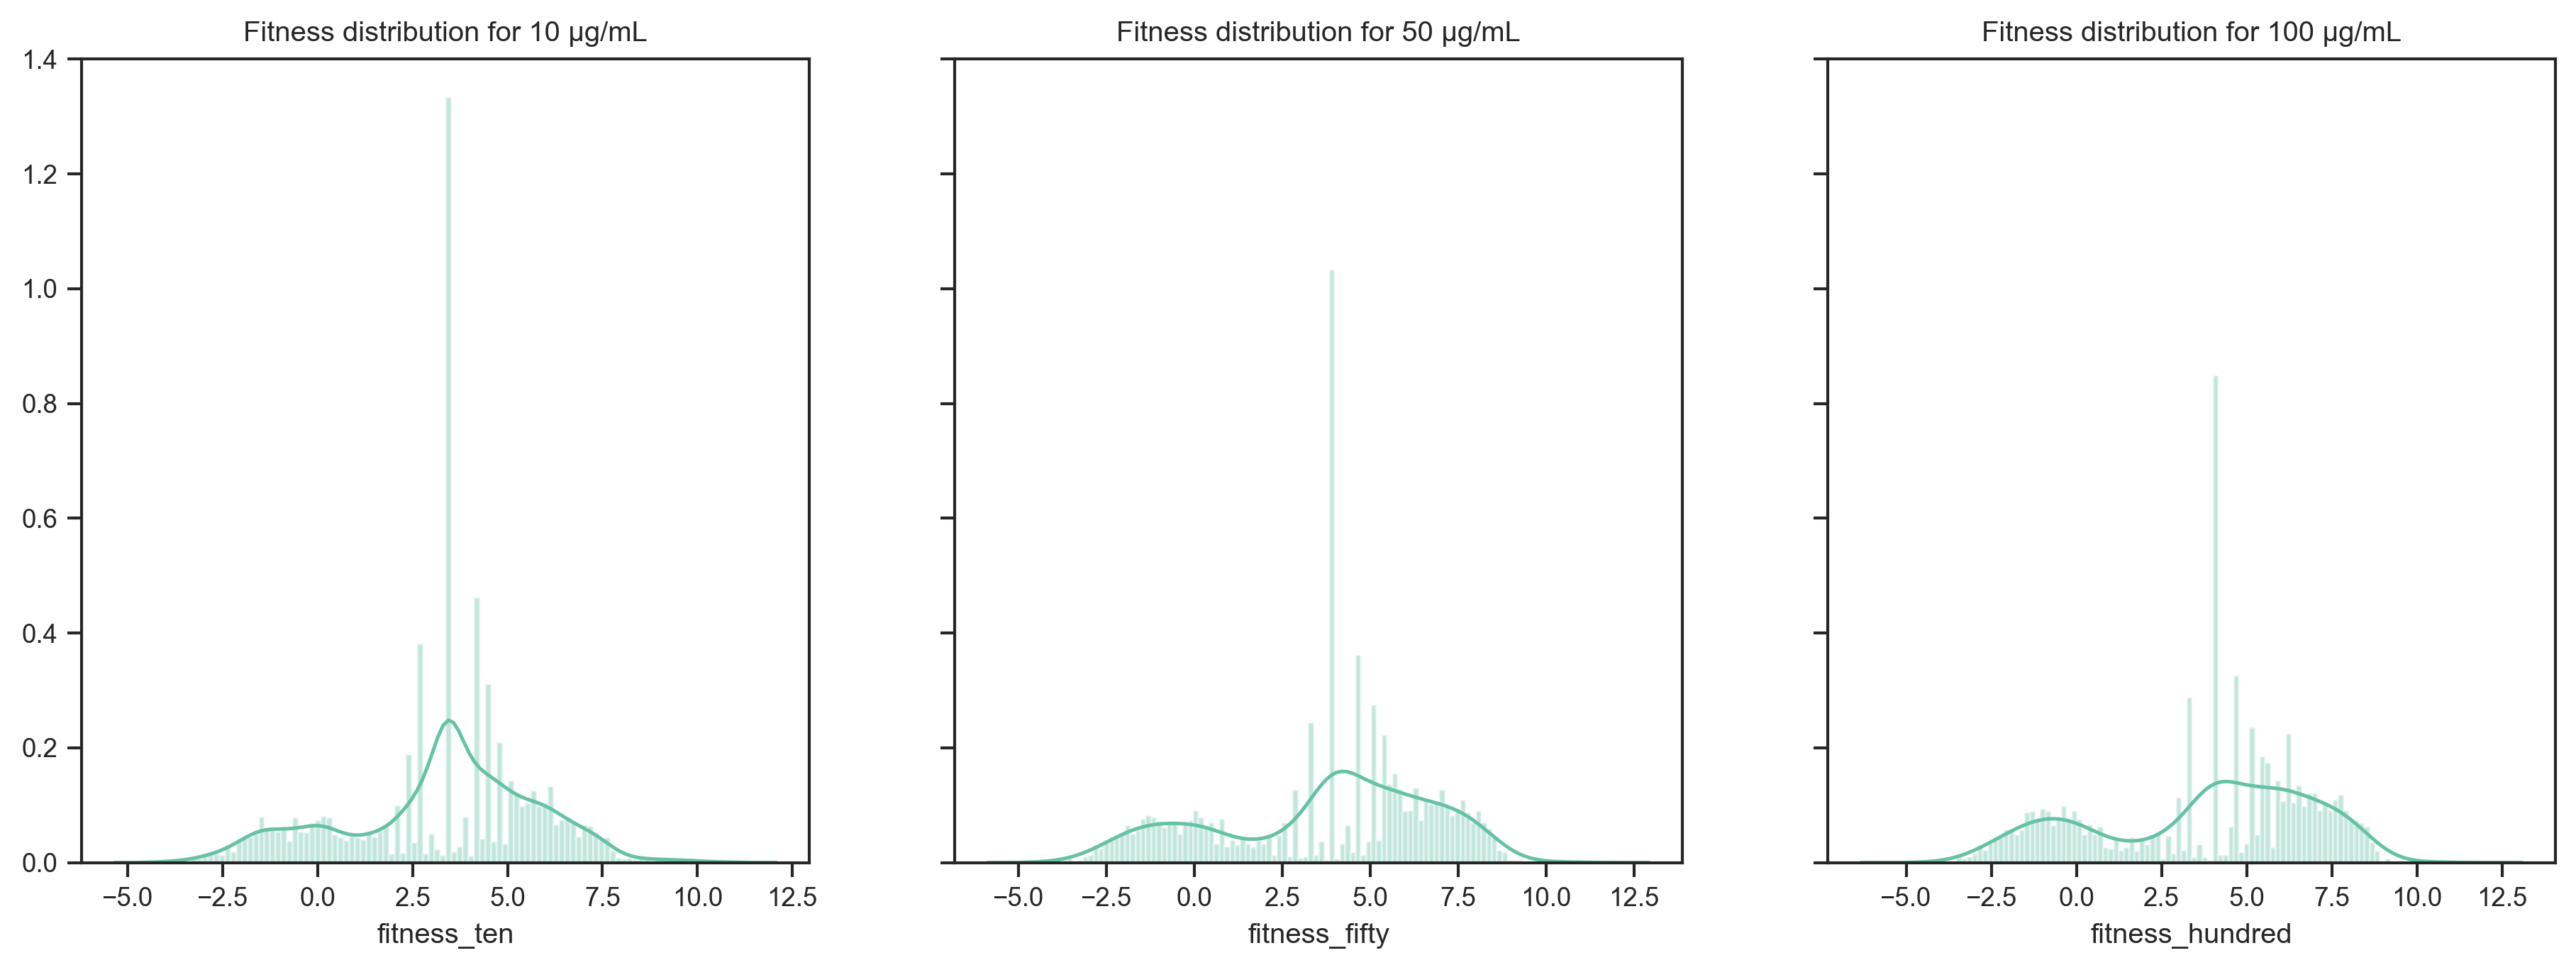

In [59]:
# Plot the fitness distrubution for each concentration, the data is not filtered yet
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.distplot(df_Dataset.fitness_ten, bins=100, ax=ax[0]).set_title(
    'Fitness distribution for 10 µg/mL')
sns.distplot(df_Dataset.fitness_fifty, bins=100, ax=ax[1]).set_title(
    'Fitness distribution for 50 µg/mL')
sns.distplot(df_Dataset.fitness_hundred, bins=100, ax=ax[2]).set_title(
    'Fitness distribution for 100 µg/mL')

# Data filtering

## Filtering

In [60]:
# Create a new datafram which contains all rows with stop mutations
condition = (df_Dataset.aa_change.str.find('*') >= 0)
df_stop = df_Dataset.loc[condition]

# Find the maximum counts associated with pre, ten, fifty and hundred in df_stop
stop_pre_max = df_stop.pre.max()
stop_ten_max = df_stop.ten.max()
stop_fifty_max = df_stop.fifty.max()
stop_hundred_max = df_stop.hundred.max()

# Filtering applied to each concentration
df_filtered = df_Dataset[(
    df_Dataset['ten'] > stop_ten_max) | (
    df_Dataset['fifty'] > stop_fifty_max) | (
    df_Dataset['hundred'] > stop_hundred_max) | (
    df_Dataset['pre'] > stop_pre_max)]

# Size of raw data vs filtered data
print('Size of raw data :', len(df_Dataset),
      '\nSize of filtered data :', len(df_filtered))

Size of raw data : 187225 
Size of filtered data : 791


## Fitness distribution for each concentrations (filtered)

Text(0.5, 1.0, 'Fitness distribution for 100 µg/mL')

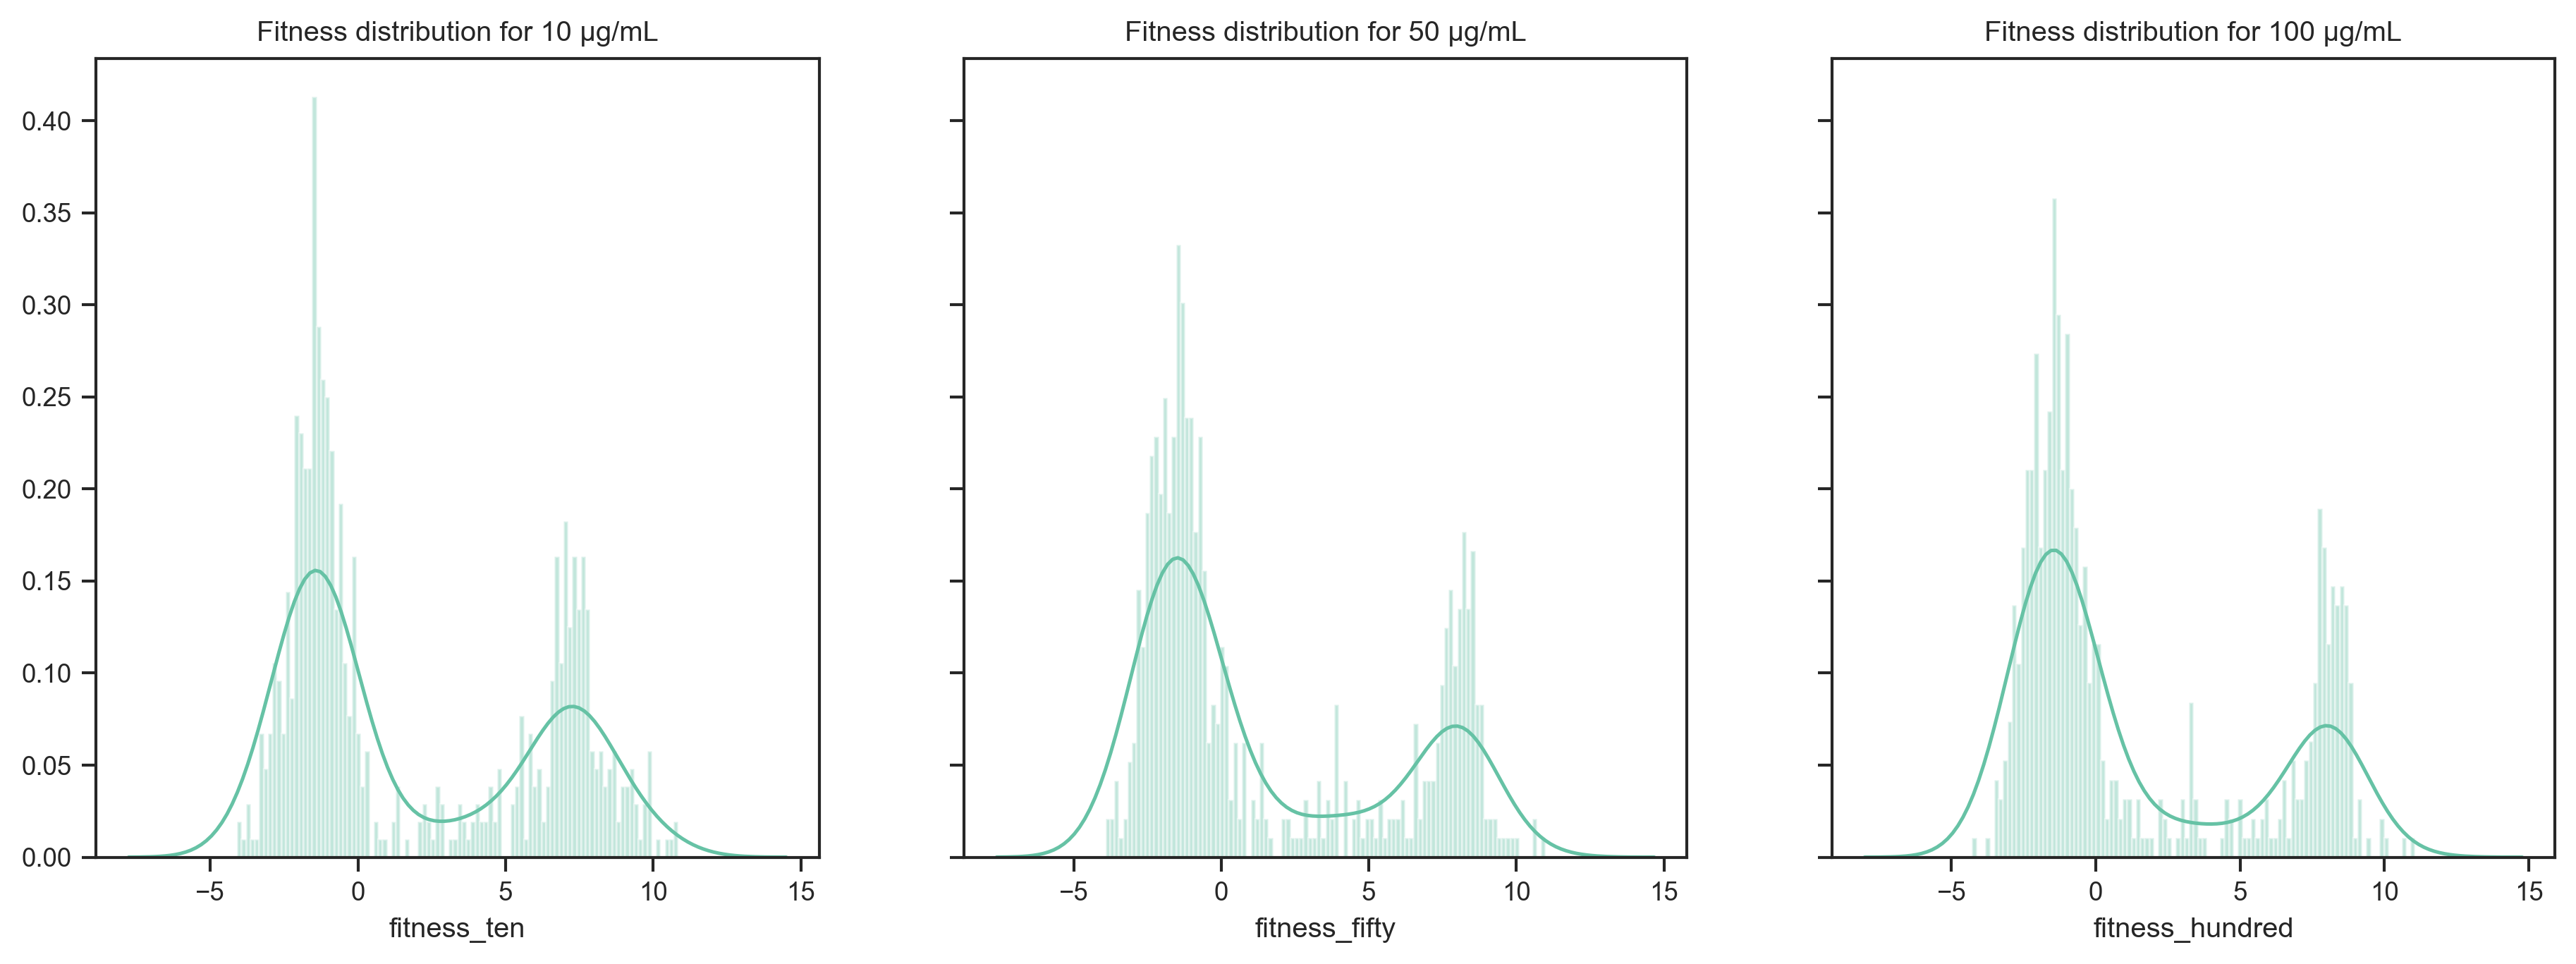

In [61]:
# Plot the fitness distribution for each concentration, the data is filtered
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.distplot(df_filtered.fitness_ten, bins=100, ax=ax[0]).set_title(
    'Fitness distribution for 10 µg/mL')
sns.distplot(df_filtered.fitness_fifty, bins=100, ax=ax[1]).set_title(
    'Fitness distribution for 50 µg/mL')
sns.distplot(df_filtered.fitness_hundred, bins=100, ax=ax[2]).set_title(
    'Fitness distribution for 100 µg/mL')

We distinguish two populations. The left one is not resistant to Rifampicin but the right one is. Regardless of antibiotic concentration, the fitness distribution appears to be similar. 

# Data analysis

## Analysis of single mutation

### Single mutation and removing of T563T

In [62]:
# Creates a new dataframe containing only the rows with a number of mutations <=
df_Dataset_single = df_filtered.loc[df_filtered.No_Mutations <= 2]

We can observe that we have T563T like the practical work seen in class. Therefore, we can delete it to simplify our dataset.

In [63]:
# Replace T563T by a blank space and then remove the , and then save it as a new dataset
df_Dataset_single = df_Dataset_single.loc[df_Dataset_single['aa_change'].str.contains('T563T') == True]
df_Dataset_single = df_Dataset_single.assign(
    Unique_Mutation=df_Dataset_single.aa_change.str.replace('T563T', ''))
df_Dataset_single = df_Dataset_single.assign(
    Unique_Mutation=df_Dataset_single.Unique_Mutation.str.replace(',', ''))
df_Dataset_single.to_csv('dataset.csv', index=False)
df_Dataset_single = pd.read_csv('dataset.csv', index_col=0)
df_Dataset_single = df_Dataset_single.reset_index(drop=True)

### Synonymous vs non synonymous : data processing

Some values of Unique_Mutation are float type and not str type. These values are 'NaN', we need to change them to 'None' before processing the data.

In [64]:
print('For example, on row 52 we have : ', '\nValue : ', df_Dataset_single.Unique_Mutation[52], '\nType : ',
      type(df_Dataset_single.Unique_Mutation[52]))
print('Number of "NaNs" :',
      df_Dataset_single['Unique_Mutation'].isnull().sum())

For example, on row 52 we have :  
Value :  nan 
Type :  <class 'float'>
Number of "NaNs" : 8


In [65]:
# We replace NaNs with a blank
df_Dataset_single['Unique_Mutation'] = df_Dataset_single['Unique_Mutation'].fillna(
    '')
print('\nOn row 52 we now have : ', '\nValue : ', df_Dataset_single.Unique_Mutation[52], '\nType : ',
      type(df_Dataset_single.Unique_Mutation[52]))
print('Number of "NaNs" :',
      df_Dataset_single['Unique_Mutation'].isnull().sum())


On row 52 we now have :  
Value :   
Type :  <class 'str'>
Number of "NaNs" : 0


In [66]:
def Is_Synonymous(Unique_Mutation):
    if Unique_Mutation != '':
        if Unique_Mutation[0] != Unique_Mutation[-1]:
            return 'No'
    return 'Yes'


df_Dataset_single = df_Dataset_single.assign(
    Is_Syn=df_Dataset_single.Unique_Mutation.apply(Is_Synonymous))
df_Dataset_single.head()

Mutations    aa_change  No_Mutations     pre       ten     fifty  \
0         A23T,C135G  H526L,T563T             2     1.0     115.0     157.0   
1  T161A,A160T,C135G  I572Y,T563T             2   860.0   41741.0   58883.0   
2    T37A,C38A,C135G  S531N,T563T             2   164.0    6078.0   10016.0   
3         A23T,C135G  H526L,T563T             2  4642.0  215334.0  325216.0   
4         A23T,C135G  H526L,T563T             2     3.0     116.0     156.0   

    hundred  fitness_ten  fitness_fifty  fitness_hundred Unique_Mutation  \
0     161.0     8.175689       9.014706         9.144500           H526L   
1   61661.0     7.313064       8.184836         8.335570           I572Y   
2   11716.0     7.043322       8.070533         8.331940           S531N   
3  297314.0     7.267802       8.207805         8.222739           H526L   
4     127.0     7.085735       7.909704         7.808671           H526L   

  Is_Syn  
0     No  
1     No  
2     No  
3     No  
4     No

### Synonymous vs non synonymous on single mutations : plotting 

In [67]:
df_single_synonymous = df_Dataset_single.loc[df_Dataset_single.Is_Syn == 'Yes']
df_single_non_synonymous = df_Dataset_single.loc[df_Dataset_single.Is_Syn == 'No']

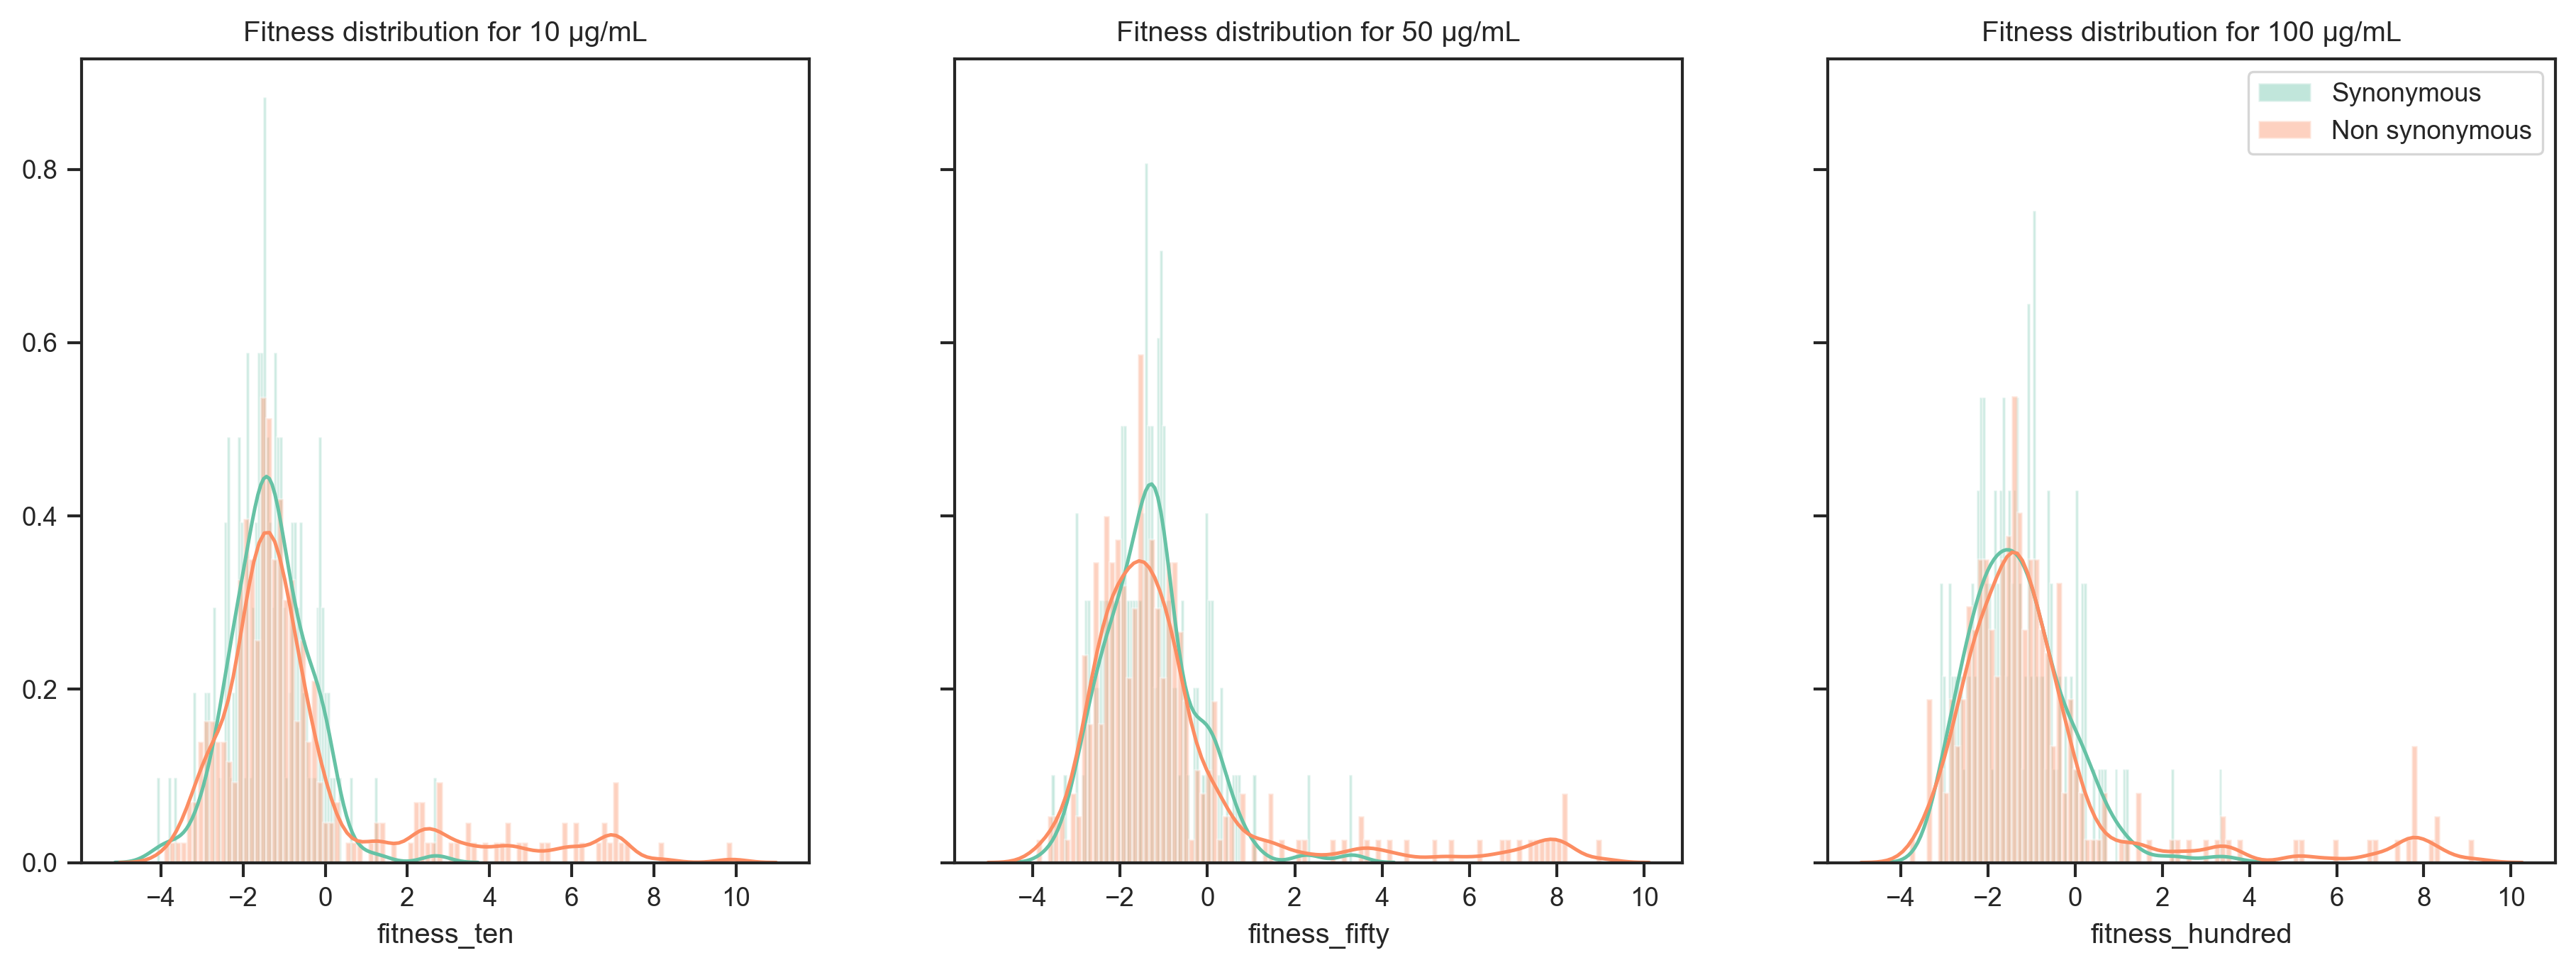

In [68]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.distplot(df_single_synonymous.fitness_ten, bins=100,
             ax=ax[0], label='Synonymous').set_title('Fitness distribution for 10 µg/mL')
sns.distplot(df_single_non_synonymous.fitness_ten,
             bins=100, ax=ax[0], label='Non synonymous')
sns.distplot(df_single_synonymous.fitness_fifty, bins=100,
             ax=ax[1], label='Synonymous').set_title('Fitness distribution for 50 µg/mL')
sns.distplot(df_single_non_synonymous.fitness_fifty,
             bins=100, ax=ax[1], label='Non synonymous')
sns.distplot(df_single_synonymous.fitness_hundred, bins=100,
             ax=ax[2], label='Synonymous').set_title('Fitness distribution for 100 µg/mL')
sns.distplot(df_single_non_synonymous.fitness_hundred,
             bins=100, ax=ax[2], label='Non synonymous')
plt.legend()

### Synonymous vs non synonymous : Standard deviation and resistant mutations

First, we need to find the mean and std for fitness of both mutations :

In [69]:
# Synonymous
syn_single_mean_ten = df_single_synonymous.fitness_ten.mean()
syn_single_mean_fifty = df_single_synonymous.fitness_fifty.mean()
syn_single_mean_hundred = df_single_synonymous.fitness_hundred.mean()

syn_single_std_ten = df_single_synonymous.fitness_ten.std()
syn_single_std_fifty = df_single_synonymous.fitness_fifty.std()
syn_single_std_hundred = df_single_synonymous.fitness_hundred.std()

# Non-synonymous
non_syn_single_mean_ten = df_single_non_synonymous.fitness_ten.mean()
non_syn_single_mean_fifty = df_single_non_synonymous.fitness_fifty.mean()
non_syn_single_mean_hundred = df_single_non_synonymous.fitness_hundred.mean()

non_syn_single_std_ten = df_single_non_synonymous.fitness_ten.std()
non_syn_single_std_fifty = df_single_non_synonymous.fitness_fifty.std()
non_syn_single_std_hundred = df_single_non_synonymous.fitness_hundred.std()

Then, we identify all mutations that are outside the 99% confidence interval :

In [70]:
# Synonymous
confidence_level = 0.99
degrees_freedom = len(df_single_synonymous) - 1

syn_confidence_interval_ten = stats.t.interval(
    confidence_level, degrees_freedom, syn_single_mean_ten, syn_single_std_ten)
syn_confidence_interval_fifty = stats.t.interval(
    confidence_level, degrees_freedom, syn_single_mean_fifty, syn_single_std_fifty)
syn_confidence_interval_hundred = stats.t.interval(
    confidence_level, degrees_freedom, syn_single_mean_hundred, syn_single_std_hundred)

syn_confidence_interval_max_ten = syn_confidence_interval_ten[1]
syn_confidence_interval_max_fifty = syn_confidence_interval_fifty[1]
syn_confidence_interval_max_hundred = syn_confidence_interval_hundred[1]


syn_condition_ten = (df_single_synonymous.fitness_ten >
                     syn_confidence_interval_max_ten)
syn_condition_fifty = (df_single_synonymous.fitness_fifty >
                       syn_confidence_interval_max_fifty)
syn_condition_hundred = (
    df_single_synonymous.fitness_hundred > syn_confidence_interval_max_hundred)
syn_condition = syn_condition_ten | syn_condition_fifty | syn_condition_hundred

# Non-synonymous
degrees_freedom = len(df_single_non_synonymous) - 1

non_syn_confidence_interval_ten = stats.t.interval(
    confidence_level, degrees_freedom, non_syn_single_mean_ten, non_syn_single_std_ten)
non_syn_confidence_interval_fifty = stats.t.interval(
    confidence_level, degrees_freedom, non_syn_single_mean_fifty, non_syn_single_std_fifty)
non_syn_confidence_interval_hundred = stats.t.interval(
    confidence_level, degrees_freedom, non_syn_single_mean_hundred, non_syn_single_std_hundred)

non_syn_confidence_interval_max_ten = non_syn_confidence_interval_ten[1]
non_syn_confidence_interval_max_fifty = non_syn_confidence_interval_fifty[1]
non_syn_confidence_interval_max_hundred = non_syn_confidence_interval_hundred[1]


non_syn_condition_ten = (
    df_single_non_synonymous.fitness_ten > non_syn_confidence_interval_max_ten)
non_syn_condition_fifty = (
    df_single_non_synonymous.fitness_fifty > non_syn_confidence_interval_max_fifty)
non_syn_condition_hundred = (
    df_single_non_synonymous.fitness_hundred > non_syn_confidence_interval_max_hundred)
non_syn_condition = non_syn_condition_ten | non_syn_condition_fifty | non_syn_condition_hundred

Let's create a new dataset for resistant mutations that are outside the 99% confidence interval.

In [71]:
# Synonymous
df_syn_resistant_ten = df_single_synonymous.drop(
    ['fifty', 'fitness_fifty', 'hundred', 'fitness_hundred'], axis=1).loc[syn_condition_ten]
df_syn_resistant_fifty = df_single_synonymous.drop(
    ['ten', 'fitness_ten', 'hundred', 'fitness_hundred'], axis=1).loc[syn_condition_fifty]
df_syn_resistant_hundred = df_single_synonymous.drop(
    ['fifty', 'fitness_fifty', 'ten', 'fitness_ten'], axis=1).loc[syn_condition_hundred]
df_syn_resistant = df_single_synonymous.loc[syn_condition]


# Non-synonymous
df_non_syn_resistant_ten = df_single_non_synonymous.drop(
    ['fifty', 'fitness_fifty', 'hundred', 'fitness_hundred'], axis=1).loc[non_syn_condition_ten]
df_non_syn_resistant_fifty = df_single_non_synonymous.drop(
    ['ten', 'fitness_ten', 'hundred', 'fitness_hundred'], axis=1).loc[non_syn_condition_fifty]
df_non_syn_resistant_hundred = df_single_non_synonymous.drop(
    ['fifty', 'fitness_fifty', 'ten', 'fitness_ten'], axis=1).loc[non_syn_condition_hundred]
df_non_syn_resistant = df_single_non_synonymous.loc[non_syn_condition]

### Comparison of fitness between synonymous and non-synonymous mutations in resistant strains :

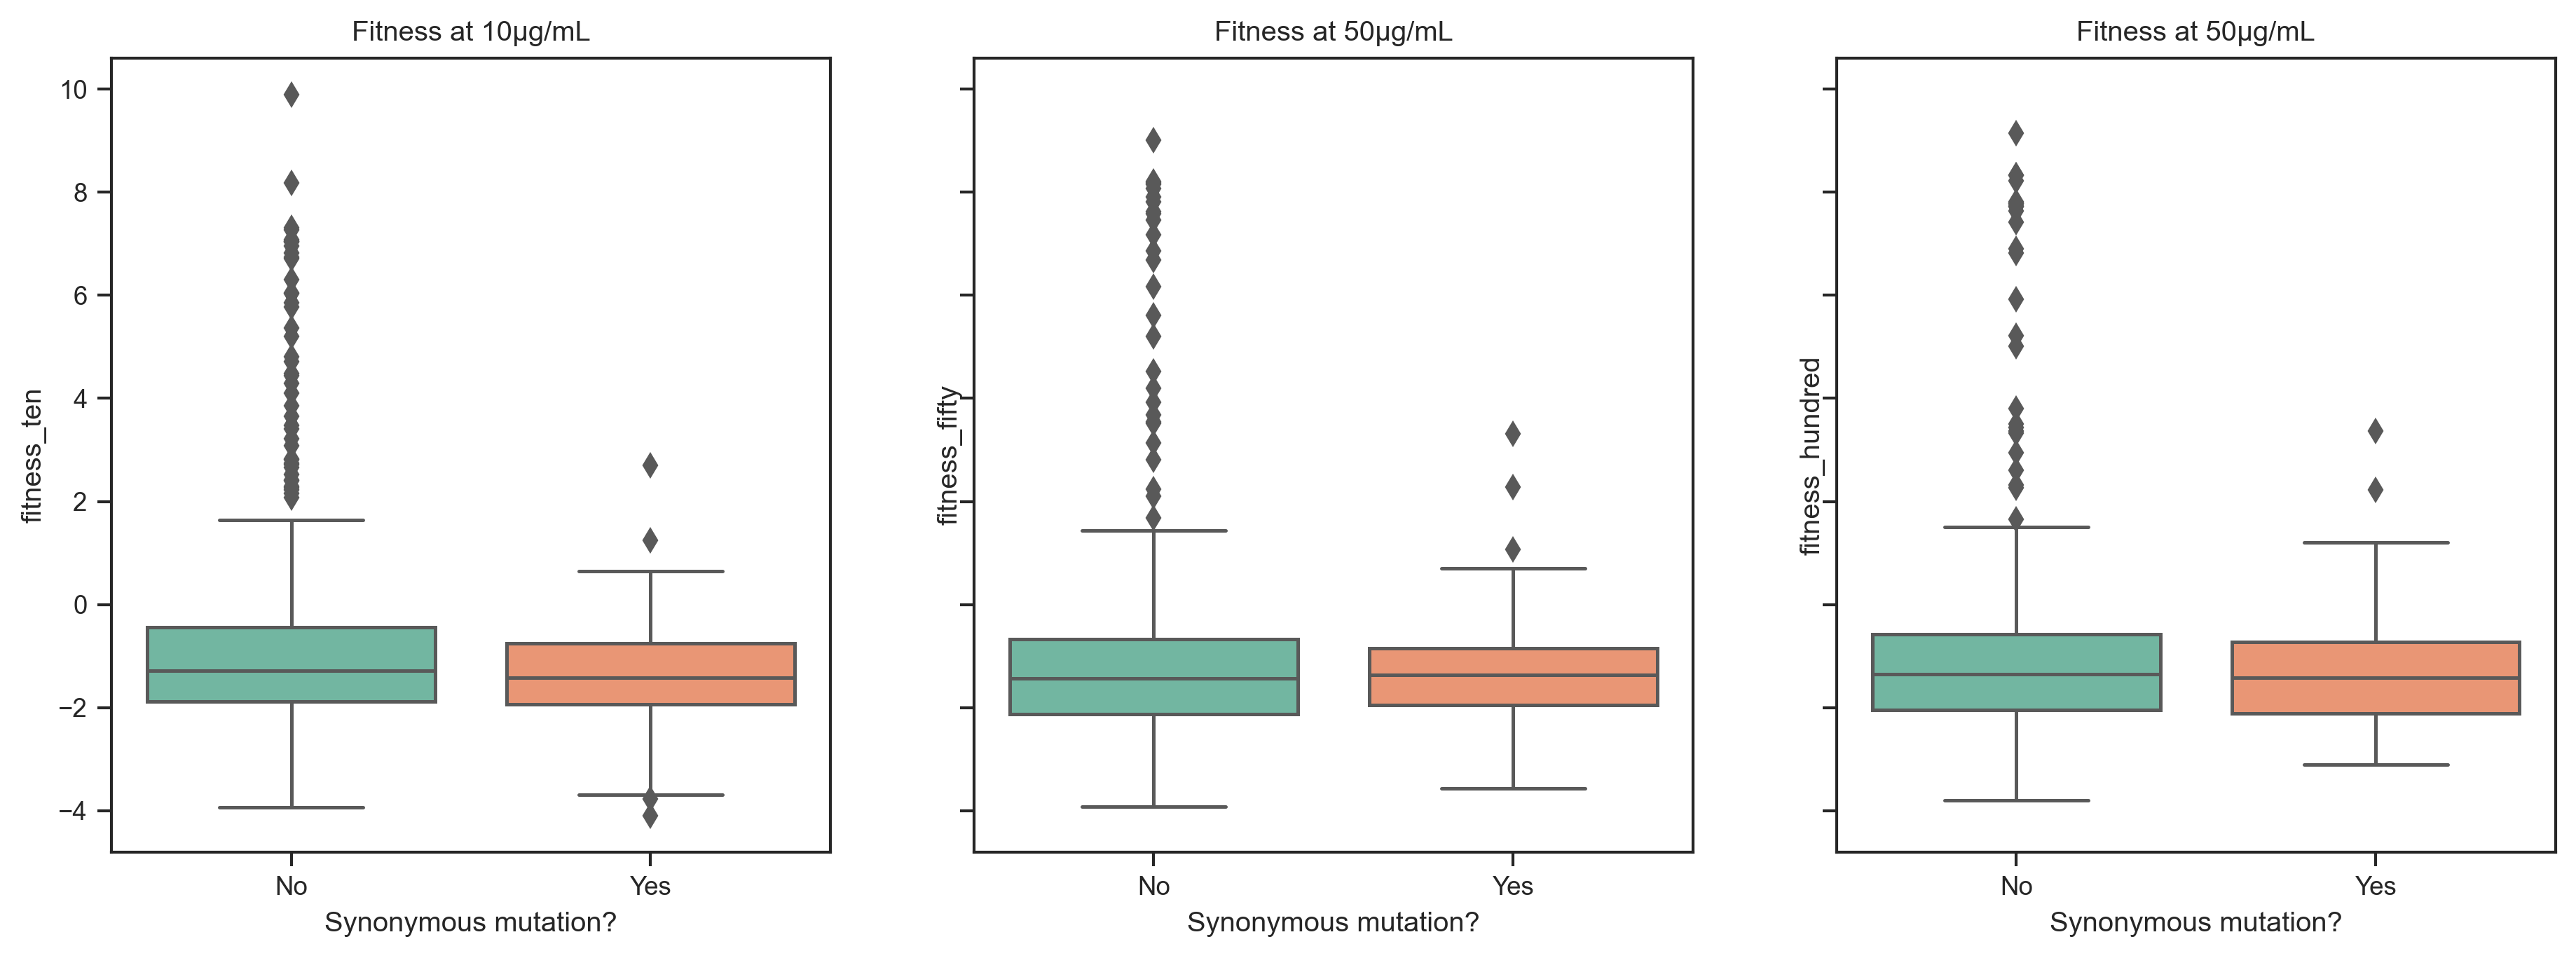

In [72]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
sns.boxplot(x=df_Dataset_single['Is_Syn'],
            y=df_Dataset_single['fitness_ten'], ax=ax[0])
sns.boxplot(x=df_Dataset_single['Is_Syn'],
            y=df_Dataset_single['fitness_fifty'], ax=ax[1])
sns.boxplot(x=df_Dataset_single['Is_Syn'],
            y=df_Dataset_single['fitness_hundred'], ax=ax[2])
ax[0].title.set_text('Fitness at 10µg/mL')
ax[1].title.set_text('Fitness at 50µg/mL')
ax[2].title.set_text('Fitness at 50µg/mL')
ax[0].set_xlabel('Synonymous mutation?')
ax[1].set_xlabel('Synonymous mutation?')
ax[2].set_xlabel('Synonymous mutation?')
plt.show()

### Fitness relative to position of the mutation

In [73]:
# Extraction of the positions - only valid for 1 mutation -
df_syn_resistant = df_syn_resistant.assign(
    Position=df_syn_resistant['Unique_Mutation'].str[1:-1])
df_non_syn_resistant = df_non_syn_resistant.assign(
    Position=df_non_syn_resistant['Unique_Mutation'].str[1:-1])

# Converting str to int
df_syn_resistant['Position'] = pd.to_numeric(df_syn_resistant['Position'])
df_non_syn_resistant['Position'] = pd.to_numeric(
    df_non_syn_resistant['Position'])

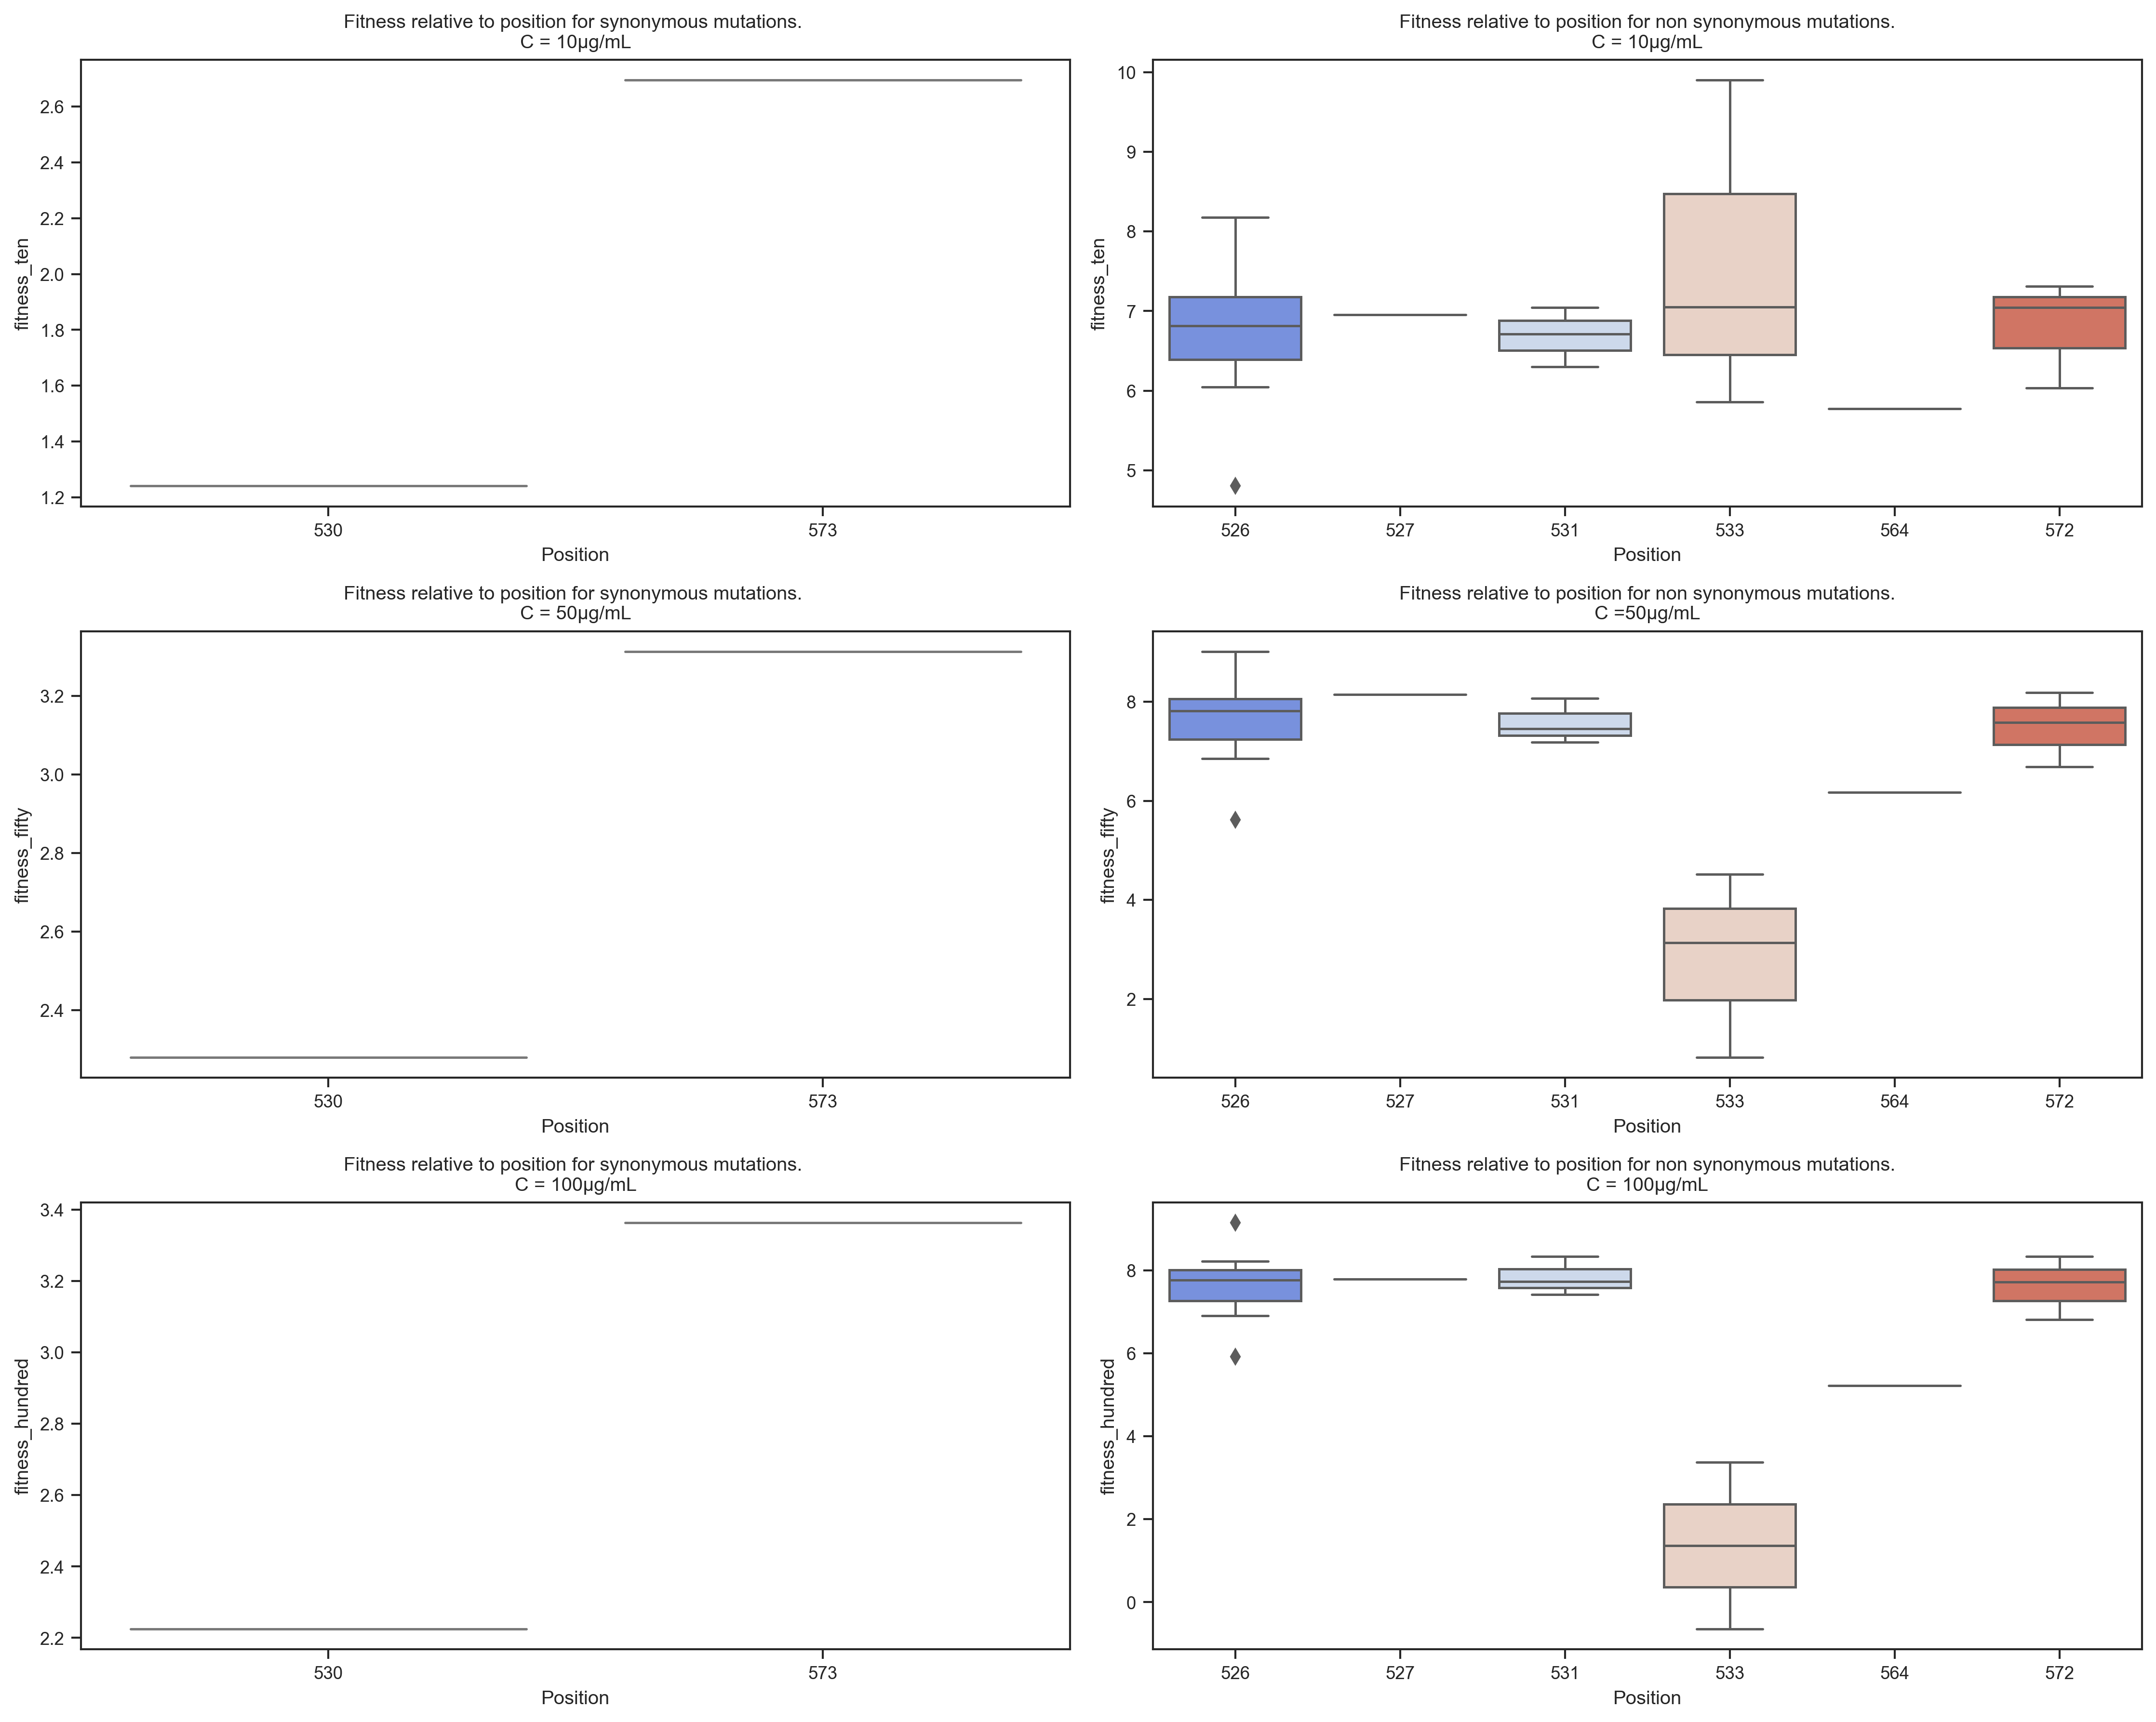

In [74]:
# Creating new boxplots, x=Position and y=fitness, for each concentration
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(3, 2, figsize=(15, 12))
sns.boxplot(ax=ax[0, 0], x=df_syn_resistant['Position'],
            y=df_syn_resistant['fitness_ten'], palette='coolwarm')
ax[0, 0].set_title(
    'Fitness relative to position for synonymous mutations. \nC = 10µg/mL')
sns.boxplot(ax=ax[0, 1], x=df_non_syn_resistant['Position'],
            y=df_non_syn_resistant['fitness_ten'], palette='coolwarm')
ax[0, 1].set_title(
    'Fitness relative to position for non synonymous mutations.\nC = 10µg/mL')

sns.boxplot(ax=ax[1, 0], x=df_syn_resistant['Position'],
            y=df_syn_resistant['fitness_fifty'], palette='coolwarm')
ax[1, 0].set_title(
    'Fitness relative to position for synonymous mutations. \nC = 50µg/mL')
sns.boxplot(ax=ax[1, 1], x=df_non_syn_resistant['Position'],
            y=df_non_syn_resistant['fitness_fifty'], palette='coolwarm')
ax[1, 1].set_title(
    'Fitness relative to position for non synonymous mutations.\nC =50µg/mL')

sns.boxplot(ax=ax[2, 0], x=df_syn_resistant['Position'],
            y=df_syn_resistant['fitness_hundred'], palette='coolwarm')
ax[2, 0].set_title(
    'Fitness relative to position for synonymous mutations. \nC = 100µg/mL')
sns.boxplot(ax=ax[2, 1], x=df_non_syn_resistant['Position'],
            y=df_non_syn_resistant['fitness_hundred'], palette='coolwarm')
ax[2, 1].set_title(
    'Fitness relative to position for non synonymous mutations.\nC = 100µg/mL')

plt.tight_layout()

Boxploting for the synonymous mutations is not really usefull.

### Fitness of residues 526, 529, 533, 534 and 572

In [75]:
# Creation of the 'Position' column, convertion to numeric
df_Dataset_single = df_Dataset_single.assign(
    Position=df_Dataset_single['Unique_Mutation'].str[1:-1])
df_Dataset_single['Position'] = pd.to_numeric(df_Dataset_single['Position'])

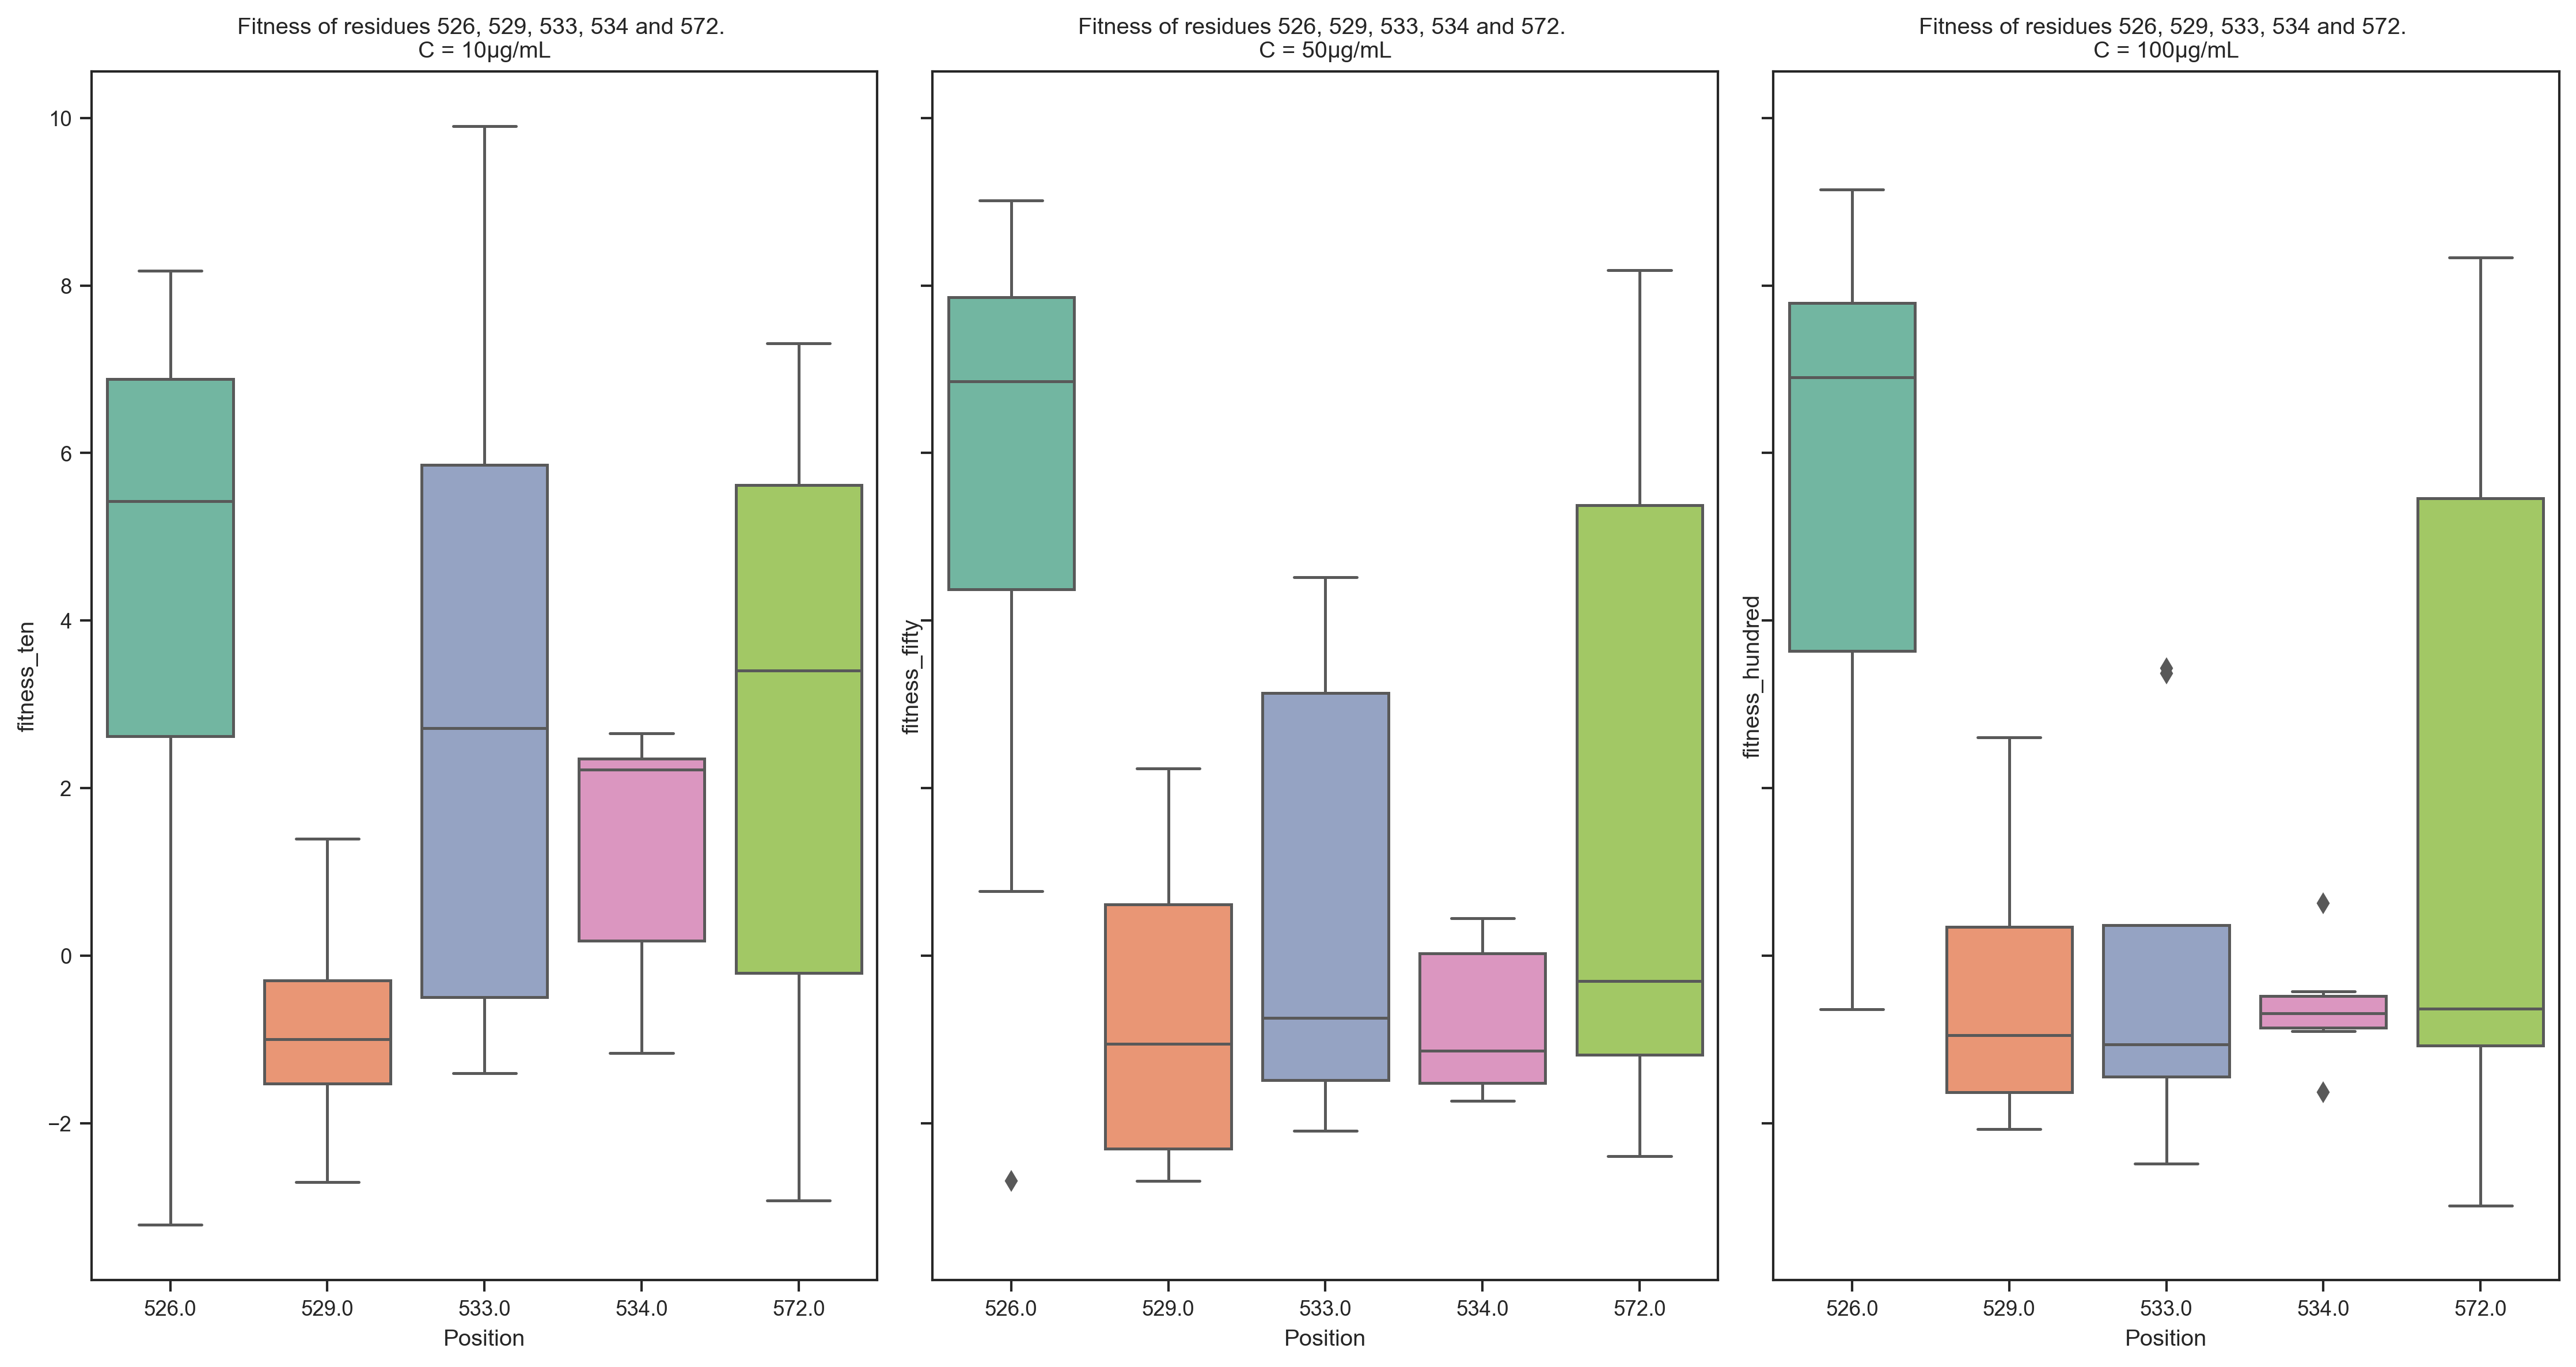

In [76]:
# Fitness plotting for residues 526, 529, 533, 534 and 572 for every concentration.
condition = (df_Dataset_single['Position'] == 526) | (
    df_Dataset_single['Position'] == 529) | (
    df_Dataset_single['Position'] == 533) | (
    df_Dataset_single['Position'] == 534) | (
    df_Dataset_single['Position'] == 572)

sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

sns.boxplot(ax=ax[0], x=df_Dataset_single.loc[condition].Position,
            y=df_Dataset_single.loc[condition].fitness_ten)
ax[0].set_title(
    'Fitness of residues 526, 529, 533, 534 and 572. \nC = 10µg/mL')

sns.boxplot(ax=ax[1], x=df_Dataset_single.loc[condition].Position,
            y=df_Dataset_single.loc[condition].fitness_fifty)
ax[1].set_title(
    'Fitness of residues 526, 529, 533, 534 and 572. \nC = 50µg/mL')

sns.boxplot(ax=ax[2], x=df_Dataset_single.loc[condition].Position,
            y=df_Dataset_single.loc[condition].fitness_hundred)
ax[2].set_title(
    'Fitness of residues 526, 529, 533, 534 and 572. \nC = 100µg/mL')

plt.tight_layout()

In [77]:
# Creating 'Is_Interacting' column.
def fn_Interacting(Position):
    if Position == 526 or Position == 529 or Position == 533 or Position == 534 or Position == 572:
        return 'Yes'
    return 'No'


df_Dataset_single = df_Dataset_single.assign(
    Is_Interacting=df_Dataset_single.Position.apply(fn_Interacting))

Text(0.5, 1.0, 'Interacting vs non-interacting residues. \nC = 100µg/mL')

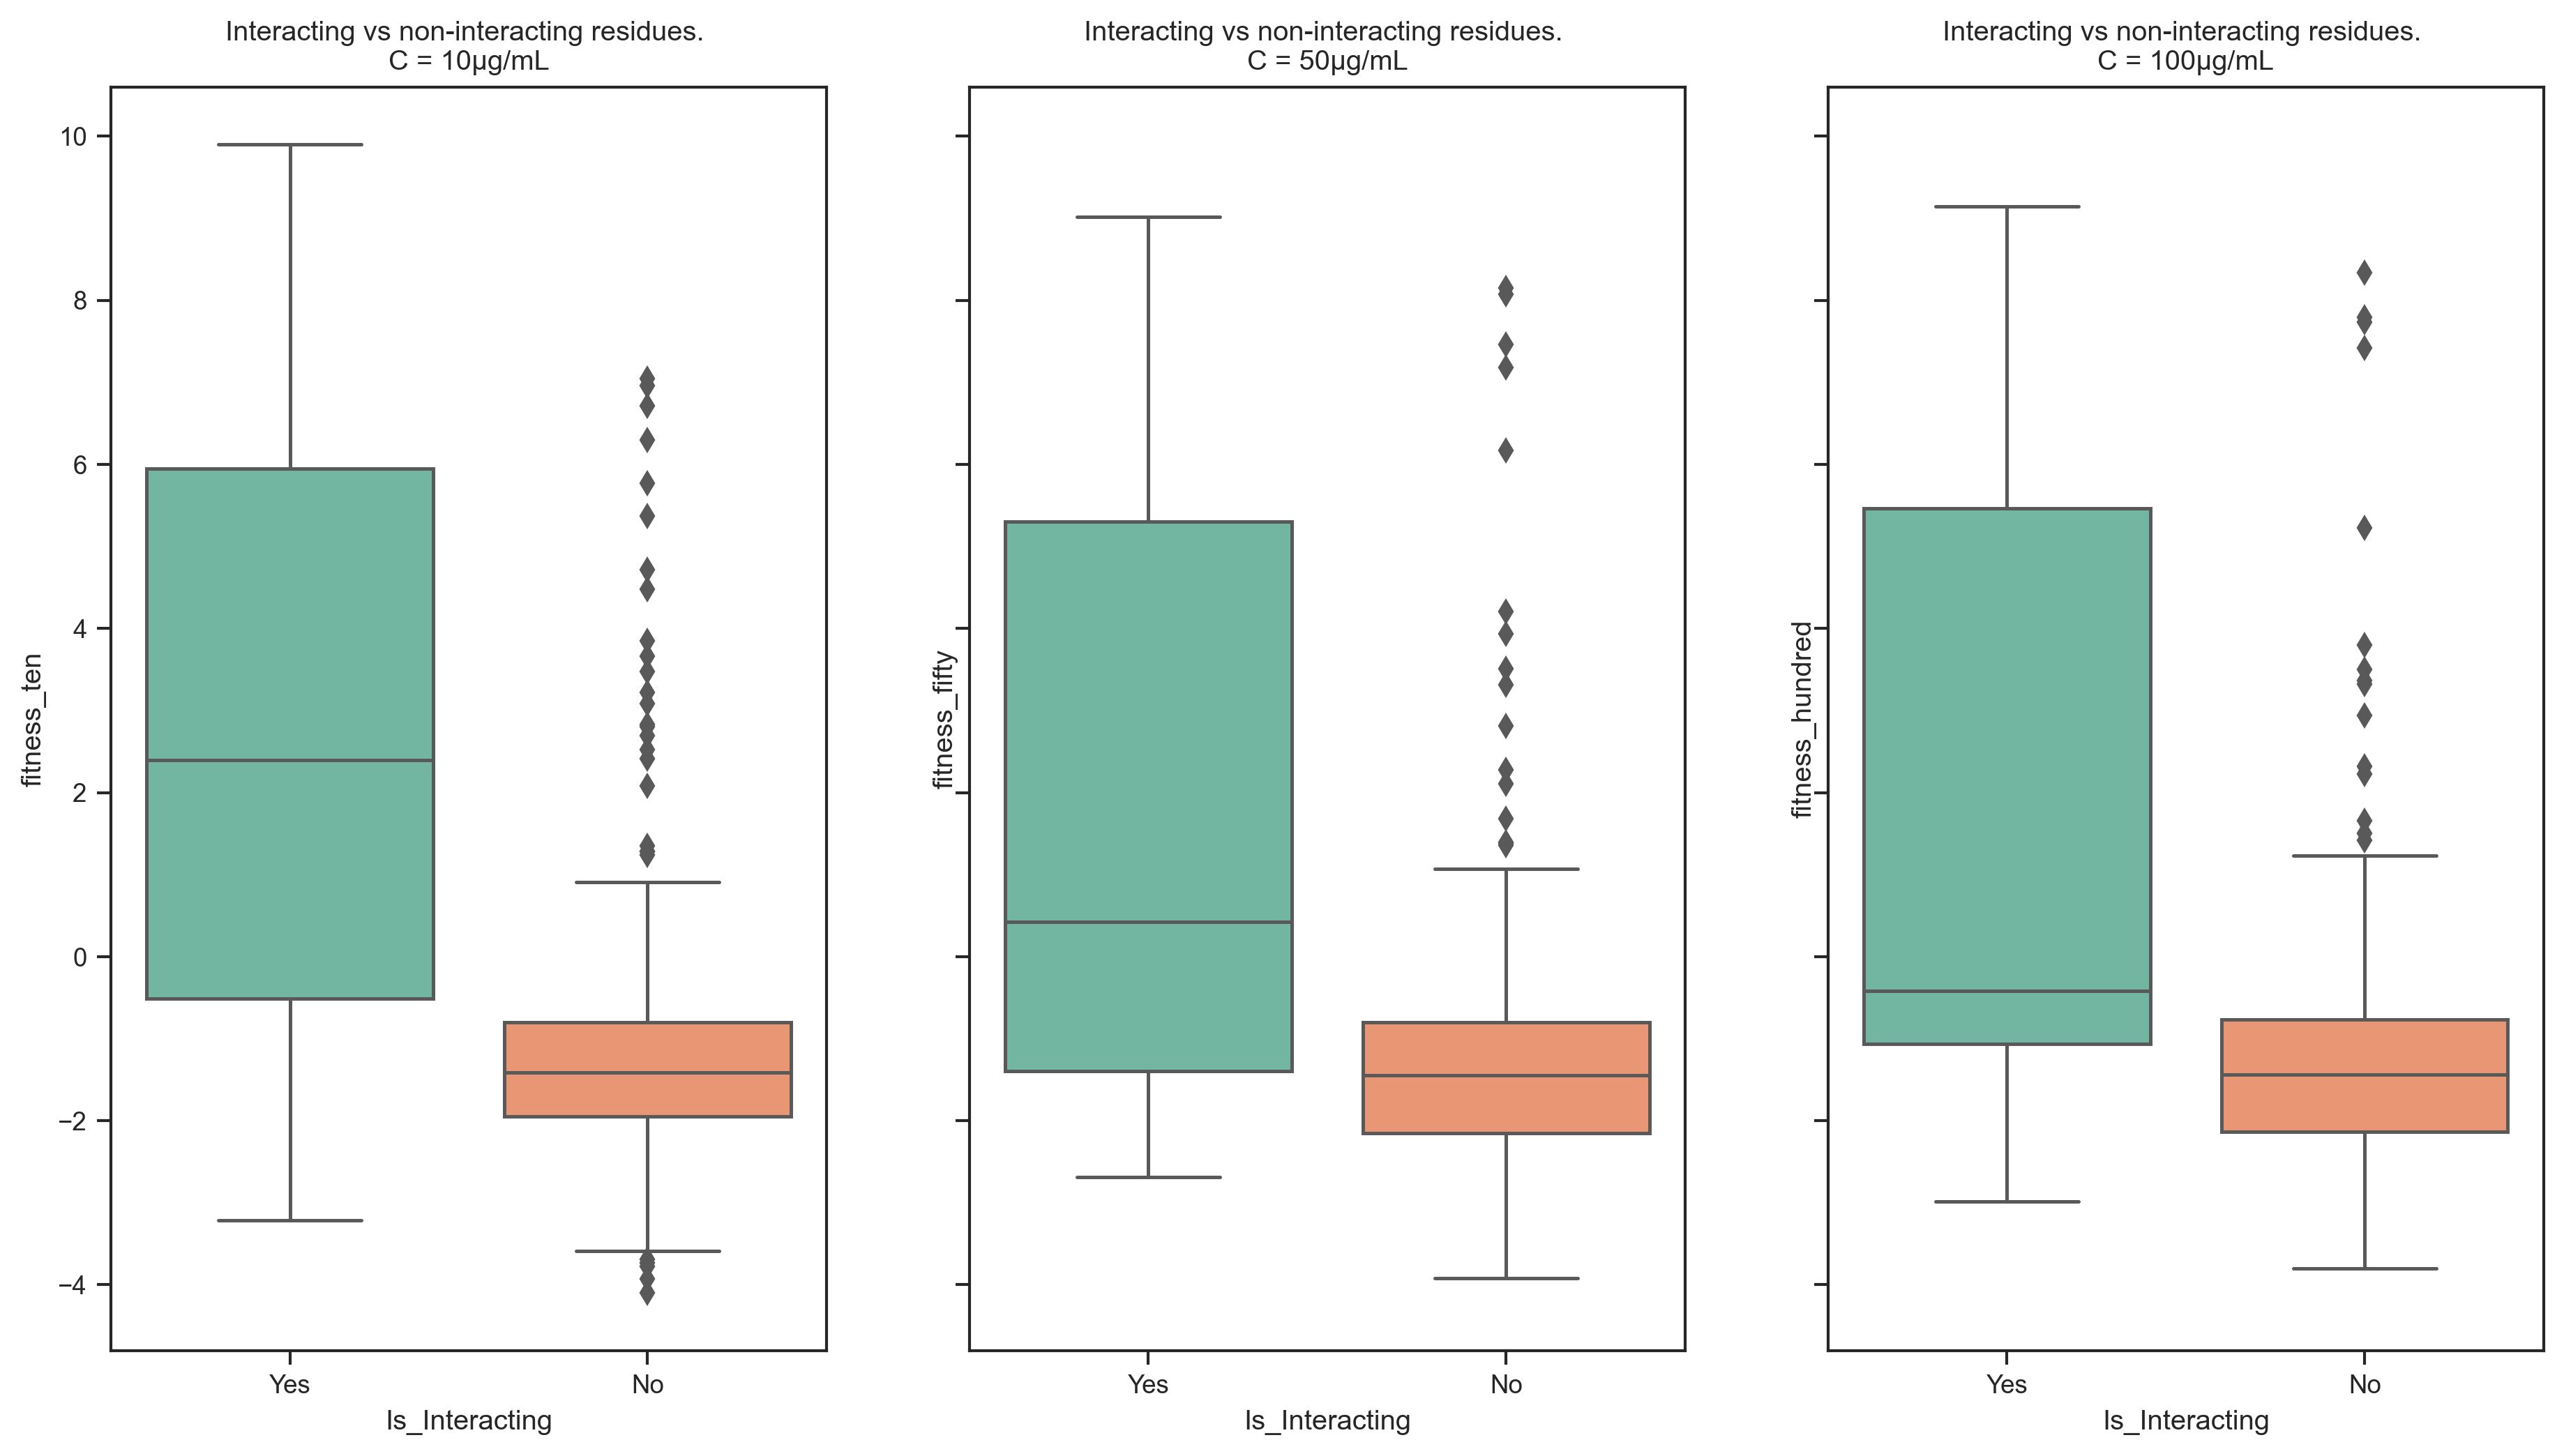

In [78]:
# Plotting interacting vs non interacting for each concentration.
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

sns.boxplot(ax=ax[0], x=df_Dataset_single.Is_Interacting,
            y=df_Dataset_single.fitness_ten)
ax[0].set_title('Interacting vs non-interacting residues. \nC = 10µg/mL')

sns.boxplot(ax=ax[1], x=df_Dataset_single.Is_Interacting,
            y=df_Dataset_single.fitness_fifty)
ax[1].set_title('Interacting vs non-interacting residues. \nC = 50µg/mL')

sns.boxplot(ax=ax[2], x=df_Dataset_single.Is_Interacting,
            y=df_Dataset_single.fitness_hundred)
ax[2].set_title('Interacting vs non-interacting residues. \nC = 100µg/mL')

### Multiple mutations

In [79]:
# Deletes the T563T mutation.
df_Dataset_multiple = df_filtered
df_Dataset_multiple = df_Dataset_multiple.assign(
    Unique_Mutations=df_Dataset_multiple.aa_change.str.replace('T563T', ''))

In [80]:
# Convert to str format, replace the ',,' with ',' and delete the ',' at the beginning and at the end.
df_Dataset_multiple.Unique_Mutations.astype(str)

# Line 2924 is corresponding to no mutation (nan)
df_Dataset_multiple.Unique_Mutations[2924] = ''
df_Dataset_multiple.Unique_Mutations = df_Dataset_multiple.Unique_Mutations.replace(
    ',,', ',')
df_Dataset_multiple.Unique_Mutations = df_Dataset_multiple.Unique_Mutations.str.rstrip(
    to_strip=',')
df_Dataset_multiple.Unique_Mutations = df_Dataset_multiple.Unique_Mutations.str.lstrip(
    to_strip=',')

In [81]:
'''
The code is quite ugly but I had an error while browsing the strings using the method I had used 
for the practical.
'''


def fn_Nb_Synonymous(Unique_Mutations):
    i = 0
    nb_synonymous = 0

    if len(Unique_Mutations) > 0:
        if len(Unique_Mutations) == 5:
            if Unique_Mutations[0] == Unique_Mutations[4]:
                nb_synonymous = nb_synonymous + 1
        if len(Unique_Mutations) == 11:
            if Unique_Mutations[0] == Unique_Mutations[4]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[6] == Unique_Mutations[10]:
                nb_synonymous = nb_synonymous + 1
        if len(Unique_Mutations) == 17:
            if Unique_Mutations[0] == Unique_Mutations[4]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[6] == Unique_Mutations[10]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[11] == Unique_Mutations[16]:
                nb_synonymous = nb_synonymous + 1
        if len(Unique_Mutations) == 23:
            if Unique_Mutations[0] == Unique_Mutations[4]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[6] == Unique_Mutations[10]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[11] == Unique_Mutations[16]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[17] == Unique_Mutations[22]:
                nb_synonymous = nb_synonymous + 1
        if len(Unique_Mutations) == 29:
            if Unique_Mutations[0] == Unique_Mutations[4]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[6] == Unique_Mutations[10]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[11] == Unique_Mutations[16]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[17] == Unique_Mutations[22]:
                nb_synonymous = nb_synonymous + 1
            elif Unique_Mutations[23] == Unique_Mutations[28]:
                nb_synonymous = nb_synonymous + 1

        return nb_synonymous

    else:
        return 0

In [82]:
# Create a new column indicating the number of synonymous mutations among all the mutations. 
df_Dataset_multiple = df_Dataset_multiple.assign(
    Nb_Syn=df_Dataset_multiple.Unique_Mutations.apply(fn_Nb_Synonymous))
df_Dataset_multiple.head()

Mutations_Position  \
0  {'A': [161], 'C': [], 'T': [23, 160], 'G': [135]}   
1  {'A': [161, 207], 'C': [], 'T': [23, 160], 'G'...   
2  {'A': [161], 'C': [], 'T': [38, 160], 'G': [135]}   
3  {'A': [38, 161], 'C': [], 'T': [160], 'G': [135]}   
4     {'A': [], 'C': [], 'T': [23, 160], 'G': [135]}   

                      Mutations                aa_change  No_Mutations   pre  \
0        T161A,A23T,A160T,C135G        H526L,I572Y,T563T             3   5.0   
1  T161A,T207A,A23T,A160T,C135G  L587L,H526L,I572Y,T563T             4   2.0   
2        T161A,C38T,A160T,C135G        S531F,I572Y,T563T             3   1.0   
3        C38A,T161A,A160T,C135G        S531Y,I572Y,T563T             3   1.0   
4              A23T,A160T,C135G        H526L,I572F,T563T             3  13.0   

      ten   fifty  hundred  fitness_ten  fitness_fifty  fitness_hundred  \
0  2652.0  5604.0   5417.0     9.704388      10.980258        11.050955   
1   704.0  1484.0   1518.0     9.294388      10.567810        10.695098   
2   190.0   361.0    416.0     8.677781       9.847338        10.093781   
3   200.0   320.0    362.0     8.729074       9.726781         9.954740   
4  3101.0  5209.0   4442.0     8.905288       9.951654         9.897007   

    Unique_Mutations  Nb_Syn  
0        H526L,I572Y       0  
1  L587L,H526L,I572Y       1  
2        S531F,I572Y       0  
3        S531Y,I572Y       0  
4        H526L,I572F       0

In [83]:
# Count the values in Nb_Syn
df_Dataset_multiple.Nb_Syn.value_counts()

0    535
1    256
Name: Nb_Syn, dtype: int64

In [84]:
'''
Create 2 dataframes for rows with synonymous and non synonymous mutations. If we had a number of
mutations different from 0 and 1, we could have created a data frame for the rows with 1 mutation and 
another data frame for the rows with 2 mutations for example.
'''
df_Dataset_multiple_syn = df_Dataset_multiple.loc[df_Dataset_multiple.Nb_Syn > 0]
df_Dataset_multiple_non_syn = df_Dataset_multiple.loc[df_Dataset_multiple.Nb_Syn == 0]

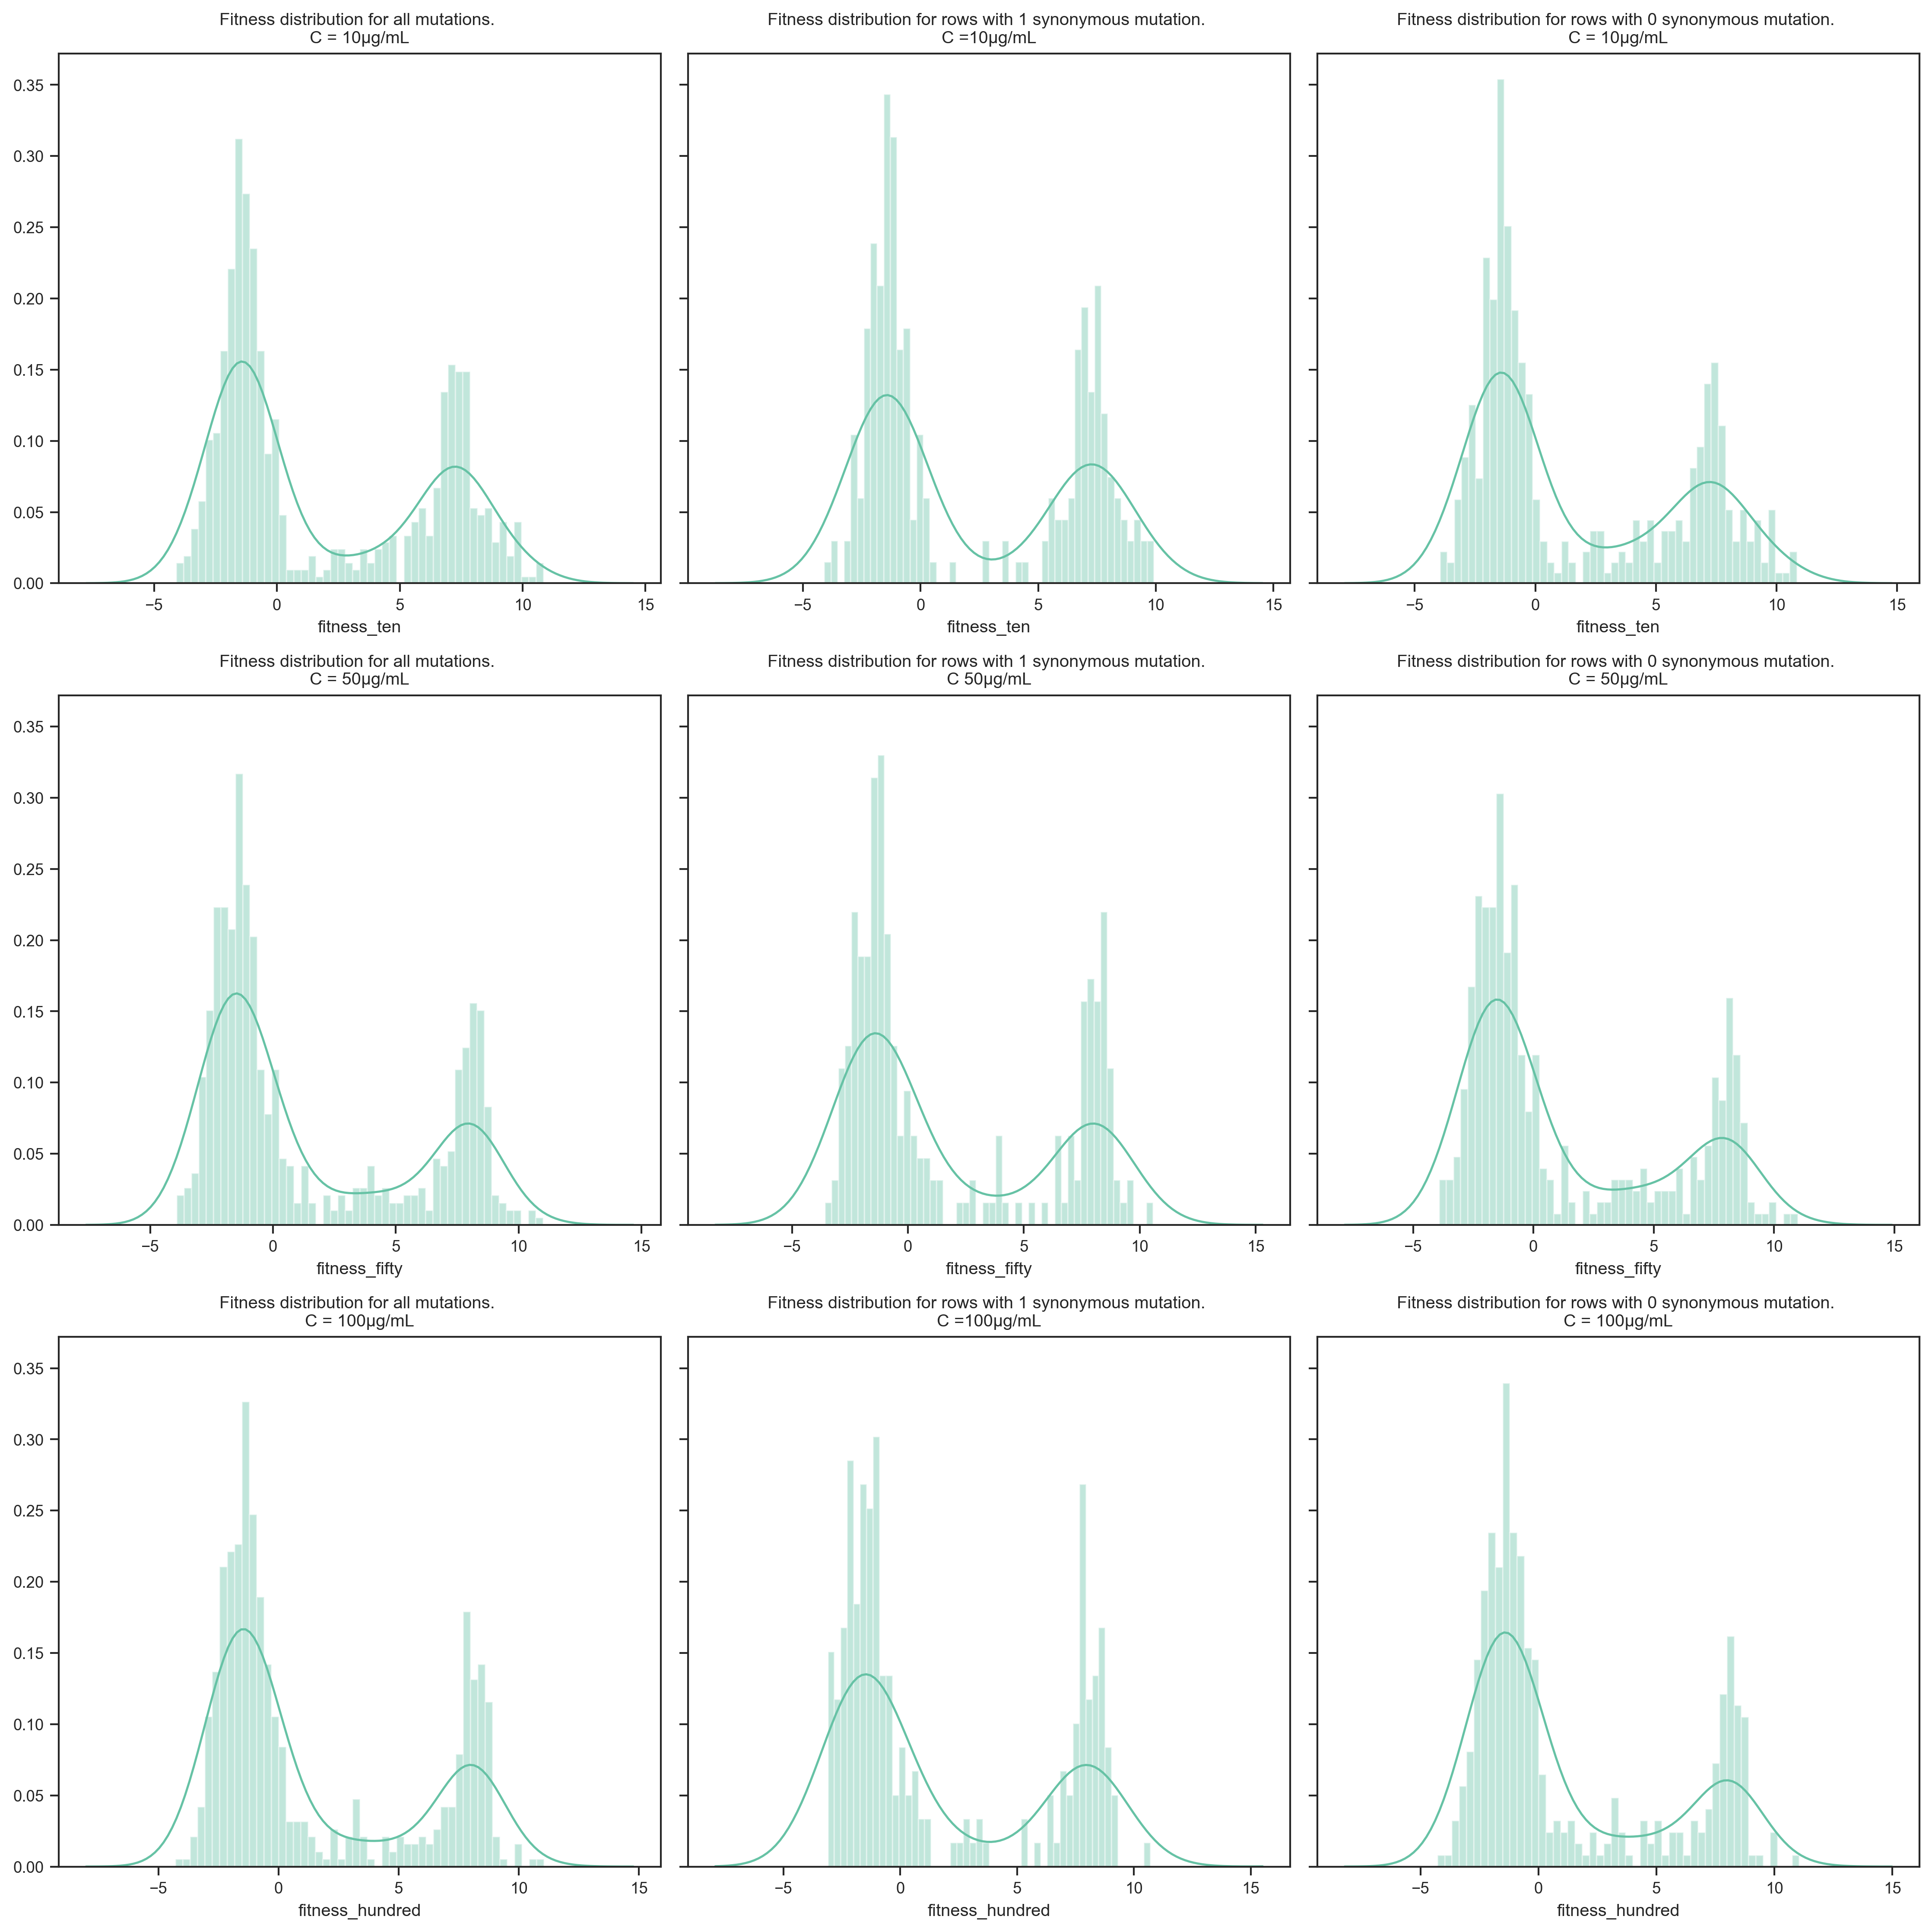

In [85]:
'''
We can plot the fitness distribution for all concentrations by dividing into 3 categories: all 
mutations, rows containing 0 synynymous mutation and rows containing 1 synonymous mutation. 
mutation
'''
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots(3, 3, figsize=(15, 15), sharey=True)

sns.distplot(df_Dataset_multiple.fitness_ten, bins=50, ax=ax[0, 0]).set_title(
    'Fitness distribution for all mutations. \nC = 10µg/mL')
sns.distplot(df_Dataset_multiple_syn.fitness_ten, bins=50, ax=ax[0, 1]).set_title(
    'Fitness distribution for rows with 1 synonymous mutation. \nC =10µg/mL')
sns.distplot(df_Dataset_multiple_non_syn.fitness_ten, bins=50, ax=ax[0, 2]).set_title(
    'Fitness distribution for rows with 0 synonymous mutation. \nC = 10µg/mL')

sns.distplot(df_Dataset_multiple.fitness_fifty, bins=50, ax=ax[1, 0]).set_title(
    'Fitness distribution for all mutations. \nC = 50µg/mL')
sns.distplot(df_Dataset_multiple_syn.fitness_fifty, bins=50, ax=ax[1, 1]).set_title(
    'Fitness distribution for rows with 1 synonymous mutation. \nC 50µg/mL')
sns.distplot(df_Dataset_multiple_non_syn.fitness_fifty, bins=50, ax=ax[1, 2]).set_title(
    'Fitness distribution for rows with 0 synonymous mutation. \nC = 50µg/mL')

sns.distplot(df_Dataset_multiple.fitness_hundred, bins=50, ax=ax[2, 0]).set_title(
    'Fitness distribution for all mutations. \nC = 100µg/mL')
sns.distplot(df_Dataset_multiple_syn.fitness_hundred, bins=50, ax=ax[2, 1]).set_title(
    'Fitness distribution for rows with 1 synonymous mutation. \nC =100µg/mL')
sns.distplot(df_Dataset_multiple_non_syn.fitness_hundred, bins=50, ax=ax[2, 2]).set_title(
    'Fitness distribution for rows with 0 synonymous mutation. \nC = 100µg/mL')

plt.tight_layout()
plt.show()

## Additional analysis

### Nucleobase changes

In [86]:
from itertools import combinations
L = ['A', 'C', 'G', 'T']
combinations_list = ["".join(map(str, comb)) for comb in combinations(L, 2)]
combinations_list

['AC', 'AG', 'AT', 'CG', 'CT', 'GT']

In [87]:
df_Dataset_multiple = df_Dataset_multiple.assign(
    Nucleobase=df_Dataset_multiple.Mutations.str.replace('C135G', ''))
df_Dataset_multiple.Nucleobase = df_Dataset_multiple.Nucleobase.replace(
    ',,', ',')
df_Dataset_multiple.Nucleobase = df_Dataset_multiple.Nucleobase.str.rstrip(
    to_strip=',')
df_Dataset_multiple.Nucleobase = df_Dataset_multiple.Nucleobase.str.lstrip(
    to_strip=',')
df_Dataset_multiple.Nucleobase = df_Dataset_multiple.Nucleobase.str.replace(
    '\d+', '')


list_of_changes = ['AC', 'CA', 'AG', 'GA', 'AT', 'TA', 'CG', 'GC', 'CT', 'TC', 'GT', 'TG']
list_nb_changes = []

for i in range(len(list_of_changes)) : 
    list_nb_changes.append(df_Dataset_multiple.Nucleobase.str.count(list_of_changes[i]).sum())

d = {'Change': list_of_changes, 'Nb_change': list_nb_changes}
df_nucleobase = pd.DataFrame(data=d)
df_nucleobase

Change  Nb_change
0      AC       13.0
1      CA      143.0
2      AG       69.0
3      GA      121.0
4      AT      272.0
5      TA      141.0
6      CG       56.0
7      GC       32.0
8      CT      224.0
9      TC       82.0
10     GT       57.0
11     TG       18.0

In [88]:
df_nucleobase = df_nucleobase.assign(
    Frequency=df_nucleobase['Nb_change']/df_nucleobase.Nb_change.sum())

df_nucleobase

Change  Nb_change  Frequency
0      AC       13.0   0.010586
1      CA      143.0   0.116450
2      AG       69.0   0.056189
3      GA      121.0   0.098534
4      AT      272.0   0.221498
5      TA      141.0   0.114821
6      CG       56.0   0.045603
7      GC       32.0   0.026059
8      CT      224.0   0.182410
9      TC       82.0   0.066775
10     GT       57.0   0.046417
11     TG       18.0   0.014658

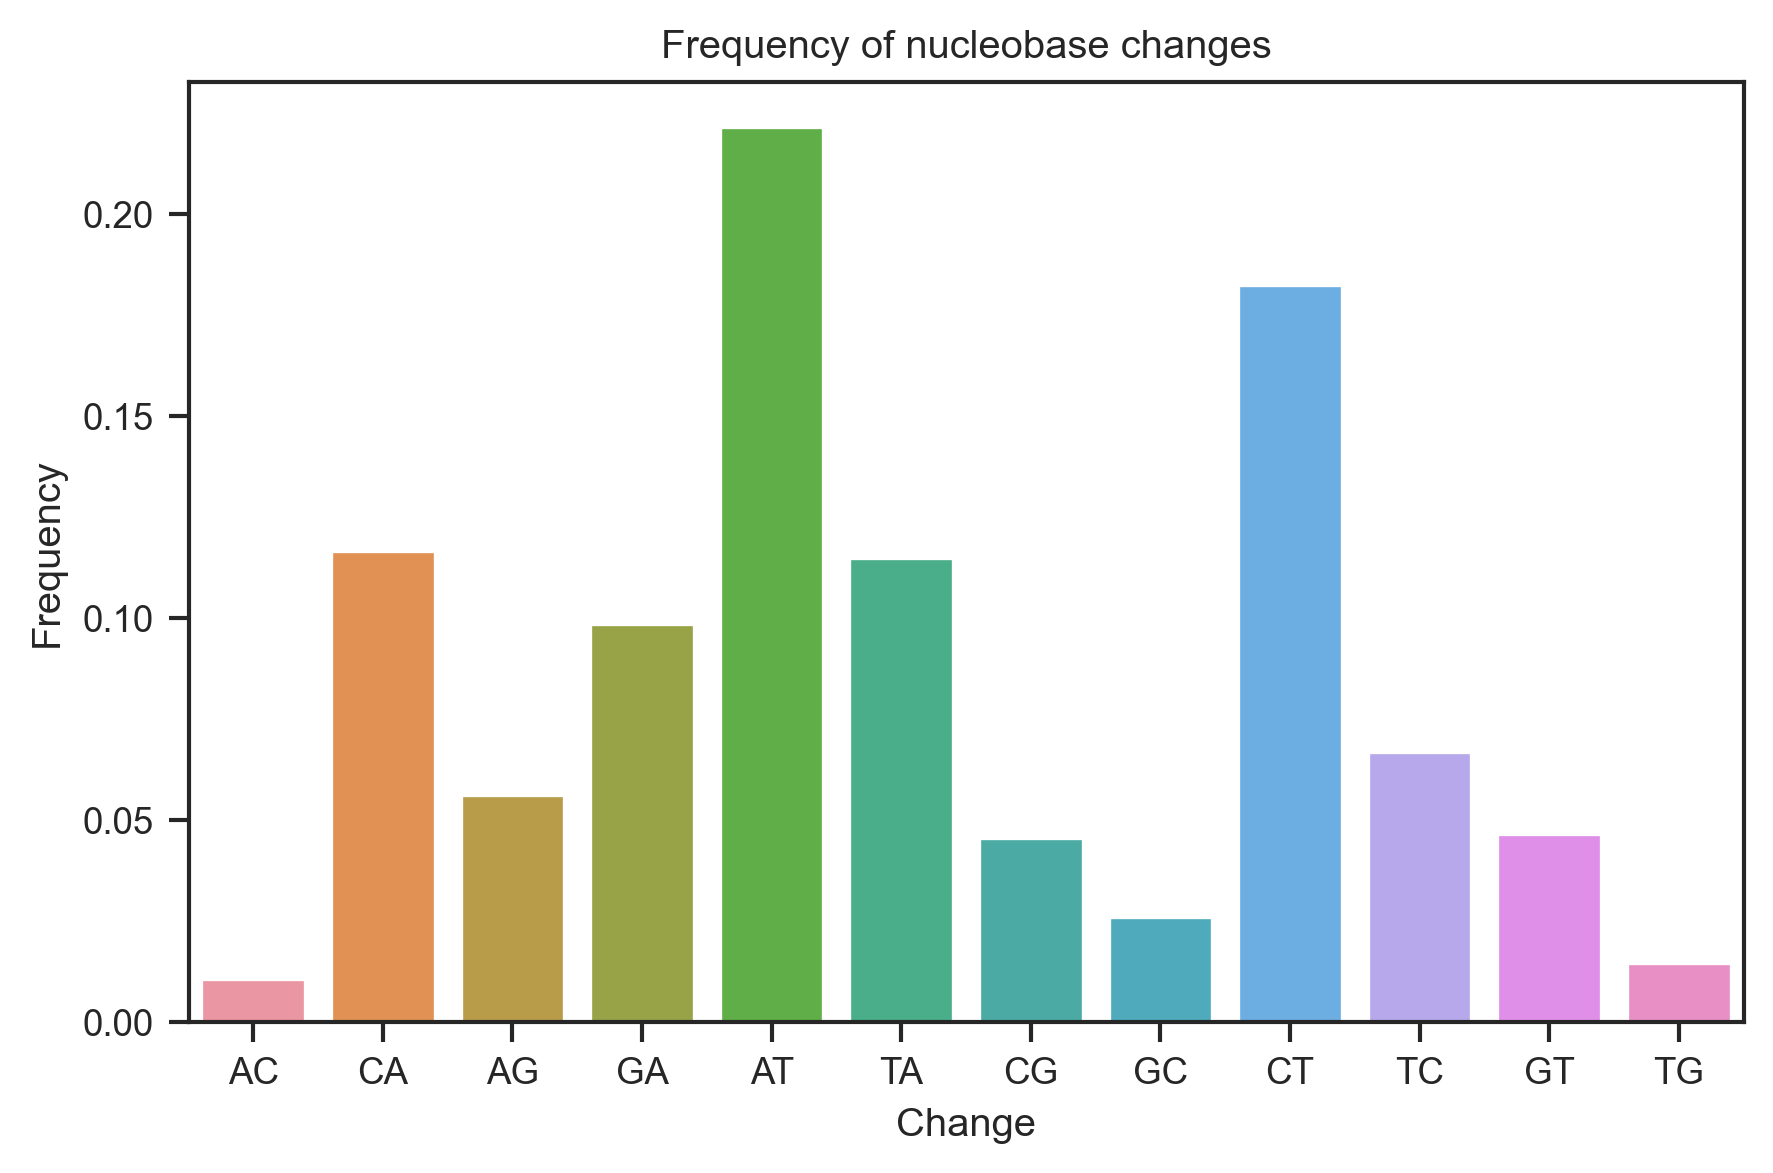

In [89]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

sns.barplot(x=df_nucleobase.Change, y=df_nucleobase.Frequency, )
plt.title('Frequency of nucleobase changes')
plt.tight_layout()


### Position frequency

In [90]:
'''

'''
df_Dataset_multiple = df_Dataset_multiple.assign(
    Positions_of_mutations=df_Dataset_multiple.Mutations.str.replace('C135G', ''))
df_Dataset_multiple.Positions_of_mutations = df_Dataset_multiple.Positions_of_mutations.replace(
    ',,', ',')
df_Dataset_multiple.Positions_of_mutations = df_Dataset_multiple.Positions_of_mutations.str.rstrip(
    to_strip=',')
df_Dataset_multiple.Positions_of_mutations = df_Dataset_multiple.Positions_of_mutations.str.lstrip(
    to_strip=',')
df_Dataset_multiple.Positions_of_mutations = df_Dataset_multiple.Positions_of_mutations.str.replace(
    'A', '').str.replace(
    'T', '').str.replace(
    'G', '').str.replace(
    'C', '')


In [91]:
'''

'''
df_positions_mutations = df_Dataset_multiple[['Mutations_Position','Positions_of_mutations']].copy()

df_positions_mutations[['Position1', 'Position2', 'Position3', 'Position4', 'Position5']
                       ] = df_positions_mutations.Positions_of_mutations.str.split(',', expand=True)

'''

'''
p1_unique = df_positions_mutations.Position1.unique()
p2_unique = df_positions_mutations.Position2.unique()
p3_unique = df_positions_mutations.Position3.unique()
p4_unique = df_positions_mutations.Position4.unique()
p5_unique = df_positions_mutations.Position5.unique()

'''

'''
p_unique = set(np.concatenate([p1_unique, p2_unique, p3_unique, p4_unique, p5_unique]).tolist())

df_positions_mutations_concat = pd.concat([df_positions_mutations.Position1,
                                          df_positions_mutations.Position2,
                                          df_positions_mutations.Position3,
                                          df_positions_mutations.Position4, 
                                          df_positions_mutations.Position5], ignore_index=True)

'''

'''
df_positions_mutations_counts = df_positions_mutations_concat.value_counts().rename_axis(
    'unique_position').reset_index(name='position_count')
df_positions_mutations_counts['unique_position'] = pd.to_numeric(
    df_positions_mutations_counts['unique_position'])
df_positions_mutations_counts = df_positions_mutations_counts.sort_values(
    by='unique_position').reset_index(drop=True)
df_positions_mutations_counts

unique_position  position_count
0                0.0               5
1                3.0               2
2                4.0               2
3                5.0               2
4                6.0               2
..               ...             ...
228            262.0               1
229            264.0               2
230            268.0               4
231            269.0               4
232              NaN              39

[233 rows x 2 columns]

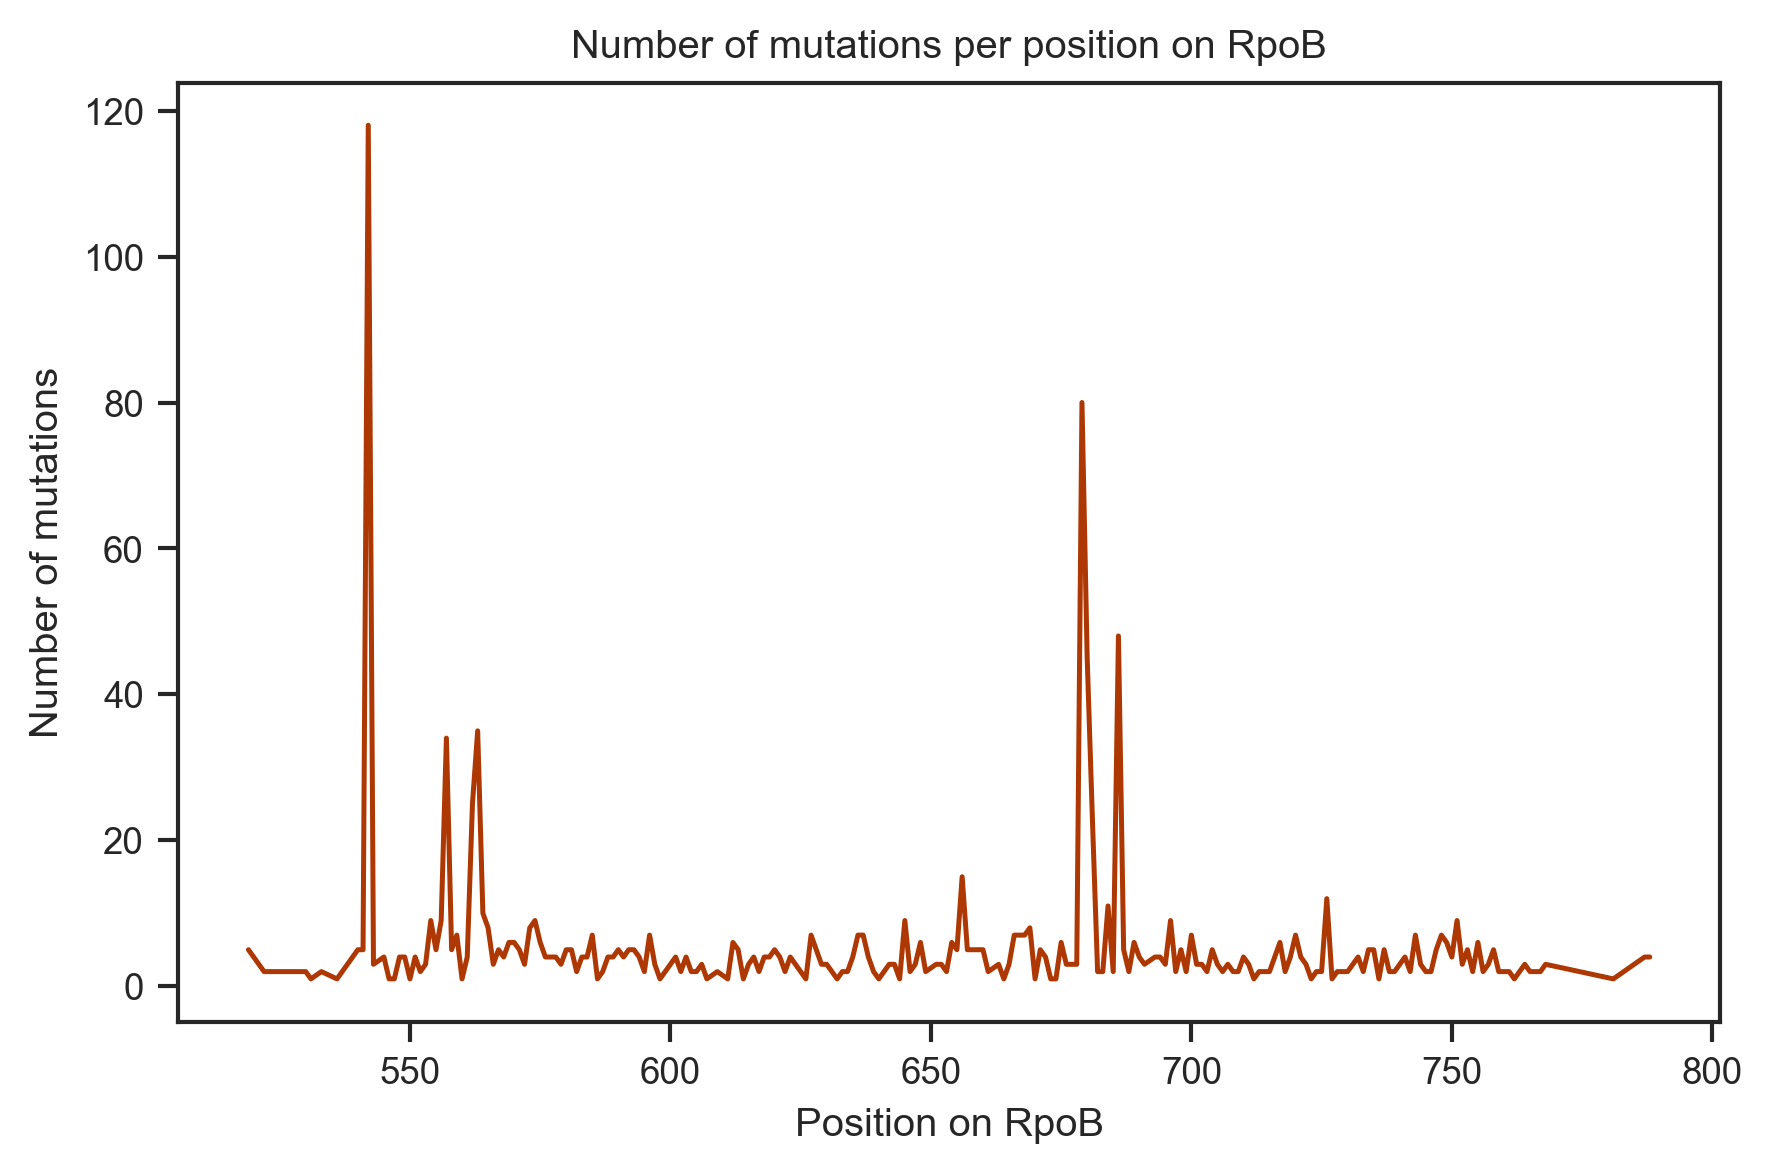

In [92]:
'''

'''
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Oranges_r')


ax = sns.lineplot(x=519+df_positions_mutations_counts.unique_position,
    y=df_positions_mutations_counts.position_count)
plt.xlabel('Position on RpoB')
plt.ylabel('Number of mutations')
plt.title('Number of mutations per position on RpoB')
plt.tight_layout()
plt.show()

# Relationship between fitness and distance two mutations

## Data pre-processing

In [93]:
# Create df_2mutations
condition = (df_Dataset_multiple.Unique_Mutations.str.len()
             == 11) & (df_Dataset_multiple.Nb_Syn == 0)
df_2mutations = df_Dataset_multiple.loc[condition]
df_2mutations = df_2mutations.drop(
    ['Nucleobase', 'Positions_of_mutations', 'Mutations_Position', 'Nb_Syn'], axis=1)

# 
df_2mutations['Mutation1'] = df_2mutations.Unique_Mutations.str[:5]
df_2mutations['Mutation2'] = df_2mutations.Unique_Mutations.str[-5:]

df_2mutations.head()

Mutations          aa_change  No_Mutations   pre     ten  \
0  T161A,A23T,A160T,C135G  H526L,I572Y,T563T             3   5.0  2652.0   
2  T161A,C38T,A160T,C135G  S531F,I572Y,T563T             3   1.0   190.0   
3  C38A,T161A,A160T,C135G  S531Y,I572Y,T563T             3   1.0   200.0   
4        A23T,A160T,C135G  H526L,I572F,T563T             3  13.0  3101.0   
5        A23T,C137T,C135G  H526L,P564L,T563T             3   1.0   527.0   

    fifty  hundred  fitness_ten  fitness_fifty  fitness_hundred  \
0  5604.0   5417.0     9.704388      10.980258        11.050955   
2   361.0    416.0     8.677781       9.847338        10.093781   
3   320.0    362.0     8.729074       9.726781         9.954740   
4  5209.0   4442.0     8.905288       9.951654         9.897007   
5   769.0    226.0     9.697958      10.603551         9.483631   

  Unique_Mutations Mutation1 Mutation2  
0      H526L,I572Y     H526L     I572Y  
2      S531F,I572Y     S531F     I572Y  
3      S531Y,I572Y     S531Y     I572Y  
4      H526L,I572F     H526L     I572F  
5      H526L,P564L     H526L     P564L

In [94]:
# Create df_1mutation
condition = (df_Dataset_multiple.Unique_Mutations.str.len()
             == 5) & (df_Dataset_multiple.Nb_Syn == 0)
df_1mutation = df_Dataset_multiple.loc[condition]
df_1mutation = df_1mutation.drop(
    ['Nucleobase', 'Positions_of_mutations', 'Mutations_Position', 'Nb_Syn'], axis=1)

df_1mutation.head()

Mutations    aa_change  No_Mutations     pre       ten     fifty  \
8           A23T,C135G  H526L,T563T             2     1.0     115.0     157.0   
84   T161A,A160T,C135G  I572Y,T563T             2   860.0   41741.0   58883.0   
85     T37A,C38A,C135G  S531N,T563T             2   164.0    6078.0   10016.0   
105         A23T,C135G  H526L,T563T             2  4642.0  215334.0  325216.0   
209         A23T,C135G  H526L,T563T             2     3.0     116.0     156.0   

      hundred  fitness_ten  fitness_fifty  fitness_hundred Unique_Mutations  
8       161.0     8.175689       9.014706         9.144500            H526L  
84    61661.0     7.313064       8.184836         8.335570            I572Y  
85    11716.0     7.043322       8.070533         8.331940            S531N  
105  297314.0     7.267802       8.207805         8.222739            H526L  
209     127.0     7.085735       7.909704         7.808671            H526L

## Study of 5UAQ Escherichia coli RNA polymerase RpoB

### Downloading the structure file from the PDB database

We're gonna use the 5UAQ Escherichia coli RNA polymerase RpoB. (https://www.rcsb.org/structure/5UAQ) as our reference for the position of amino acids.

In [95]:
'''
It creats a folder containing "5UAQ.cif"
'''

pdbl = PDBList()
pdbl.retrieve_pdb_file('5UAQ')

Structure exists: 'C:\Users\Pablo\Test\ua\5uaq.cif' 


'C:\\Users\\Pablo\\Test\\ua\\5uaq.cif'

In [96]:
'''
We create the parser
'''
parser = MMCIFParser()
structure = parser.get_structure('5UAQ', 'ua/5uaq.cif')


def cleandir(obj):
    print(", ".join([a for a in dir(obj) if not a.startswith("_")]))


cleandir(structure)

add, atom_to_internal_coordinates, child_dict, child_list, copy, detach_child, detach_parent, full_id, get_atoms, get_chains, get_full_id, get_id, get_iterator, get_level, get_list, get_models, get_parent, get_residues, has_id, header, id, insert, internal_to_atom_coordinates, level, parent, set_parent, transform, xtra


C:\Users\Pablo\anaconda3\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:


C:\Users\Pablo\anaconda3\lib\site-packages\Bio\PDB\StructureBuilder.py:89: PDBConstructionWarning:




### Visualizing the structure

#### Balls and sticks visualization

In [97]:
'''
Balls and sticks visualization, using nglview
'''
view_ball_stick = nv.show_biopython(structure)
view_ball_stick.clear_representations()
view_ball_stick.add_ball_and_stick()
view_ball_stick

NGLWidget()

#### Ribbon visualization

In [98]:
'''

'''
view_ribbon = nv.show_biopython(structure)
view_ribbon.clear_representations()
view_ribbon.add_cartoon('protein')
view_ribbon.add_ball_and_stick('not protein')
view_ribbon

NGLWidget()

### Parsing structure file

Structure objects are organized in a specific hierarchy of objects.


![Random Unsplash Image](http://biopython.org/wiki/Smcra.png)


We're just going to focus on the core elements which are: Model --> Chain --> Residue --> Atom.

Each structure file can contain multiple "models" of the same molecule.

Each model contains several "chains" or strands of protein/RNA/DNA/.

Each "chain" is made up of residues, or amino acids/DNA bases/RNA bases.

Each residue is made up of Atoms.


#### Models

In [99]:
'''
Enumerate the different models in the structure.
'''

for model in structure:
    print(f"model {model}")

model <Model id=0>


There is only 1 model in this structure.

#### Chains

In [100]:
'''
Enumerate the different chains in the structure.
'''

model = structure[0] #since we only have one model
for chain in model:
    print(f"chain {chain}, Chain ID: {chain.id}")

chain <Chain id=A>, Chain ID: A
chain <Chain id=B>, Chain ID: B
chain <Chain id=C>, Chain ID: C
chain <Chain id=D>, Chain ID: D
chain <Chain id=E>, Chain ID: E
chain <Chain id=F>, Chain ID: F
chain <Chain id=G>, Chain ID: G
chain <Chain id=H>, Chain ID: H
chain <Chain id=I>, Chain ID: I
chain <Chain id=J>, Chain ID: J
chain <Chain id=K>, Chain ID: K
chain <Chain id=L>, Chain ID: L


There is 12 chains in this structure, chain C is the one corresponding to rpoB. We can go one step further and get all the residues in a chain.

We can access individual chains like keys in a dictionary from a model.

#### Residues

In [101]:
'''
Enumerate all the residues in chain C.
'''

chain_C = model['C']
for res in chain_C:
    print(f'rResidue name: {res.resname}, number: {res.id[1]}')

rResidue name: TYR, number: 3
rResidue name: SER, number: 4
rResidue name: TYR, number: 5
rResidue name: THR, number: 6
rResidue name: GLU, number: 7
rResidue name: LYS, number: 8
rResidue name: LYS, number: 9
rResidue name: ARG, number: 10
rResidue name: ILE, number: 11
rResidue name: ARG, number: 12
rResidue name: LYS, number: 13
rResidue name: ASP, number: 14
rResidue name: PHE, number: 15
rResidue name: GLY, number: 16
rResidue name: LYS, number: 17
rResidue name: ARG, number: 18
rResidue name: PRO, number: 19
rResidue name: GLN, number: 20
rResidue name: VAL, number: 21
rResidue name: LEU, number: 22
rResidue name: ASP, number: 23
rResidue name: VAL, number: 24
rResidue name: PRO, number: 25
rResidue name: TYR, number: 26
rResidue name: LEU, number: 27
rResidue name: LEU, number: 28
rResidue name: SER, number: 29
rResidue name: ILE, number: 30
rResidue name: GLN, number: 31
rResidue name: LEU, number: 32
rResidue name: ASP, number: 33
rResidue name: SER, number: 34
rResidue name: 

Now we see that each chain is made up of Residue objects.

Finally, each residue should be made up of atoms. We will use the alpha carbon (CA) as a reference for the position of each amino acid.

#### Atoms

In [102]:
structure[0]['C'][24]['CA']

<Atom CA>

## Data editing and filtering

### Coordinates of alpha carbons (CA) and position of the residues

In [103]:
'''
The syntax to obtain the coordinates of an atom is the following, we obtain an array containing the 3
coordinates x, y and z. 
'''

structure[0]['C'][24]['CA'].get_coord()

array([-132.268,   23.053,   -7.607], dtype=float32)

In [104]:
'''
We initialize 3 lists that will contain the coordinates, the position and the name of the residue. 
Afterwards, we will integrate these lists in a dataframe.
'''

ca_position = []
res_name = []
res_position = []
i = 3

while i < len(structure[0]['C']) + 3:
    ca_position.append(structure[0]['C'][i]['CA'].get_coord())
    res_position.append(i)
    res_name.append(structure[0]['C'][i].get_resname())
    i = i + 1

In [105]:
'''
We create the dataframe 'df' containing the coordinates, positions and names of the residues. 
The names of the residues are given with 3 letters (while it was with 1 letter in the practical), 
so we convert to a 1 letter name. Dataframe 'df' contains ALL the residues of the C, we will need to 
filter it later. 
'''

df = pd.DataFrame(data=ca_position, columns=['x', 'y', 'z'])
df['AA'] = res_name
df['Position'] = res_position
df['Position'] = df['Position'].astype(int)
df['AA_short'] = df.AA.str.replace(
    'ALA', 'A').str.replace(
    'ARG', 'R').str.replace(
    'ASN', 'N').str.replace(
    'ASP', 'D').str.replace(
    'CYS', 'C').str.replace(
    'GLU', 'E').str.replace(
    'GLN', 'Q').str.replace(
    'GLY', 'G').str.replace(
    'HIS', 'H').str.replace(
    'ILE', 'I').str.replace(
    'LEU', 'L').str.replace(
    'LYS', 'K').str.replace(
    'MET', 'M').str.replace(
    'PHE', 'F').str.replace(
    'PRO', 'P').str.replace(
    'SER', 'S').str.replace(
    'THR', 'T').str.replace(
    'TRP', 'W').str.replace(
    'TYR', 'Y').str.replace(
    'VAL', 'V')

df['AA_position'] = df['AA_short'] + df['Position'].astype(str)
df = df[['AA', 'AA_short', 'Position',  'AA_position', 'x', 'y', 'z']]

df

AA AA_short  Position AA_position           x          y          z
0     TYR        Y         3          Y3 -135.320999  25.049999 -24.725000
1     SER        S         4          S4 -133.647003  28.445000 -23.969999
2     TYR        Y         5          Y5 -131.201996  30.702000 -25.771999
3     THR        T         6          T6 -127.931000  29.749001 -24.219000
4     GLU        E         7          E7 -129.222000  26.233999 -24.652000
...   ...      ...       ...         ...         ...        ...        ...
1335  GLU        E      1338       E1338  -73.667000  31.412001  37.729000
1336  LEU        L      1339       L1339  -71.348999  29.792000  35.160000
1337  GLU        E      1340       E1340  -68.635002  27.889999  36.995998
1338  ASP        D      1341       D1341  -65.032997  26.738001  36.541000
1339  GLU        E      1342       E1342  -63.112000  26.660999  33.279999

[1340 rows x 7 columns]

### Loading previous dataset

In [106]:
'''
We load the dataset 1 mutation created previously. 
'''

# df_1mutation = pd.read_csv('dataset_1mutation.csv', index_col=0)
df_1mutation = df_1mutation.reset_index(drop=True)

df_1mutation.head()

Mutations    aa_change  No_Mutations     pre       ten     fifty  \
0         A23T,C135G  H526L,T563T             2     1.0     115.0     157.0   
1  T161A,A160T,C135G  I572Y,T563T             2   860.0   41741.0   58883.0   
2    T37A,C38A,C135G  S531N,T563T             2   164.0    6078.0   10016.0   
3         A23T,C135G  H526L,T563T             2  4642.0  215334.0  325216.0   
4         A23T,C135G  H526L,T563T             2     3.0     116.0     156.0   

    hundred  fitness_ten  fitness_fifty  fitness_hundred Unique_Mutations  
0     161.0     8.175689       9.014706         9.144500            H526L  
1   61661.0     7.313064       8.184836         8.335570            I572Y  
2   11716.0     7.043322       8.070533         8.331940            S531N  
3  297314.0     7.267802       8.207805         8.222739            H526L  
4     127.0     7.085735       7.909704         7.808671            H526L

In [107]:
'''
We load the dataset 2 mutations created previously. 
'''

# df_2mutations = pd.read_csv('dataset_2mutations.csv', index_col=0)
df_2mutations = df_2mutations.reset_index(drop=True)
df_2mutations['Position1'] = df_2mutations['Mutation1'].str.extract(
    '(\d+)').astype(int)
df_2mutations['Position2'] = df_2mutations['Mutation2'].str.extract(
    '(\d+)').astype(int)
df_2mutations.reset_index(drop=True)

df_2mutations.head()

Mutations          aa_change  No_Mutations   pre     ten  \
0  T161A,A23T,A160T,C135G  H526L,I572Y,T563T             3   5.0  2652.0   
1  T161A,C38T,A160T,C135G  S531F,I572Y,T563T             3   1.0   190.0   
2  C38A,T161A,A160T,C135G  S531Y,I572Y,T563T             3   1.0   200.0   
3        A23T,A160T,C135G  H526L,I572F,T563T             3  13.0  3101.0   
4        A23T,C137T,C135G  H526L,P564L,T563T             3   1.0   527.0   

    fifty  hundred  fitness_ten  fitness_fifty  fitness_hundred  \
0  5604.0   5417.0     9.704388      10.980258        11.050955   
1   361.0    416.0     8.677781       9.847338        10.093781   
2   320.0    362.0     8.729074       9.726781         9.954740   
3  5209.0   4442.0     8.905288       9.951654         9.897007   
4   769.0    226.0     9.697958      10.603551         9.483631   

  Unique_Mutations Mutation1 Mutation2  Position1  Position2  
0      H526L,I572Y     H526L     I572Y        526        572  
1      S531F,I572Y     S531F     I572Y        531        572  
2      S531Y,I572Y     S531Y     I572Y        531        572  
3      H526L,I572F     H526L     I572F        526        572  
4      H526L,P564L     H526L     P564L        526        564

### Filtering

#### Filtering of the positions present among the mutations

In [108]:
'''
We notice that the AAs at a given position are not necessarily those at the same position in the 
dataset of the practical, but we suppose that the position of the C alpha does not depend on the AA, 
so it does not matter.  

We create 'df_position' by filtering 'df' with only the residues present in 'd_2mutations'
'''

df_position = df.loc[df.Position.isin(
    df_2mutations.Position1) | df.Position.isin(df_2mutations.Position2)]
df_position.reset_index(drop=True)

df_position

AA AA_short  Position AA_position           x          y       z
515  ASN        N       518        N518 -111.627998  33.308998  -6.569
517  PRO        P       520        P520 -117.306999  30.122000  -8.305
519  SER        S       522        S522 -115.217003  28.038000  -3.750
520  GLU        E       523        E523 -117.365997  31.087000  -3.142
522  THR        T       525        T525 -119.337997  26.406000  -1.396
..   ...      ...       ...         ...         ...        ...     ...
595  VAL        V       598        V598 -149.378998   6.368000  -6.505
596  VAL        V       599        V599 -146.320999   8.610000  -6.308
597  THR        T       600        T600 -147.619003  12.133000  -6.055
603  LEU        L       606        L606 -139.858002  17.132999   6.429
605  ALA        A       608        A608 -135.371994  15.344000  11.013

[61 rows x 7 columns]

In [109]:
'''
We now add to df_2mutations the coordinates (x, y, z) that correspond to each residue position. 
We then calculate the distance (Å) between the two mutations. 
'''

df_2mutations['x1'] = df_2mutations['Position1'].map(
    df_position.set_index('Position')['x'])
df_2mutations['x2'] = df_2mutations['Position2'].map(
    df_position.set_index('Position')['x'])

df_2mutations['y1'] = df_2mutations['Position1'].map(
    df_position.set_index('Position')['y'])
df_2mutations['y2'] = df_2mutations['Position2'].map(
    df_position.set_index('Position')['y'])

df_2mutations['z1'] = df_2mutations['Position1'].map(
    df_position.set_index('Position')['y'])
df_2mutations['z2'] = df_2mutations['Position2'].map(
    df_position.set_index('Position')['y'])

df_2mutations['distance'] = np.sqrt(
    ((df_2mutations['x2'] - df_2mutations['x1'])**2) +
    ((df_2mutations['y2'] - df_2mutations['y1'])**2))


#### Duplicate filtering

In [110]:
'''
We can see that in df_1mutation, some mutations appear several times. We only want one line per 
mutation, so we will manually select the duplicates to be  to delete (those which have the weakest 
values). For this, we used the qgrid package to be able to navigate quickly in the dataframe.

See qgrid's documentation : https://github.com/quantopian/qgrid

Code:
import qgrid
qgrid_widget = qgrid.show_grid(df_1mutation, show_toolbar=True)
qgrid_widget
'''

df_1mutation.aa_change.value_counts().loc[df_1mutation.aa_change.value_counts() > 1]

H526L,T563T    7
E565D,T563T    2
L533F,T563T    2
H526Q,T563T    2
V558L,T563T    2
H554Q,T563T    2
T553S,T563T    2
V577L,T563T    2
K593N,T563T    2
F545L,T563T    2
T539S,T563T    2
E546D,T563T    2
Name: aa_change, dtype: int64

In [111]:
'''
The rows to be deleted are  : 

H526L,T563T : 0, 4, 6, 11, 322, 323
F545L,T563T : 154
H554Q,T563T : 312
L533F,T563T : 319
V558L,T563T : 81
T539S,T563T : 248
E565D,T563T : 307
H526Q,T563T : 321
K593N,T563T : 294
T553S,T563T : 165
V577L,T563T : 304
E546D,T563T : 314
'''

df_1mutation = df_1mutation.drop(
    [0,4, 6, 11, 322, 323, 154, 312, 319, 81, 248, 307, 321, 294, 165, 304, 314])
df_1mutation.reset_index(drop=True)

Mutations    aa_change  No_Mutations     pre       ten     fifty  \
0    T161A,A160T,C135G  I572Y,T563T             2   860.0   41741.0   58883.0   
1      T37A,C38A,C135G  S531N,T563T             2   164.0    6078.0   10016.0   
2           A23T,C135G  H526L,T563T             2  4642.0  215334.0  325216.0   
3           C135A,A26T  T563T,K527I             2     2.0      68.0     132.0   
4           C38A,C135G  S531Y,T563T             2   572.0   15270.0   18944.0   
..                 ...          ...           ...     ...       ...       ...   
302         G76A,C135G  G544S,T563T             2  1176.0       9.0       3.0   
303         C74G,C135G  A543G,T563T             2   576.0       NaN       2.0   
304         C70G,C135G  R542G,T563T             2   469.0       3.0       3.0   
305         G46C,C135G  G534R,T563T             2   193.0      89.0       NaN   
306         T37G,C135G  S531A,T563T             2   185.0     131.0       NaN   

      hundred  fitness_ten  fitness_fifty  fitness_hundred Unique_Mutations  
0     61661.0     7.313064       8.184836         8.335570            I572Y  
1     11716.0     7.043322       8.070533         8.331940            S531N  
2    297314.0     7.267802       8.207805         8.222739            H526L  
3        83.0     6.957118       8.148115         7.788789            K527I  
4     22537.0     6.715263       7.458564         7.736871            S531Y  
..        ...          ...            ...              ...              ...  
302       NaN    -1.441893      -2.012802              NaN            G544S  
303       NaN          NaN      -1.704500              NaN            A543G  
304       NaN    -1.621233      -1.093530              NaN            R542G  
305       NaN     2.656703            NaN              NaN            G534R  
306       NaN     3.085599            NaN              NaN            S531A  

[307 rows x 11 columns]

In [112]:
'''
We can see that there are no more duplicates in the 'aa_change' column. 
'''

df_1mutation.aa_change.value_counts().loc[df_1mutation.aa_change.value_counts() > 1]

Series([], Name: aa_change, dtype: int64)

In [113]:
'''
There are still duplicates in the 'Unique_Mutations' column because we distinguished between 
[ABBBA, CDDDC] and [CDDDC, ABBBA] in the 'aa_change' column. So there may be duplicates left,
which are also deleted by analyzing the dataframe with qgrid. 
'''

df_1mutation.Unique_Mutations.value_counts().loc[df_1mutation.Unique_Mutations.value_counts() > 1]

D596E    2
N582K    2
I572F    2
T595S    2
T581S    2
T589S    2
H526L    2
N573K    2
K527I    2
Name: Unique_Mutations, dtype: int64

In [114]:
'''
The rows to be deleted are  : 

K527I : 5
T589S : 299
H526L : 9    
I572F : 8
N582K : 255
D596E : 244
T595S : 293
T581S : 264
N573K : 272
'''

df_1mutation = df_1mutation.drop(
    [5, 299, 9, 8, 255, 244, 293, 264, 272])
df_1mutation.reset_index(drop=True)

Mutations    aa_change  No_Mutations     pre       ten     fifty  \
0    T161A,A160T,C135G  I572Y,T563T             2   860.0   41741.0   58883.0   
1      T37A,C38A,C135G  S531N,T563T             2   164.0    6078.0   10016.0   
2           A23T,C135G  H526L,T563T             2  4642.0  215334.0  325216.0   
3           C38A,C135G  S531Y,T563T             2   572.0   15270.0   18944.0   
4           C38T,C135G  S531F,T563T             2   806.0   14179.0   20197.0   
..                 ...          ...           ...     ...       ...       ...   
293         G76A,C135G  G544S,T563T             2  1176.0       9.0       3.0   
294         C74G,C135G  A543G,T563T             2   576.0       NaN       2.0   
295         C70G,C135G  R542G,T563T             2   469.0       3.0       3.0   
296         G46C,C135G  G534R,T563T             2   193.0      89.0       NaN   
297         T37G,C135G  S531A,T563T             2   185.0     131.0       NaN   

      hundred  fitness_ten  fitness_fifty  fitness_hundred Unique_Mutations  
0     61661.0     7.313064       8.184836         8.335570            I572Y  
1     11716.0     7.043322       8.070533         8.331940            S531N  
2    297314.0     7.267802       8.207805         8.222739            H526L  
3     22537.0     6.715263       7.458564         7.736871            S531Y  
4     23185.0     6.298191       7.179666         7.422273            S531F  
..        ...          ...            ...              ...              ...  
293       NaN    -1.441893      -2.012802              NaN            G544S  
294       NaN          NaN      -1.704500              NaN            A543G  
295       NaN    -1.621233      -1.093530              NaN            R542G  
296       NaN     2.656703            NaN              NaN            G534R  
297       NaN     3.085599            NaN              NaN            S531A  

[298 rows x 11 columns]

In [115]:
'''
We can see that there are no more duplicates in the 'Unique_Mutations' column. 
'''

df_1mutation.Unique_Mutations.value_counts().loc[df_1mutation.Unique_Mutations.value_counts() > 1]

Series([], Name: Unique_Mutations, dtype: int64)

### Fitness

#### Mutation fitness (one mutation)

In [116]:
'''
We find the fitness of each mutation in 'df_1mutation' and send it to 'df_2mutations'.
This is done for the three concentrations
'''

df_2mutations['fitness_1_ten'] = df_2mutations['Mutation1'].map(
    df_1mutation.set_index('Unique_Mutations')['fitness_ten'])
df_2mutations['fitness_2_ten'] = df_2mutations['Mutation2'].map(
    df_1mutation.set_index('Unique_Mutations')['fitness_ten'])

df_2mutations['fitness_1_fifty'] = df_2mutations['Mutation1'].map(
    df_1mutation.set_index('Unique_Mutations')['fitness_fifty'])
df_2mutations['fitness_2_fifty'] = df_2mutations['Mutation2'].map(
    df_1mutation.set_index('Unique_Mutations')['fitness_fifty'])

df_2mutations['fitness_1_hundred'] = df_2mutations['Mutation1'].map(
    df_1mutation.set_index('Unique_Mutations')['fitness_hundred'])
df_2mutations['fitness_2_hundred'] = df_2mutations['Mutation2'].map(
    df_1mutation.set_index('Unique_Mutations')['fitness_hundred'])

df_2mutations

Mutations          aa_change  No_Mutations   pre     ten  \
0    T161A,A23T,A160T,C135G  H526L,I572Y,T563T             3   5.0  2652.0   
1    T161A,C38T,A160T,C135G  S531F,I572Y,T563T             3   1.0   190.0   
2    C38A,T161A,A160T,C135G  S531Y,I572Y,T563T             3   1.0   200.0   
3          A23T,A160T,C135G  H526L,I572F,T563T             3  13.0  3101.0   
4          A23T,C137T,C135G  H526L,P564L,T563T             3   1.0   527.0   
..                      ...                ...           ...   ...     ...   
133        T128A,A23T,C135G  I561N,H526L,T563T             3   NaN   186.0   
134         G55A,A23T,C135G  G537S,H526L,T563T             3   NaN    84.0   
135         A23T,C50T,C135G  H526L,P535L,T563T             3   NaN    81.0   
136         T44A,A23T,C135G  L533H,H526L,T563T             3   NaN   102.0   
137         A23T,G32T,C135G  H526L,R529L,T563T             3   NaN    65.0   

      fifty  hundred  fitness_ten  fitness_fifty  fitness_hundred  ...  \
0    5604.0   5417.0     9.704388      10.980258        11.050955  ...   
1     361.0    416.0     8.677781       9.847338        10.093781  ...   
2     320.0    362.0     8.729074       9.726781         9.954740  ...   
3    5209.0   4442.0     8.905288       9.951654         9.897007  ...   
4     769.0    226.0     9.697958      10.603551         9.483631  ...   
..      ...      ...          ...            ...              ...  ...   
133    35.0     22.0          NaN            NaN              NaN  ...   
134   105.0     99.0          NaN            NaN              NaN  ...   
135   112.0    131.0          NaN            NaN              NaN  ...   
136    30.0     35.0          NaN            NaN              NaN  ...   
137   103.0    124.0          NaN            NaN              NaN  ...   

            y2         z1         z2   distance  fitness_1_ten  fitness_2_ten  \
0    21.607000  28.643999  21.607000   7.043649       7.267802       7.313064   
1    21.607000  25.191000  21.607000   3.968886       6.298191       7.313064   
2    21.607000  25.191000  21.607000   3.968886       6.715263       7.313064   
3    21.607000  28.643999  21.607000   7.043649       7.267802       6.033231   
4    19.103001  28.643999  19.103001  11.120147       7.267802       5.771396   
..         ...        ...        ...        ...            ...            ...   
133  28.643999  13.469000  28.643999  15.184392       4.481493       7.267802   
134  28.643999  25.844000  28.643999   3.492214       0.732928       7.267802   
135  30.903999  28.643999  30.903999   2.392123       7.267802      -0.416501   
136  28.643999  25.816999  28.643999   2.999992       5.859097       7.267802   
137  26.172001  28.643999  26.172001   3.606473       7.267802            NaN   

     fitness_1_fifty  fitness_2_fifty  fitness_1_hundred  fitness_2_hundred  
0           8.207805         8.184836           8.222739           8.335570  
1           7.179666         8.184836           7.422273           8.335570  
2           7.458564         8.184836           7.736871           8.335570  
3           8.207805         6.689457           8.222739           6.814507  
4           8.207805         6.171201           8.222739           5.222378  
..               ...              ...                ...                ...  
133        -0.784731         8.207805          -1.884068           8.222739  
134        -1.718293         8.207805          -2.019123           8.222739  
135         8.207805        -1.886894           8.222739          -2.252262  
136         0.817923         8.207805          -0.641417           8.222739  
137         8.207805              NaN           8.222739                NaN  

[138 rows x 28 columns]

#### Mutation fitness (two mutations)

In [117]:
'''
We then create a new column containing the sum of the fitness of each of the two mutations. 
'''

df_2mutations['fitness_12_ten'] = df_2mutations['fitness_1_ten'] + \
    df_2mutations['fitness_2_ten']
df_2mutations['fitness_12_fifty'] = df_2mutations['fitness_1_fifty'] + \
    df_2mutations['fitness_2_fifty']
df_2mutations['fitness_12_hundred'] = df_2mutations['fitness_1_hundred'] + \
    df_2mutations['fitness_2_hundred']

#### Fitness difference and ratio

In [118]:
'''
For the sake of readability, we create a new dataframe containing only the columns that will be 
useful later.
'''

df_result = df_2mutations.filter([
    'fitness_ten', 
    'fitness_fifty', 
    'fitness_hundred',
    'Unique_Mutations',
    'Mutation1',
    'Mutation2',
    'distance',
    'fitness_1_ten',
    'fitness_2_ten',
    'fitness_1_fifty',
    'fitness_2_fifty',
    'fitness_1_hundred',
    'fitness_2_hundred',
    'fitness_12_ten',
    'fitness_12_fifty',
    'fitness_12_hundred'], axis=1)

df_result

fitness_ten  fitness_fifty  fitness_hundred Unique_Mutations Mutation1  \
0       9.704388      10.980258        11.050955      H526L,I572Y     H526L   
1       8.677781       9.847338        10.093781      S531F,I572Y     S531F   
2       8.729074       9.726781         9.954740      S531Y,I572Y     S531Y   
3       8.905288       9.951654         9.897007      H526L,I572F     H526L   
4       9.697958      10.603551         9.483631      H526L,P564L     H526L   
..           ...            ...              ...              ...       ...   
133          NaN            NaN              NaN      I561N,H526L     I561N   
134          NaN            NaN              NaN      G537S,H526L     G537S   
135          NaN            NaN              NaN      H526L,P535L     H526L   
136          NaN            NaN              NaN      L533H,H526L     L533H   
137          NaN            NaN              NaN      H526L,R529L     H526L   

    Mutation2   distance  fitness_1_ten  fitness_2_ten  fitness_1_fifty  \
0       I572Y   7.043649       7.267802       7.313064         8.207805   
1       I572Y   3.968886       6.298191       7.313064         7.179666   
2       I572Y   3.968886       6.715263       7.313064         7.458564   
3       I572F   7.043649       7.267802       6.033231         8.207805   
4       P564L  11.120147       7.267802       5.771396         8.207805   
..        ...        ...            ...            ...              ...   
133     H526L  15.184392       4.481493       7.267802        -0.784731   
134     H526L   3.492214       0.732928       7.267802        -1.718293   
135     P535L   2.392123       7.267802      -0.416501         8.207805   
136     H526L   2.999992       5.859097       7.267802         0.817923   
137     R529L   3.606473       7.267802            NaN         8.207805   

     fitness_2_fifty  fitness_1_hundred  fitness_2_hundred  fitness_12_ten  \
0           8.184836           8.222739           8.335570       14.580866   
1           8.184836           7.422273           8.335570       13.611254   
2           8.184836           7.736871           8.335570       14.028327   
3           6.689457           8.222739           6.814507       13.301033   
4           6.171201           8.222739           5.222378       13.039198   
..               ...                ...                ...             ...   
133         8.207805          -1.884068           8.222739       11.749295   
134         8.207805          -2.019123           8.222739        8.000730   
135        -1.886894           8.222739          -2.252262        6.851301   
136         8.207805          -0.641417           8.222739       13.126899   
137              NaN           8.222739                NaN             NaN   

     fitness_12_fifty  fitness_12_hundred  
0           16.392640           16.558310  
1           15.364502           15.757844  
2           15.643399           16.072441  
3           14.897261           15.037247  
4           14.379005           13.445117  
..                ...                 ...  
133          7.423073            6.338671  
134          6.489511            6.203617  
135          6.320911            5.970477  
136          9.025728            7.581323  
137               NaN                 NaN  

[138 rows x 16 columns]

In [119]:
'''
We now create new columns containing the the difference between the fitness of the double mutation 
and the sum of the fitness of the mutations. 

difference = fitness(1+2) - [fitness(1) + fitness(2)]
ratio = fitness(1+2)/[fitness(1) + fitness(2)]
'''

df_result['difference_ten'] = df_result['fitness_ten'] - df_result['fitness_12_ten']
df_result['difference_fifty'] = df_result['fitness_fifty'] - df_result['fitness_12_fifty']
df_result['difference_hundred'] = df_result['fitness_hundred'] - df_result['fitness_12_hundred']

df_result['ratio_ten'] = df_result['fitness_ten'] / df_result['fitness_12_ten']
df_result['ratio_fifty'] = df_result['fitness_fifty'] / df_result['fitness_12_fifty']
df_result['ratio_hundred'] = df_result['fitness_hundred'] / df_result['fitness_12_hundred']

df_result

fitness_ten  fitness_fifty  fitness_hundred Unique_Mutations Mutation1  \
0       9.704388      10.980258        11.050955      H526L,I572Y     H526L   
1       8.677781       9.847338        10.093781      S531F,I572Y     S531F   
2       8.729074       9.726781         9.954740      S531Y,I572Y     S531Y   
3       8.905288       9.951654         9.897007      H526L,I572F     H526L   
4       9.697958      10.603551         9.483631      H526L,P564L     H526L   
..           ...            ...              ...              ...       ...   
133          NaN            NaN              NaN      I561N,H526L     I561N   
134          NaN            NaN              NaN      G537S,H526L     G537S   
135          NaN            NaN              NaN      H526L,P535L     H526L   
136          NaN            NaN              NaN      L533H,H526L     L533H   
137          NaN            NaN              NaN      H526L,R529L     H526L   

    Mutation2   distance  fitness_1_ten  fitness_2_ten  fitness_1_fifty  ...  \
0       I572Y   7.043649       7.267802       7.313064         8.207805  ...   
1       I572Y   3.968886       6.298191       7.313064         7.179666  ...   
2       I572Y   3.968886       6.715263       7.313064         7.458564  ...   
3       I572F   7.043649       7.267802       6.033231         8.207805  ...   
4       P564L  11.120147       7.267802       5.771396         8.207805  ...   
..        ...        ...            ...            ...              ...  ...   
133     H526L  15.184392       4.481493       7.267802        -0.784731  ...   
134     H526L   3.492214       0.732928       7.267802        -1.718293  ...   
135     P535L   2.392123       7.267802      -0.416501         8.207805  ...   
136     H526L   2.999992       5.859097       7.267802         0.817923  ...   
137     R529L   3.606473       7.267802            NaN         8.207805  ...   

     fitness_2_hundred  fitness_12_ten  fitness_12_fifty  fitness_12_hundred  \
0             8.335570       14.580866         16.392640           16.558310   
1             8.335570       13.611254         15.364502           15.757844   
2             8.335570       14.028327         15.643399           16.072441   
3             6.814507       13.301033         14.897261           15.037247   
4             5.222378       13.039198         14.379005           13.445117   
..                 ...             ...               ...                 ...   
133           8.222739       11.749295          7.423073            6.338671   
134           8.222739        8.000730          6.489511            6.203617   
135          -2.252262        6.851301          6.320911            5.970477   
136           8.222739       13.126899          9.025728            7.581323   
137                NaN             NaN               NaN                 NaN   

     difference_ten  difference_fifty  difference_hundred  ratio_ten  \
0         -4.876477         -5.412382           -5.507354   0.665556   
1         -4.933473         -5.517163           -5.664062   0.637545   
2         -5.299253         -5.916618           -6.117701   0.622246   
3         -4.395745         -4.945607           -5.140240   0.669518   
4         -3.341240         -3.775454           -3.961486   0.743754   
..              ...               ...                 ...        ...   
133             NaN               NaN                 NaN        NaN   
134             NaN               NaN                 NaN        NaN   
135             NaN               NaN                 NaN        NaN   
136             NaN               NaN                 NaN        NaN   
137             NaN               NaN                 NaN        NaN   

     ratio_fifty  ratio_hundred  
0       0.669829       0.667396  
1       0.640915       0.640556  
2       0.621782       0.619367  
3       0.668019       0.658166  
4       0.737433       0.705359  
..           ...            ...  
133          NaN            NaN

## Plotting

### Fitness difference and ratio as a function of distance between mutations

#### Linked graphics on 1 figure

No handles with labels found to put in legend.


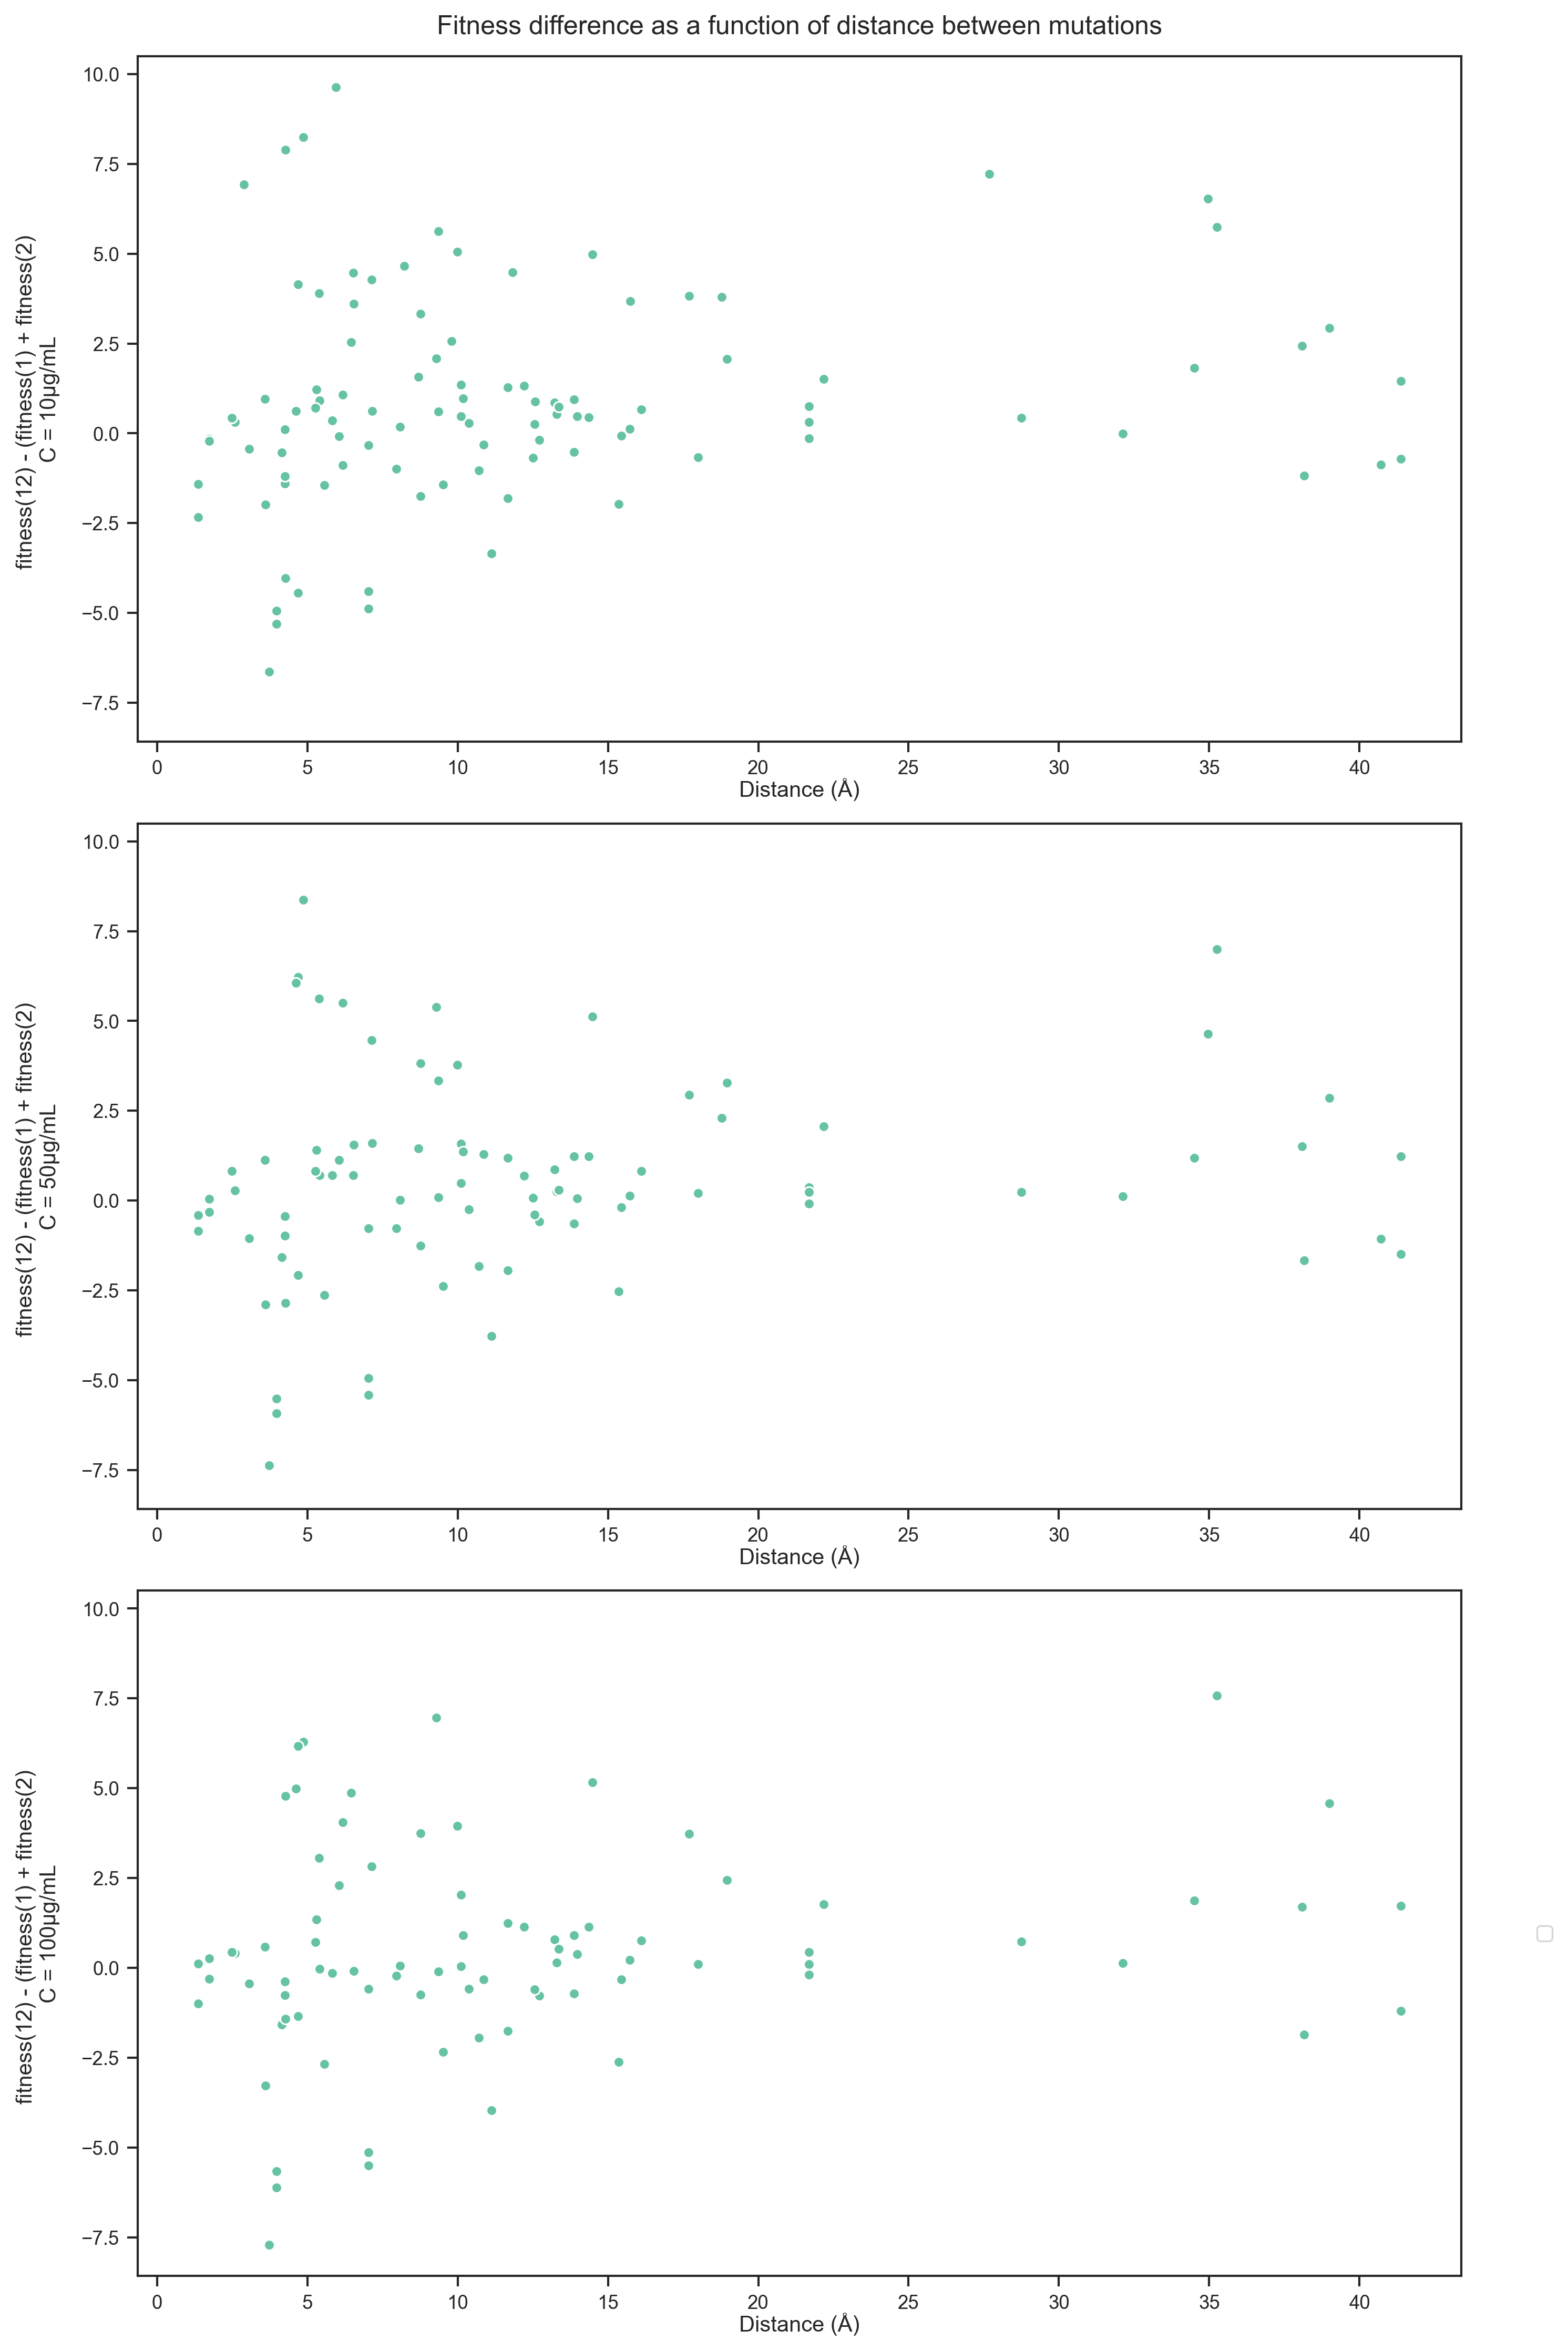

In [120]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


fig, ax = plt.subplots(3, 1, figsize=(10, 15), sharey=True)

sns.scatterplot(ax=ax[0],
             x=df_result.distance,
             y=df_result.difference_ten)
ax[0].set_title('Fitness difference as a function of distance between mutations', fontsize=12, pad=10)
ax[0].set_xlabel('Distance (Å)', fontsize=10, labelpad=0)
ax[0].set_ylabel('fitness(12) - (fitness(1) + fitness(2) \nC = 10µg/mL', fontsize=10, labelpad=10)

sns.scatterplot(ax=ax[1],
             x=df_result.distance,
             y=df_result.difference_fifty)
ax[1].set_xlabel('Distance (Å)', fontsize=10, labelpad=0)
ax[1].set_ylabel('fitness(12) - (fitness(1) + fitness(2) \nC = 50µg/mL', fontsize=10, labelpad=10)

sns.scatterplot(ax=ax[2],
             x=df_result.distance,
             y=df_result.difference_hundred)
ax[2].set_xlabel('Distance (Å)', fontsize=10, labelpad=0)
ax[2].set_ylabel('fitness(12) - (fitness(1) + fitness(2) \nC = 100µg/mL', fontsize=10, labelpad=10)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
# plt.savefig('Fitness difference as a function of distance between mutations - 3 plots.png')

#### Graphics overlaid on 1 figure

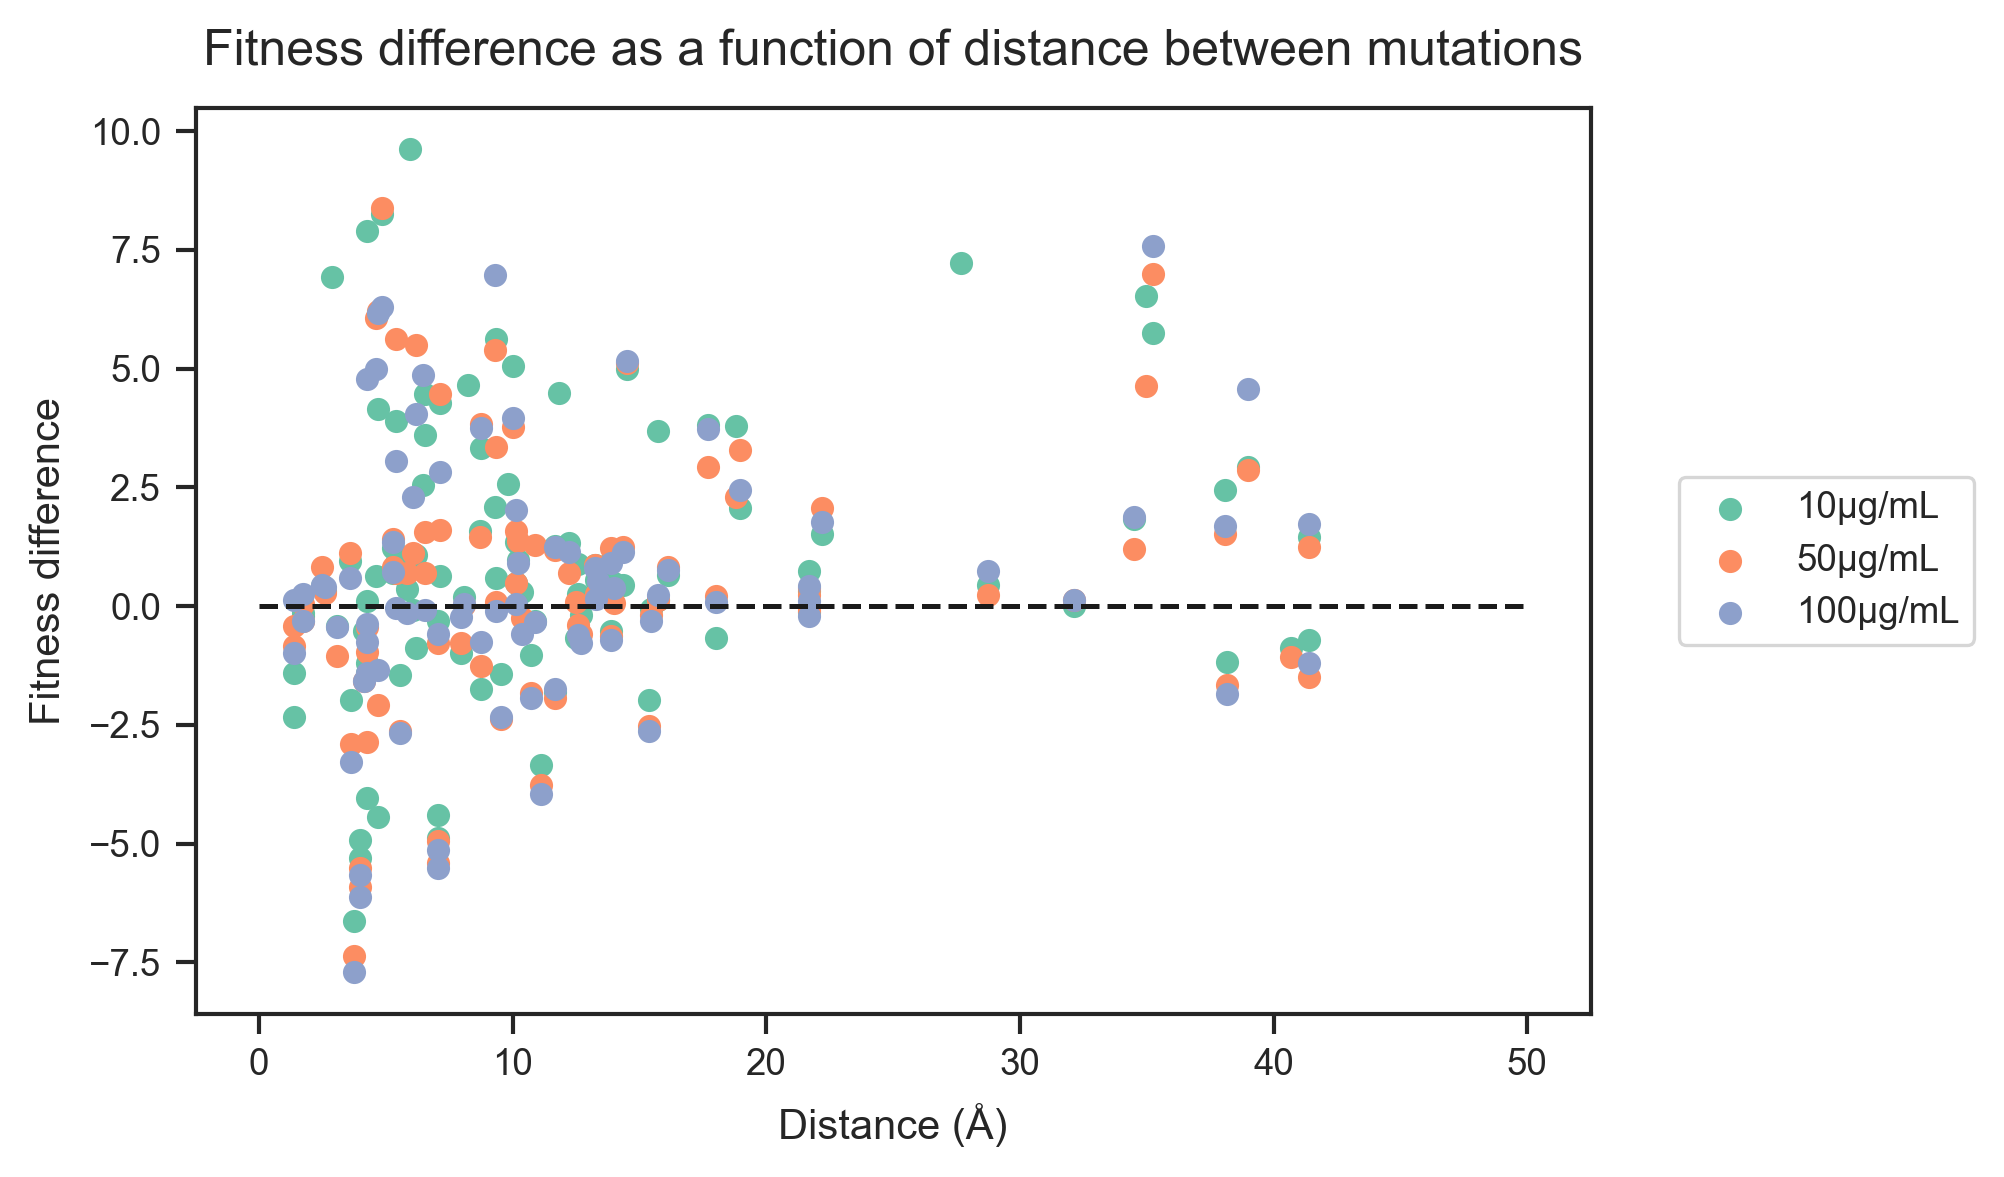

In [121]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots()
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.difference_ten,
             label='10µg/mL', edgecolor=None)
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.difference_fifty,
             label='50µg/mL', edgecolor=None)
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.difference_hundred,
             label='100µg/mL', edgecolor=None)
plt.hlines(y=0, xmin=0, xmax=50, linestyles='--' )

plt.title('Fitness difference as a function of distance between mutations',
          pad=10,
          fontsize=12)
plt.xlabel('Distance (Å)',
           labelpad=5,
           fontsize=10)
plt.ylabel('Fitness difference',
           labelpad=5,
           fontsize=10)

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# plt.savefig('Fitness difference as a function of distance between mutations - overlaid.png')

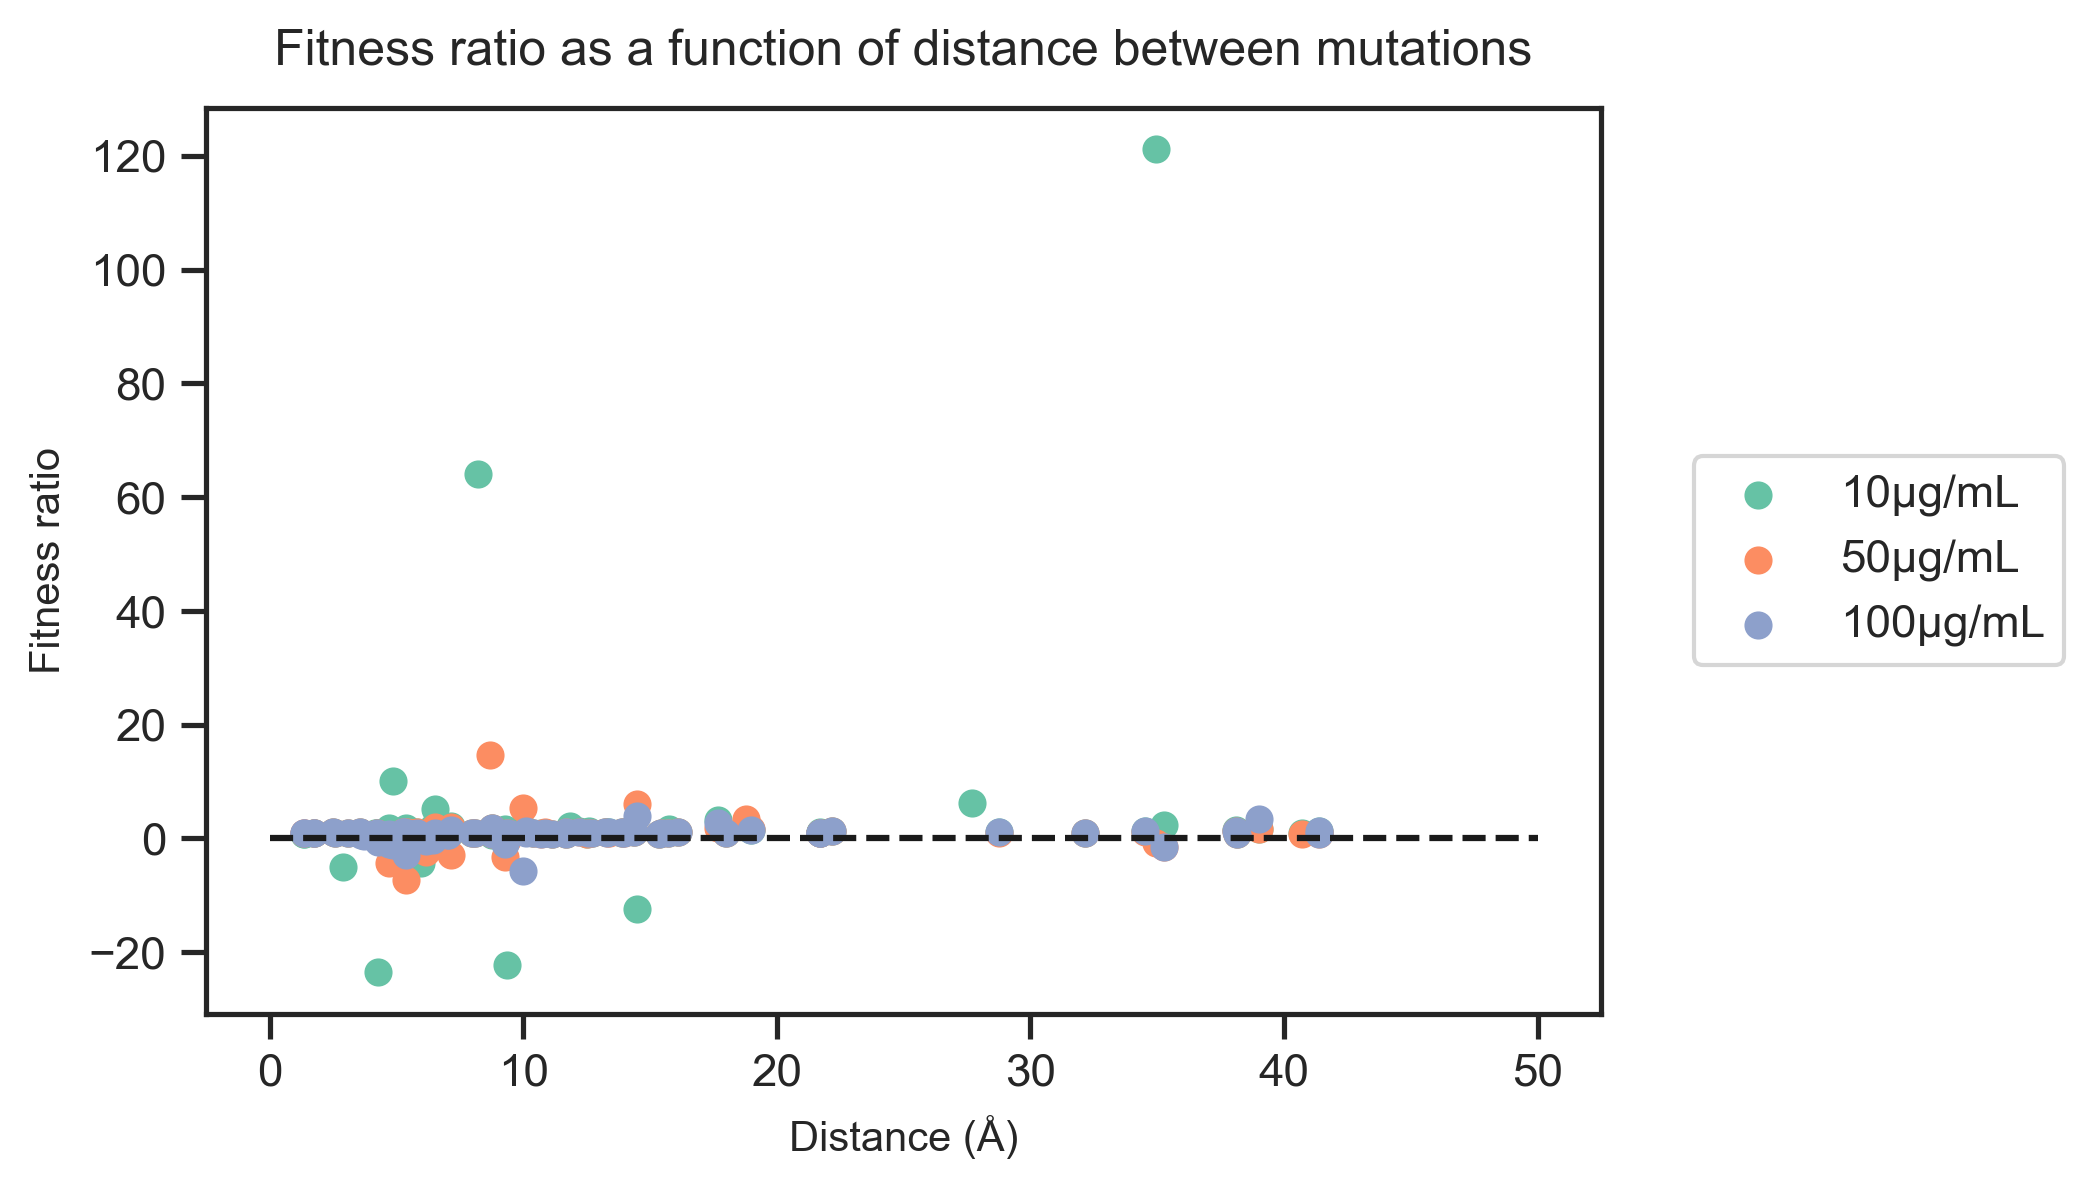

In [122]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots()
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.ratio_ten,
             label='10µg/mL', edgecolor=None)
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.ratio_fifty,
             label='50µg/mL', edgecolor=None)
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.ratio_hundred,
             label='100µg/mL', edgecolor=None)

plt.hlines(y=0, xmin=0, xmax=50, linestyles='--' )

plt.title('Fitness ratio as a function of distance between mutations',
          pad=10,
          fontsize=12)
plt.xlabel('Distance (Å)',
           labelpad=5,
           fontsize=10)
plt.ylabel('Fitness ratio',
           labelpad=5,
           fontsize=10)

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# plt.savefig('Fitness difference as a function of distance between mutations - overlaid.png')

In [123]:
df_result['ratio_ten'].mean()

2.41288835479507

### Distribution of distance between 2 mutations

Text(0.5, 0, 'Distance (Å)')

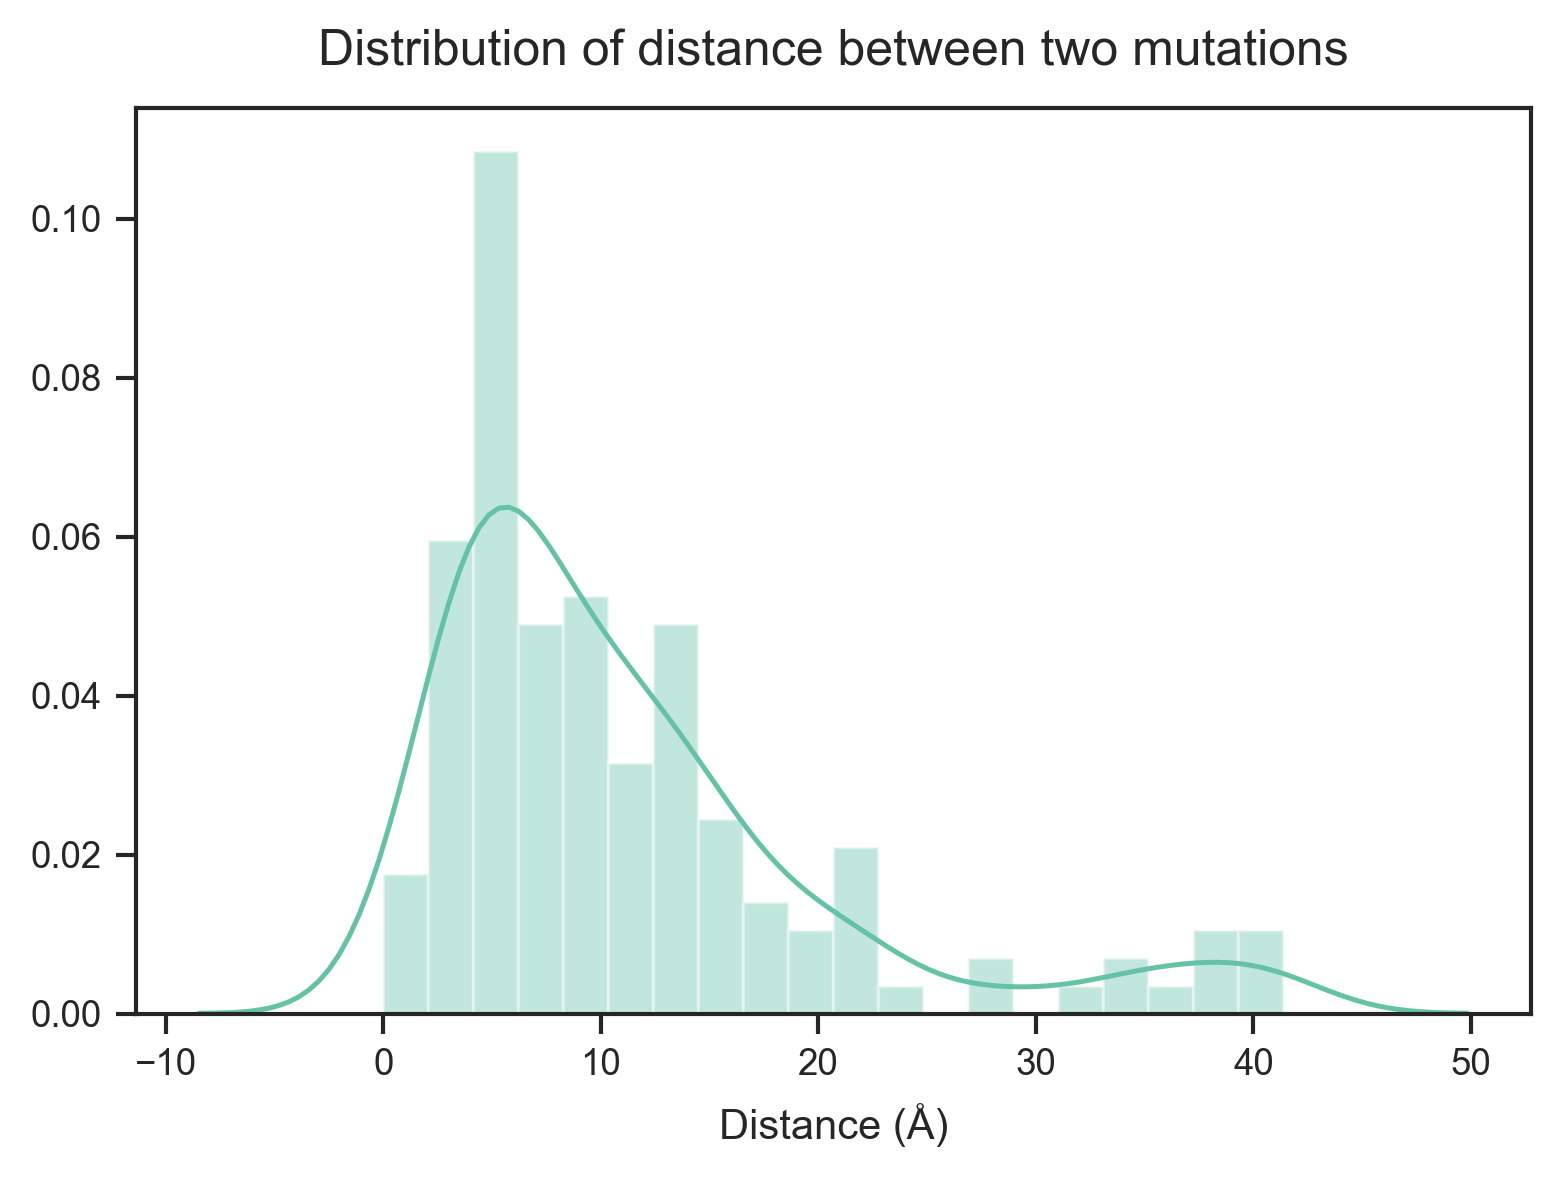

In [124]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig = sns.distplot(df_result['distance'], bins=20)

plt.title('Distribution of distance between two mutations',
          pad=10,
          fontsize=12)
plt.xlabel('Distance (Å)',
           labelpad=5,
           fontsize=10)

# plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# plt.savefig('Distribution of distance between two mutations.png')

### Distribution of fitness difference and ratio

#### Distribution of fitness difference at 10µg/mL

Text(0.5, 0, 'Fitness difference')

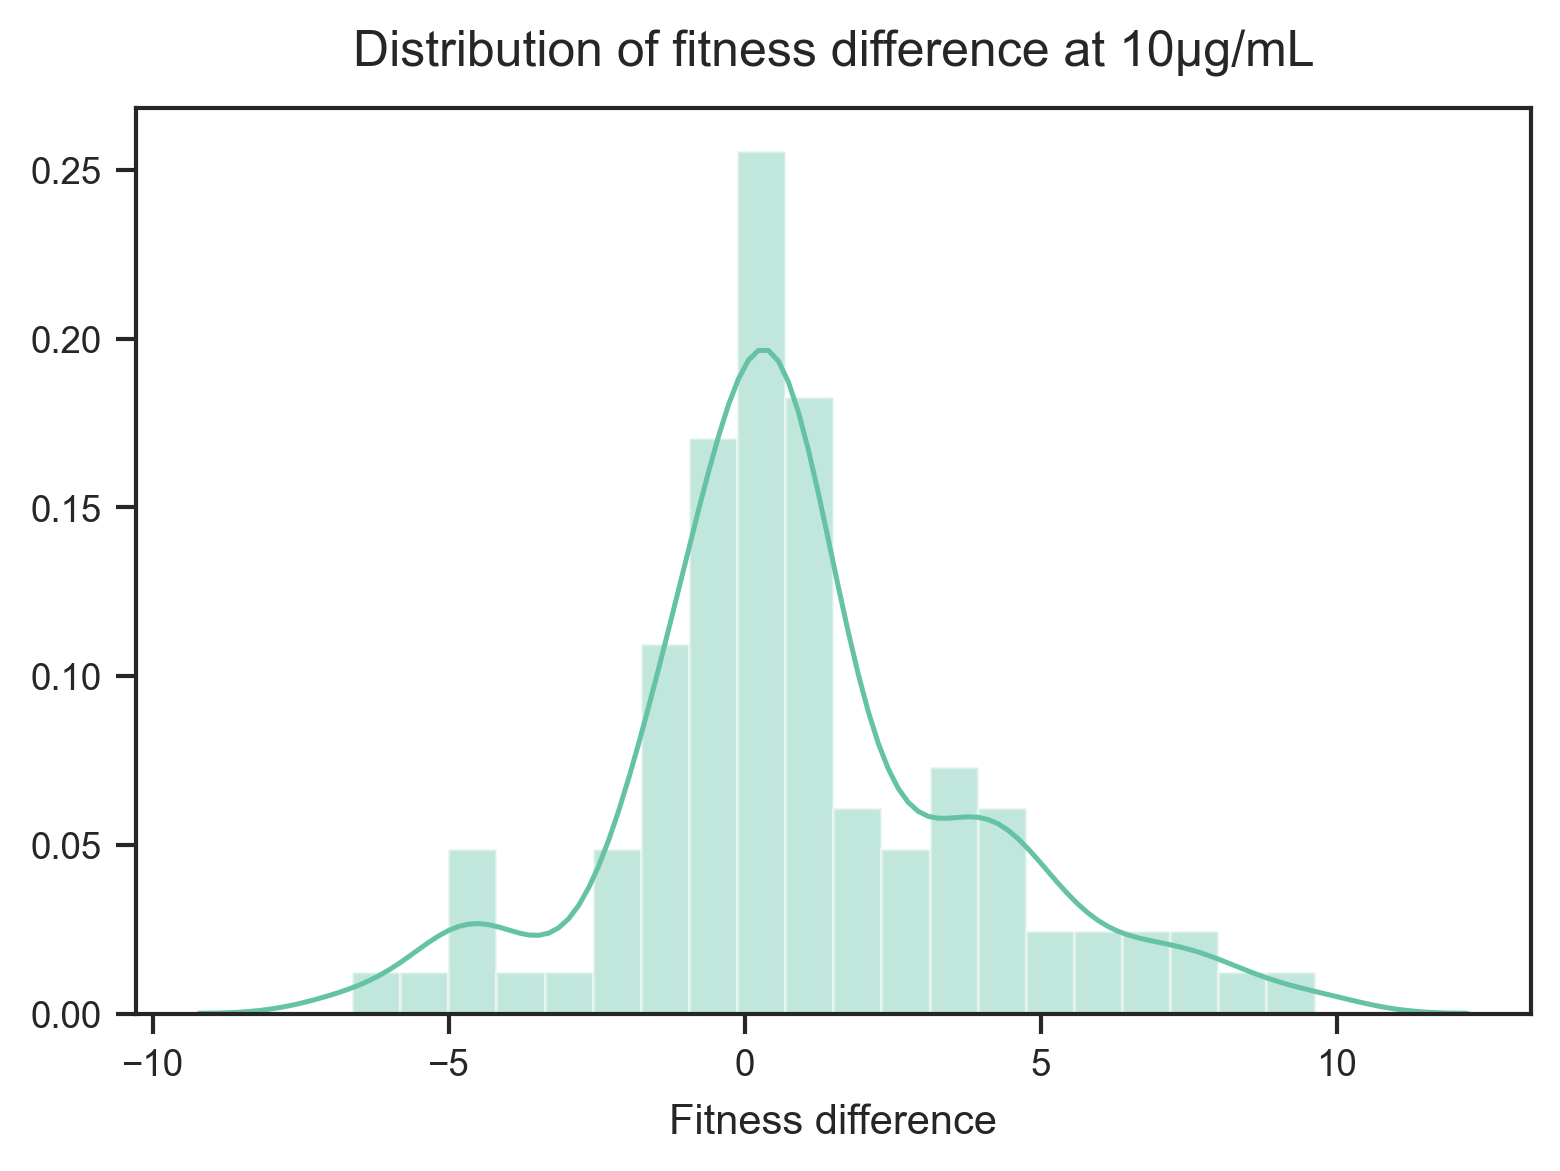

In [125]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


fig = sns.distplot(df_result['difference_ten'], bins=20)

plt.title('Distribution of fitness difference at 10µg/mL',
          pad=10,
          fontsize=12)
plt.xlabel('Fitness difference',
           labelpad=5,
           fontsize=10)

# plt.savefig('Distribution of fitness difference at 10µg-mL')

#### Distribution of fitness difference at 50µg/mL

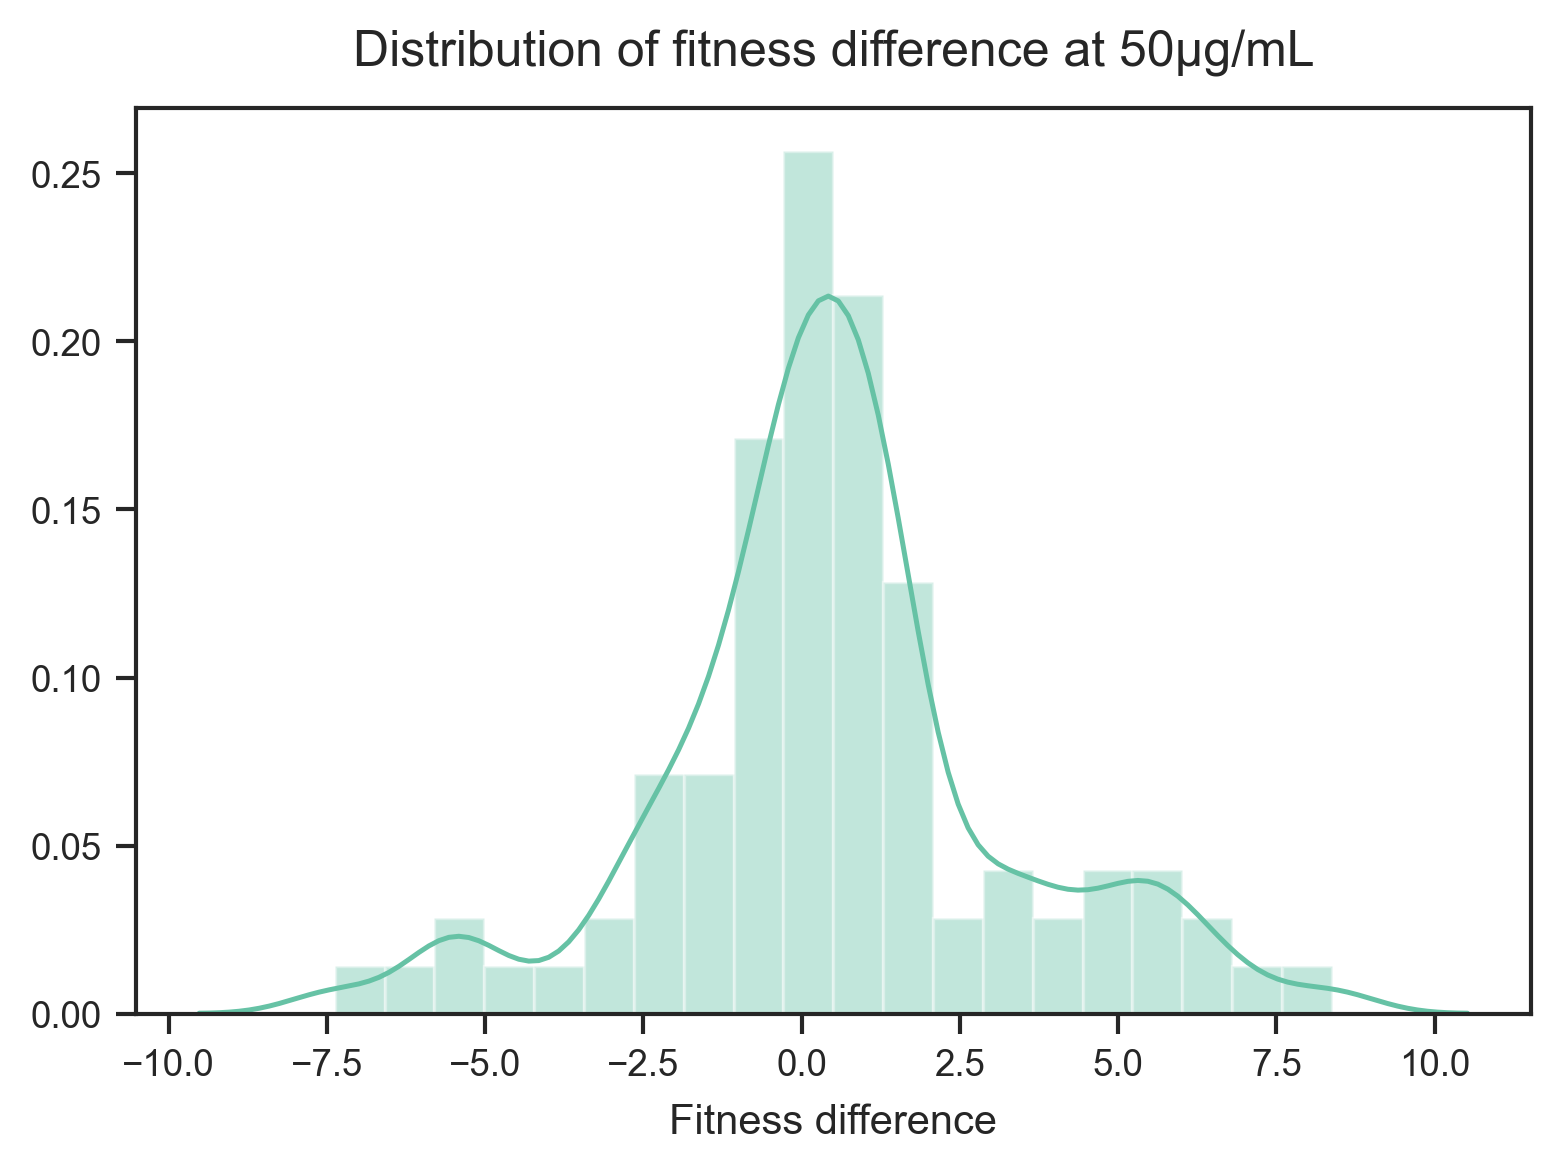

In [126]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig = sns.distplot(df_result['difference_fifty'], bins=20)

plt.title('Distribution of fitness difference at 50µg/mL',
          pad=10,
          fontsize=12)
plt.xlabel('Fitness difference',
           labelpad=5,
           fontsize=10)

plt.savefig('Distribution of fitness difference at 50µg-mL.png')

#### Distribution of fitness difference at 100µg/mL

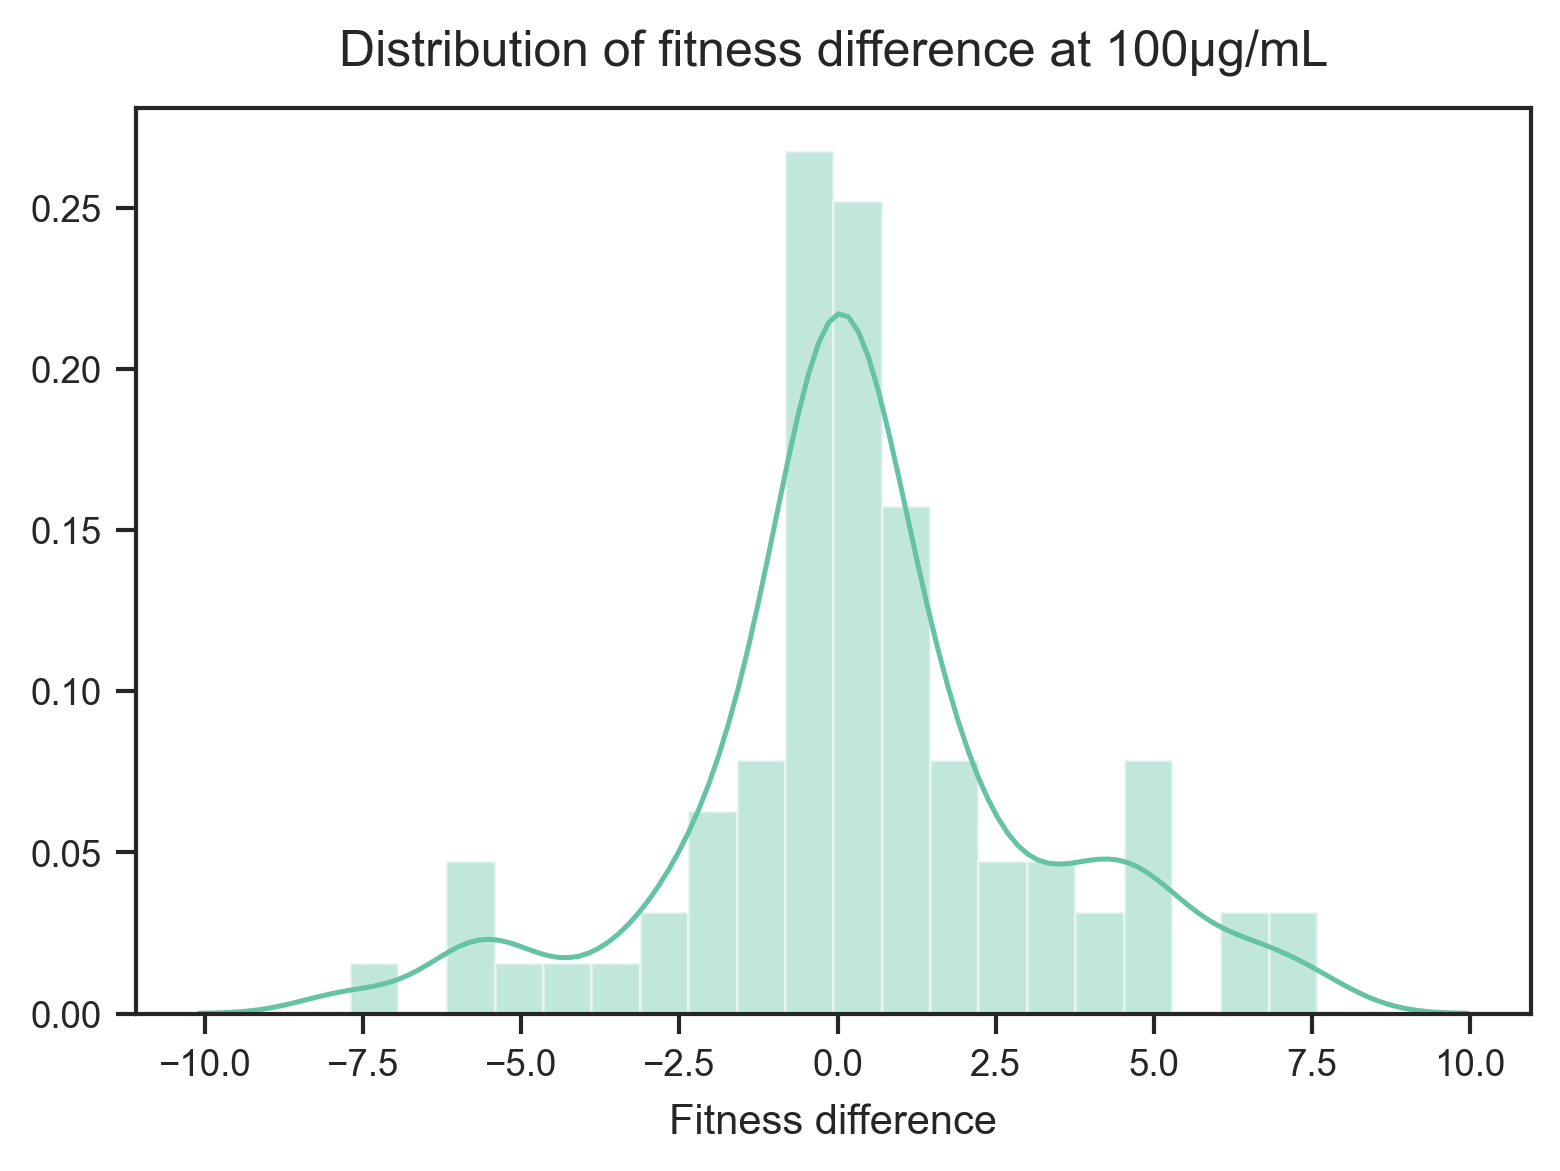

In [127]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig = sns.distplot(df_result['difference_hundred'], bins=20)

plt.title('Distribution of fitness difference at 100µg/mL',
          pad=10,
          fontsize=12)
plt.xlabel('Fitness difference',
           labelpad=5,
           fontsize=10)

plt.savefig('Distribution of fitness difference at 100µg-mL.png')

### Jointplot between fitness difference and distance

#### Jointplot between fitness difference and distance at 10µg/mL

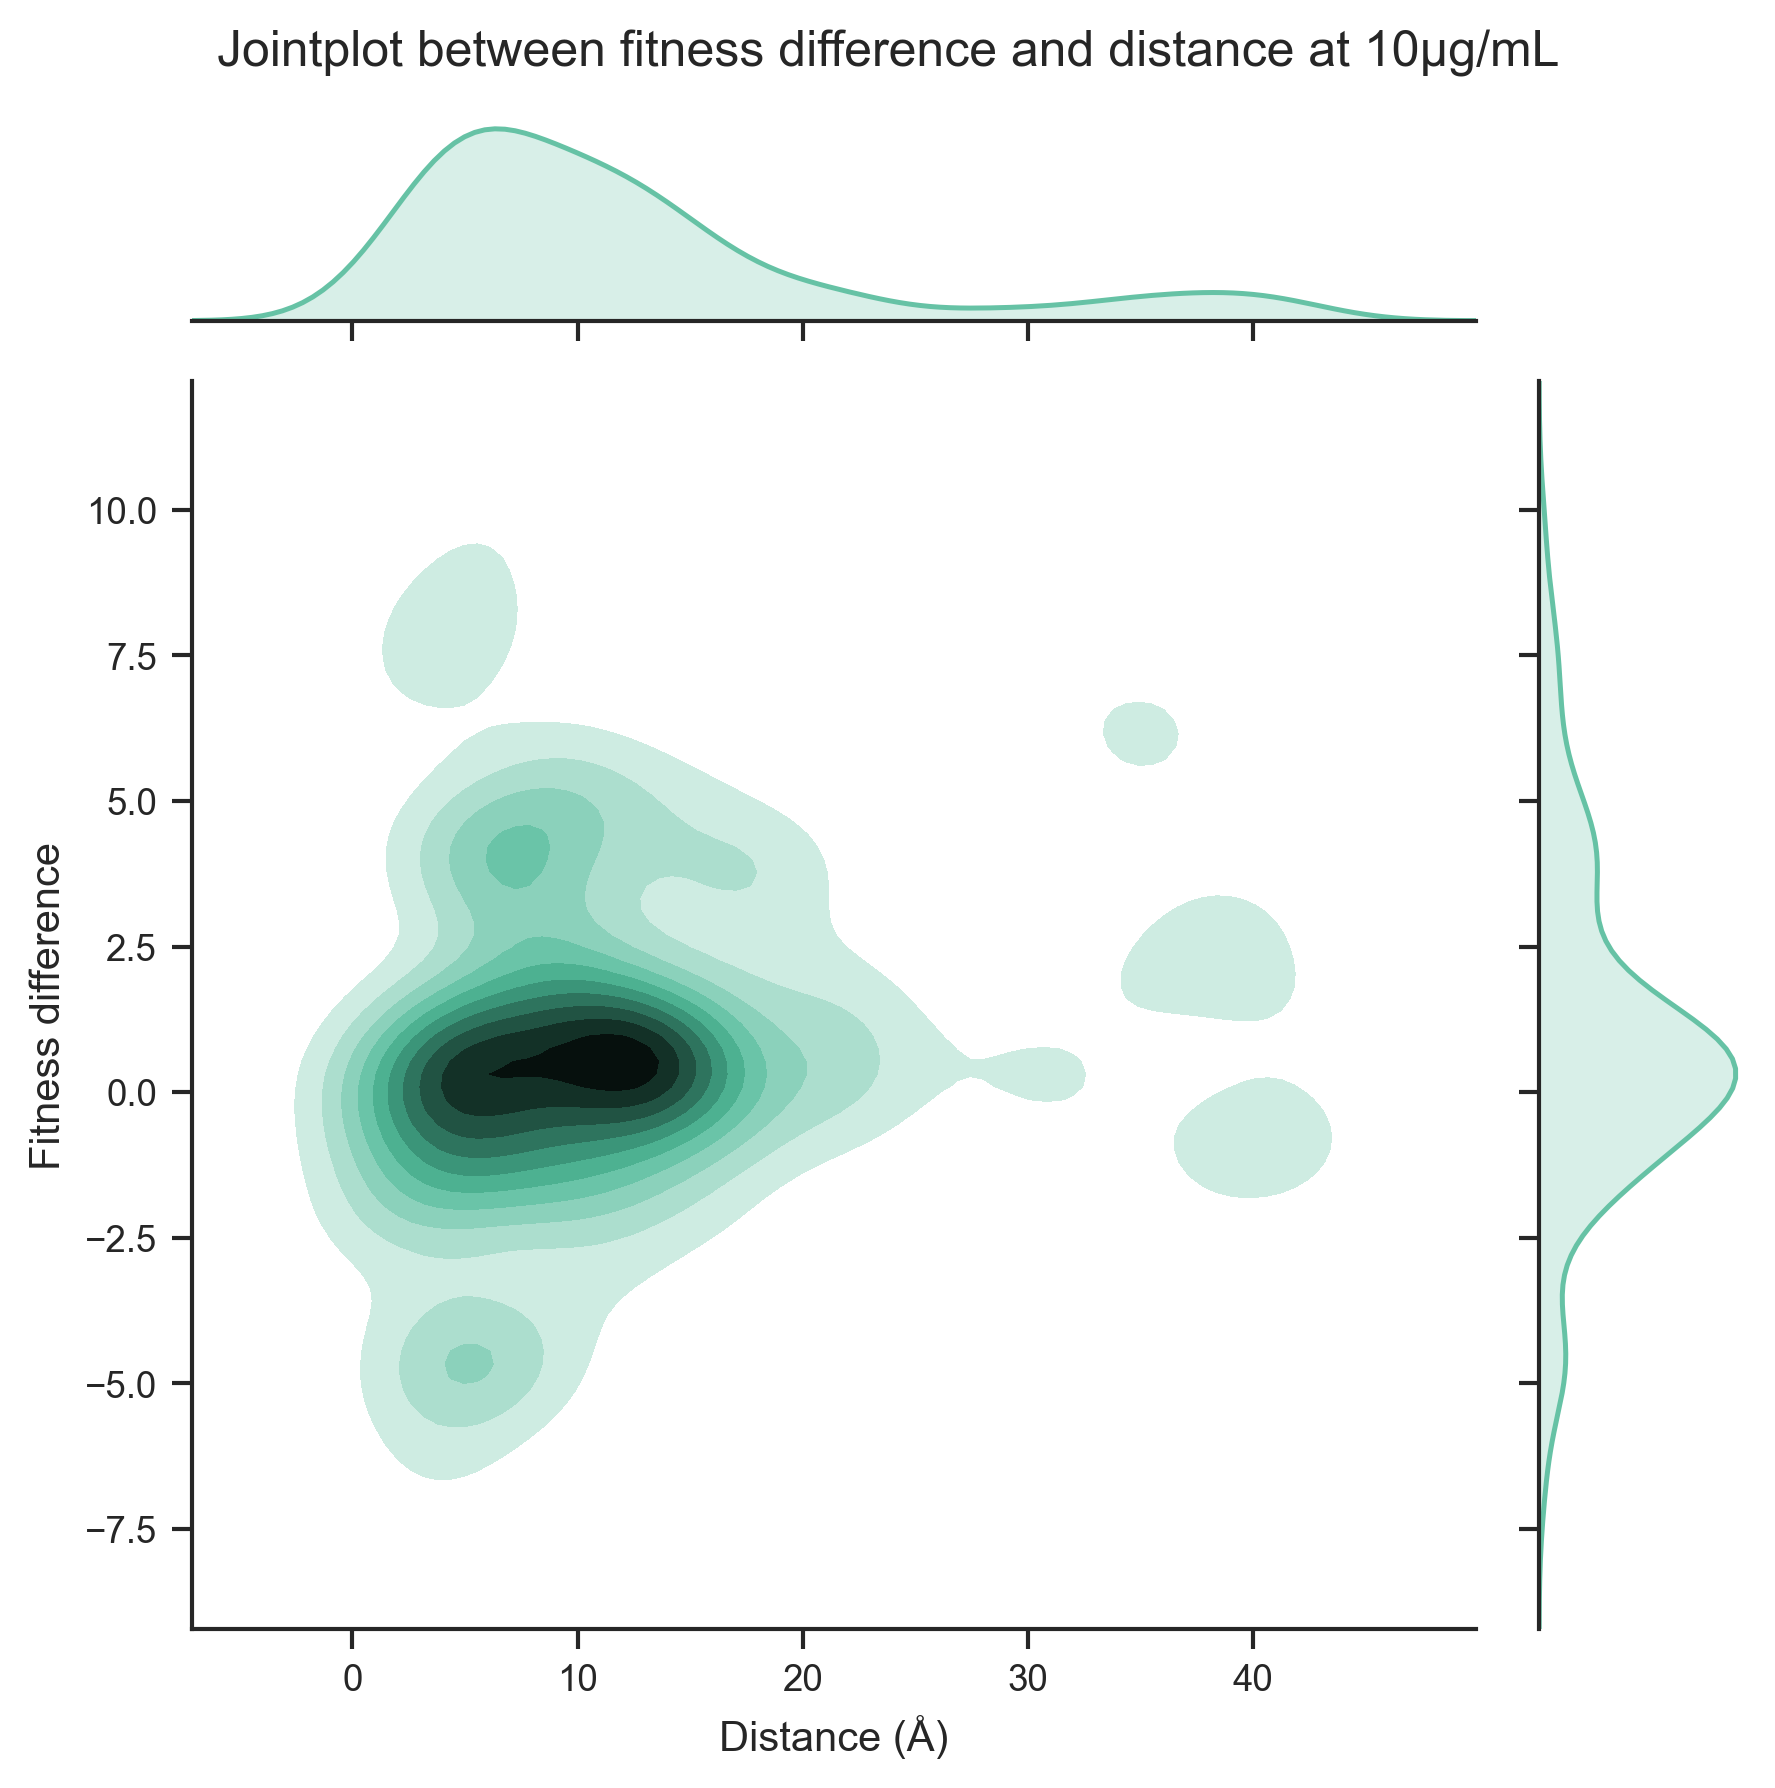

In [128]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

jp = sns.jointplot(x=df_result.distance,
              y=df_result.difference_ten,
              kind='kde')

jp.fig.suptitle('Jointplot between fitness difference and distance at 10µg/mL', fontsize=12)
jp.ax_joint.collections[0].set_alpha(0)
jp.fig.tight_layout()
jp.fig.subplots_adjust(top=0.93)
jp.set_axis_labels( 'Distance (Å)', 'Fitness difference', fontsize=10)

# plt.savefig('Jointplot between fitness difference and distance at 10µg/mL.png', dpi=300)

#### Jointplot between fitness difference and distance at 50µg/mL

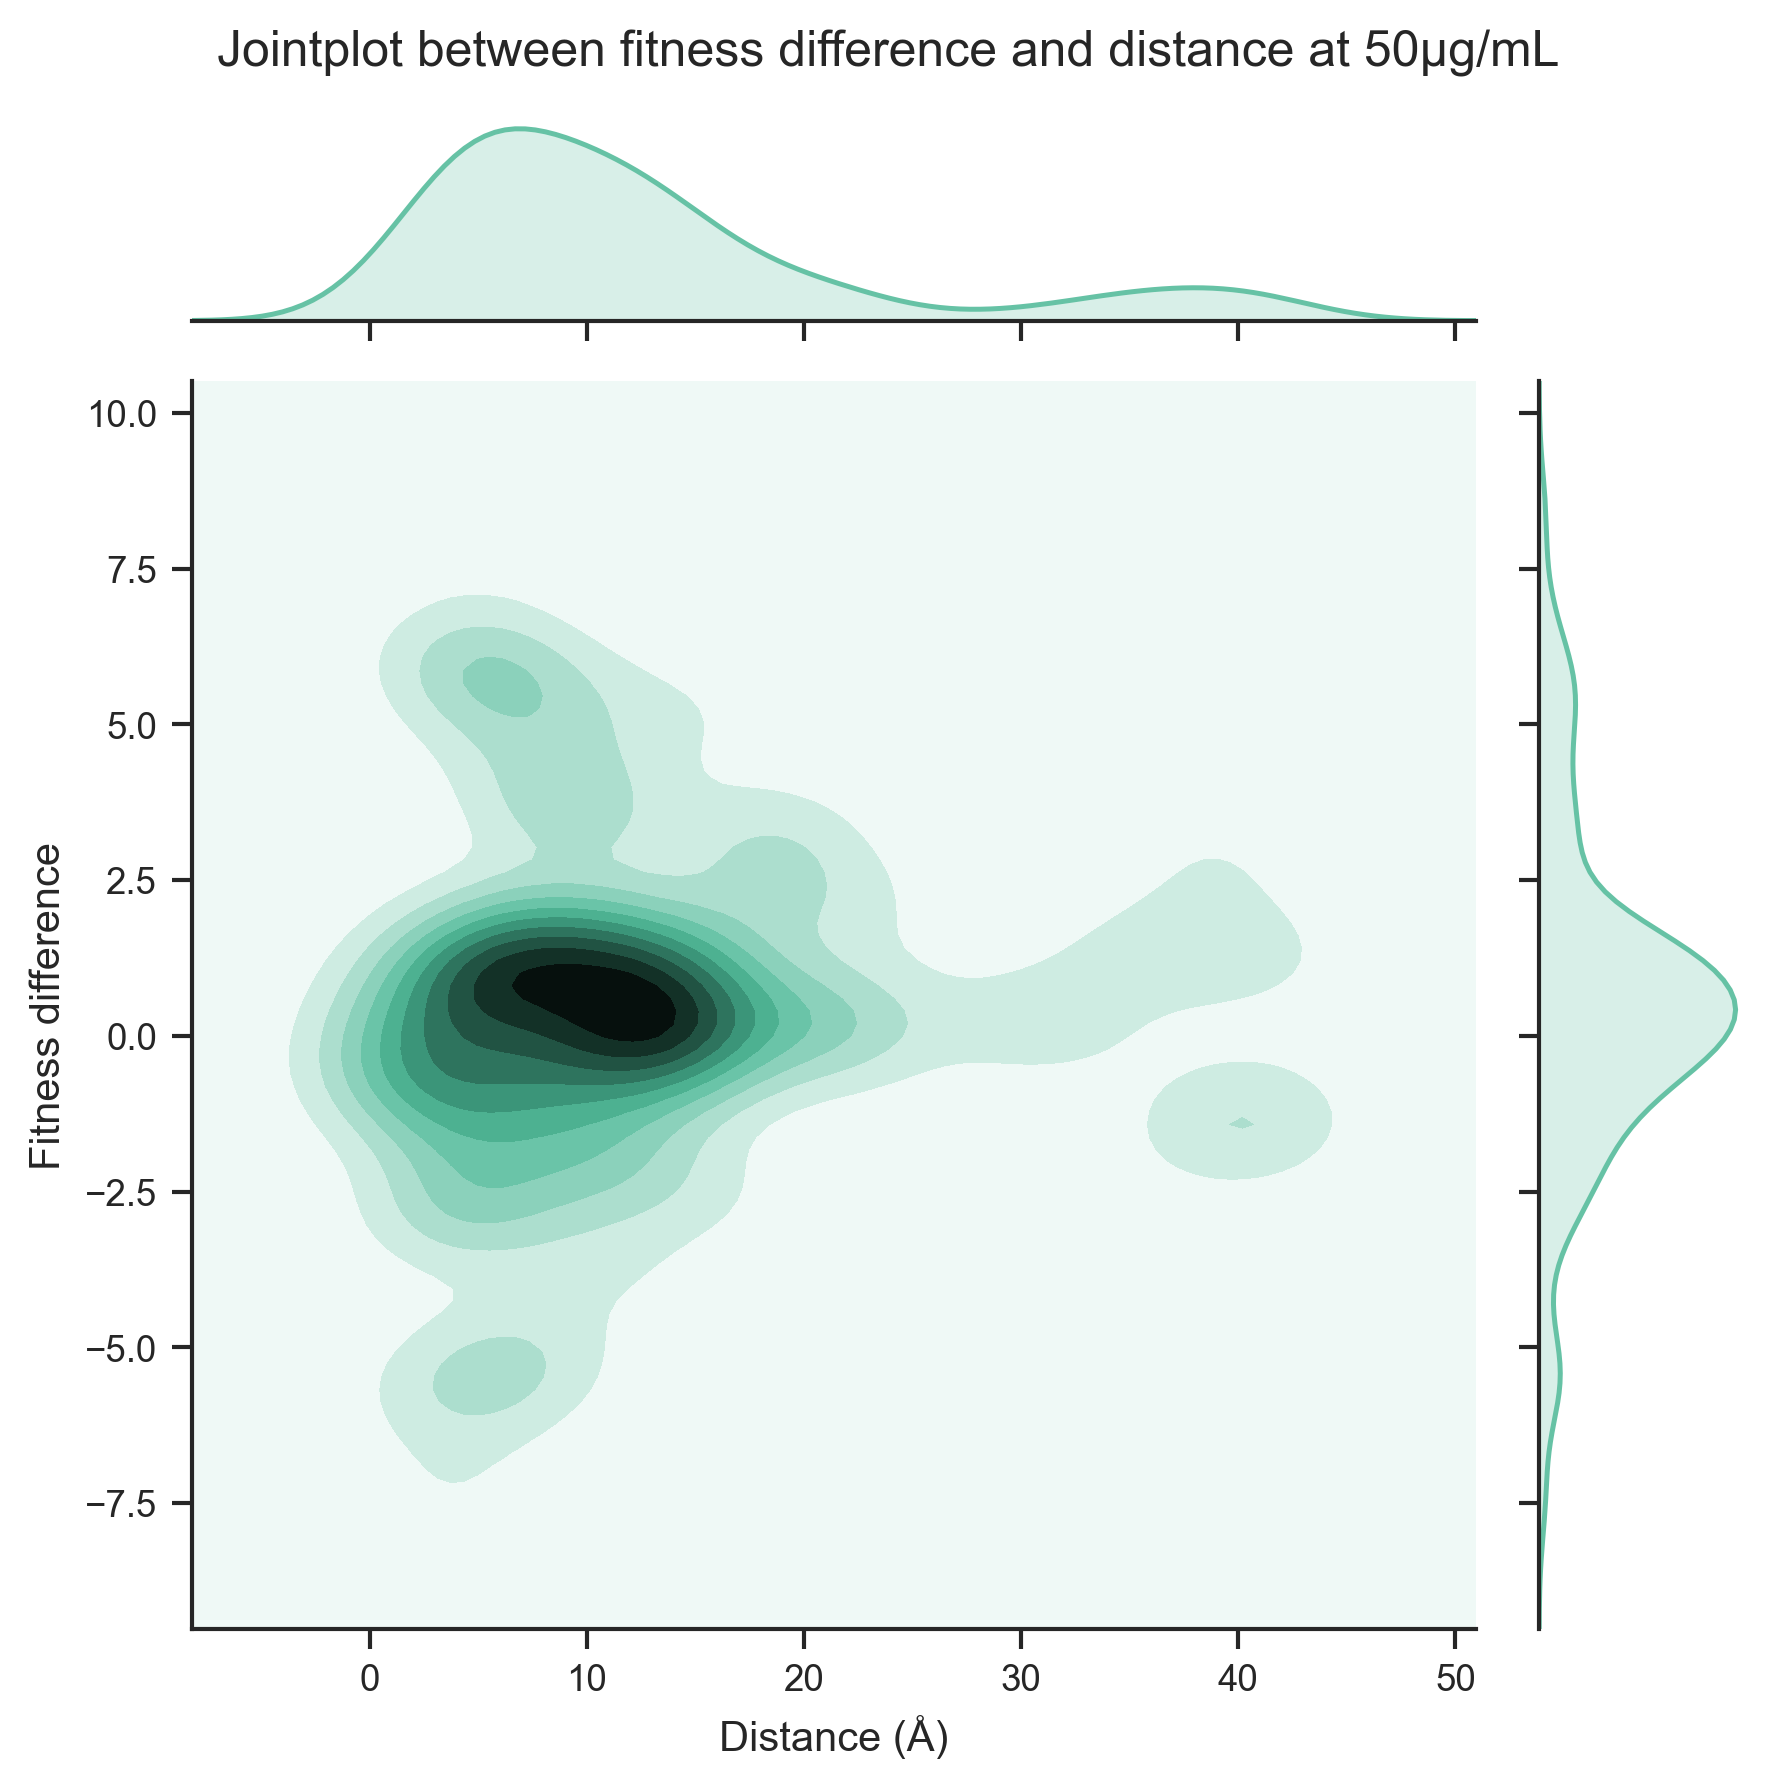

In [129]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

jp = sns.jointplot(x=df_result.distance,
              y=df_result.difference_fifty,
              kind='kde')

jp.fig.suptitle('Jointplot between fitness difference and distance at 50µg/mL', fontsize=12)
# p.ax_joint.collections[0].set_alpha(0)
jp.fig.tight_layout()
jp.fig.subplots_adjust(top=0.93)
jp.set_axis_labels( 'Distance (Å)', 'Fitness difference', fontsize=10)

# plt.savefig('Jointplot between fitness difference and distance at 50µg/mL.png')

#### Jointplot between fitness difference and distance at 100µg/mL

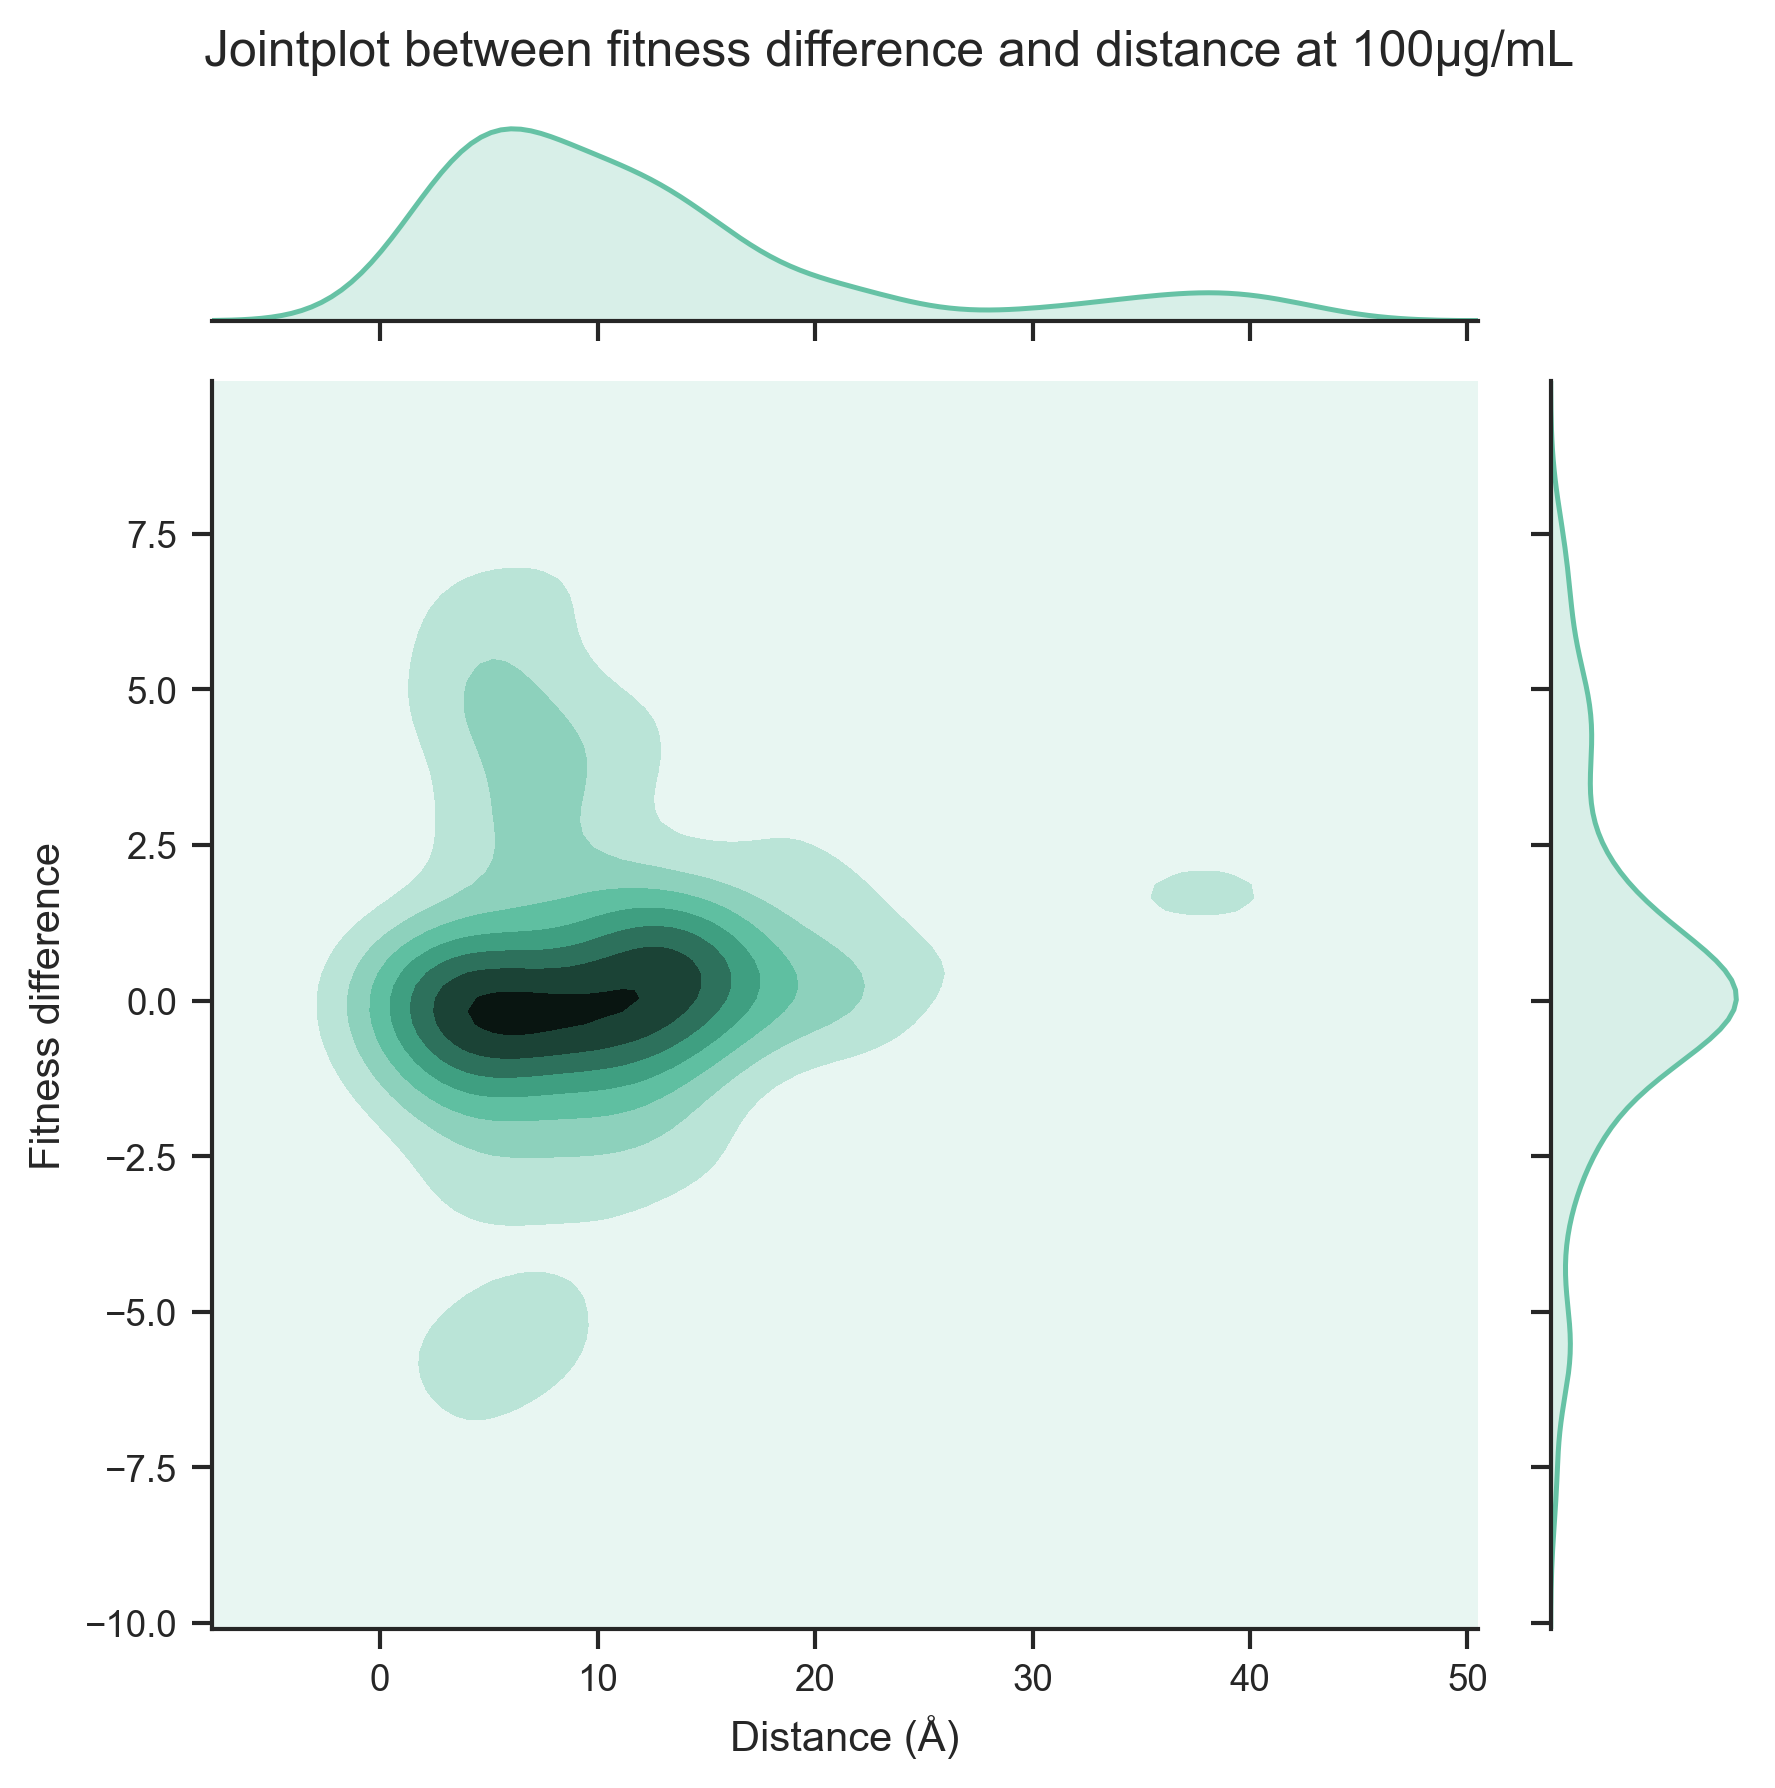

In [130]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

jp = sns.jointplot(x=df_result.distance,
              y=df_result.difference_hundred,
              kind='kde')

jp.fig.suptitle('Jointplot between fitness difference and distance at 100µg/mL', fontsize=12)
# p.ax_joint.collections[0].set_alpha(0)
jp.fig.tight_layout()
jp.fig.subplots_adjust(top=0.93)
jp.set_axis_labels( 'Distance (Å)', 'Fitness difference', fontsize=10)

# plt.savefig('Jointplot between fitness difference and distance at 100µg/mL.png')

### Sum of fitness vs actual fitness

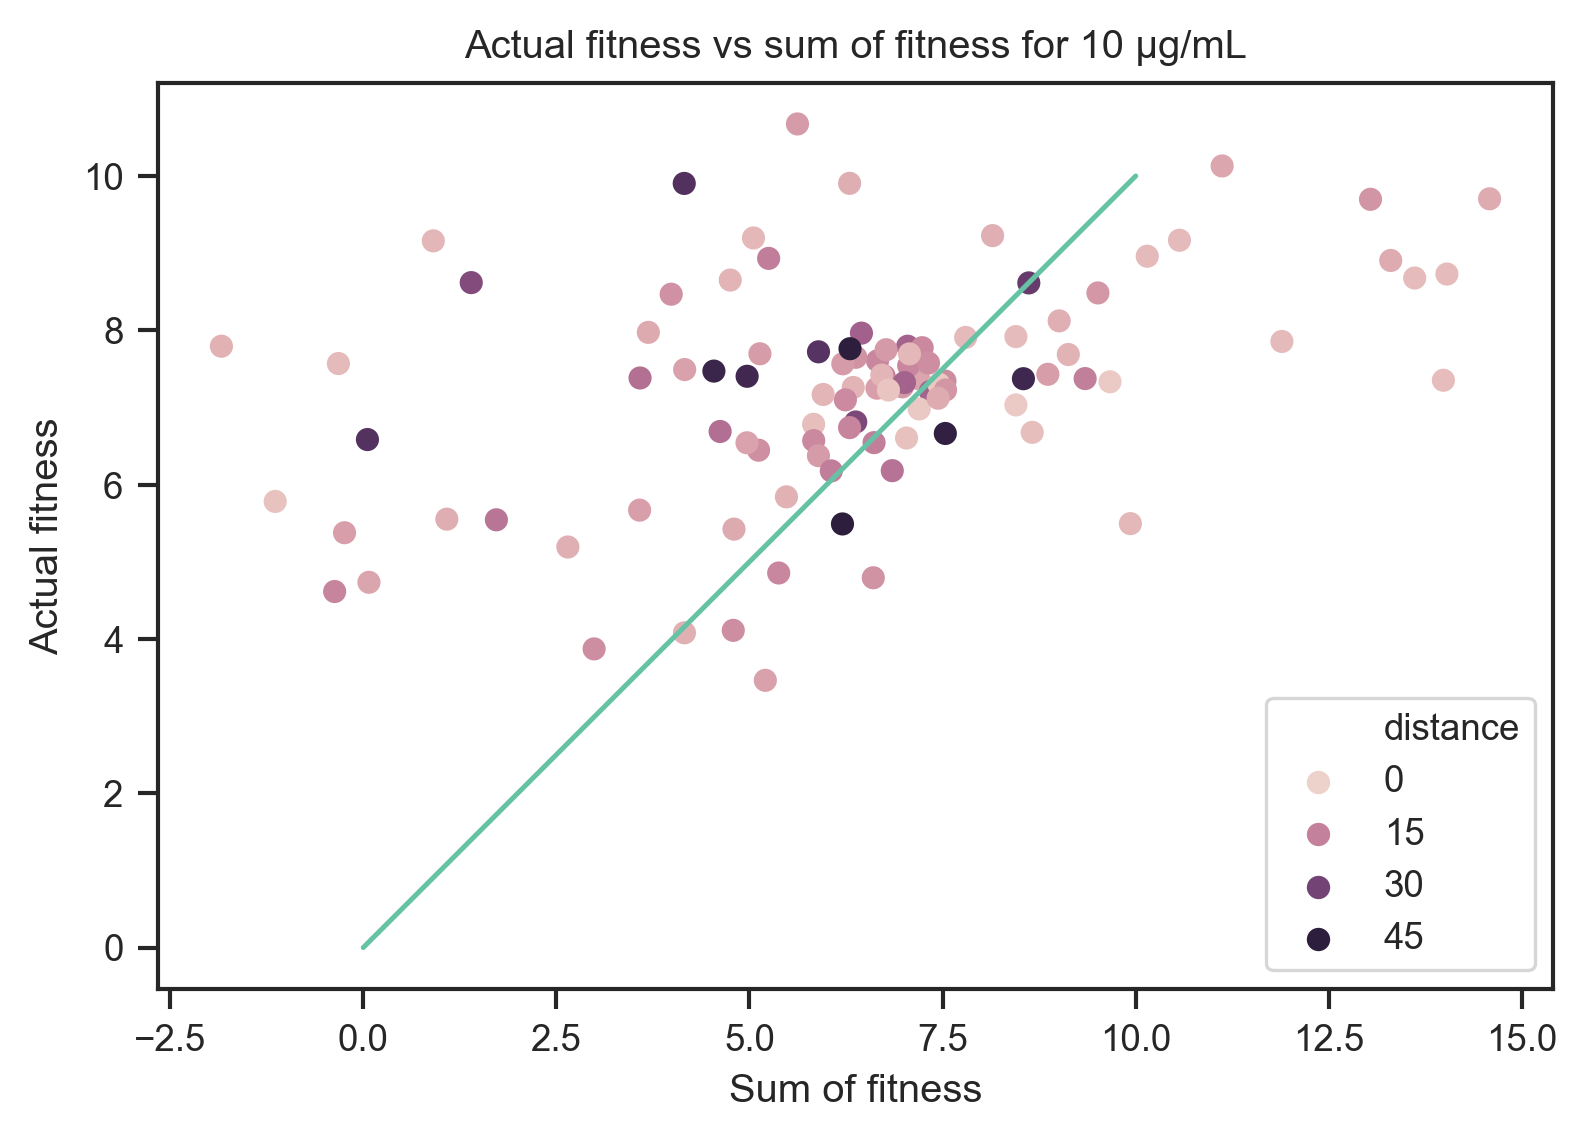

In [131]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


ax1 = sns.scatterplot(x=df_result['fitness_12_ten'],
                y=df_result['fitness_ten'],
                hue=df_result['distance'],
                
               edgecolor=None)

ax1.set(xlabel='Sum of fitness', ylabel='Actual fitness')
plt.title('Actual fitness vs sum of fitness for 10 µg/mL')

ax2 = sns.lineplot(x=[0,10], y=[0,10], dashes=[(2, 2), (2, 2)])


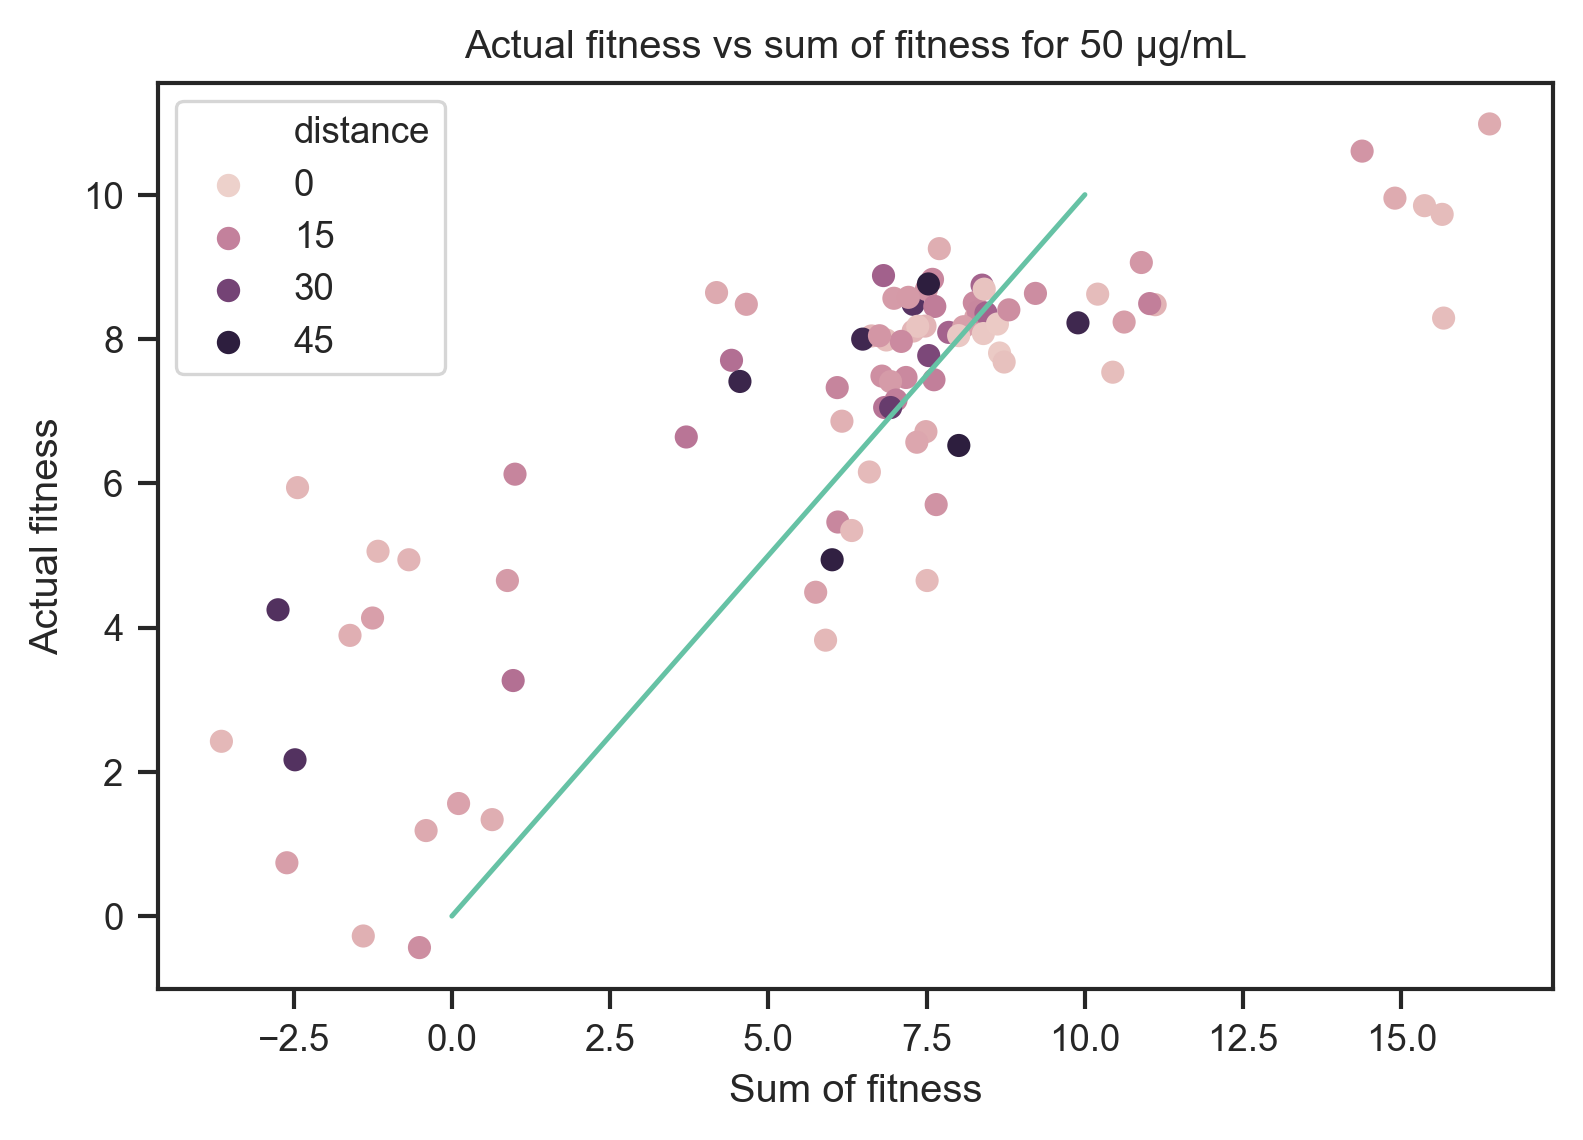

In [132]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


ax1 = sns.scatterplot(x=df_result['fitness_12_fifty'],
                y=df_result['fitness_fifty'],
                hue=df_result['distance'],
                
               edgecolor=None)

ax1.set(xlabel='Sum of fitness', ylabel='Actual fitness')
plt.title('Actual fitness vs sum of fitness for 50 µg/mL')

ax2 = sns.lineplot(x=[0,10], y=[0,10], dashes=[(2, 2), (2, 2)])


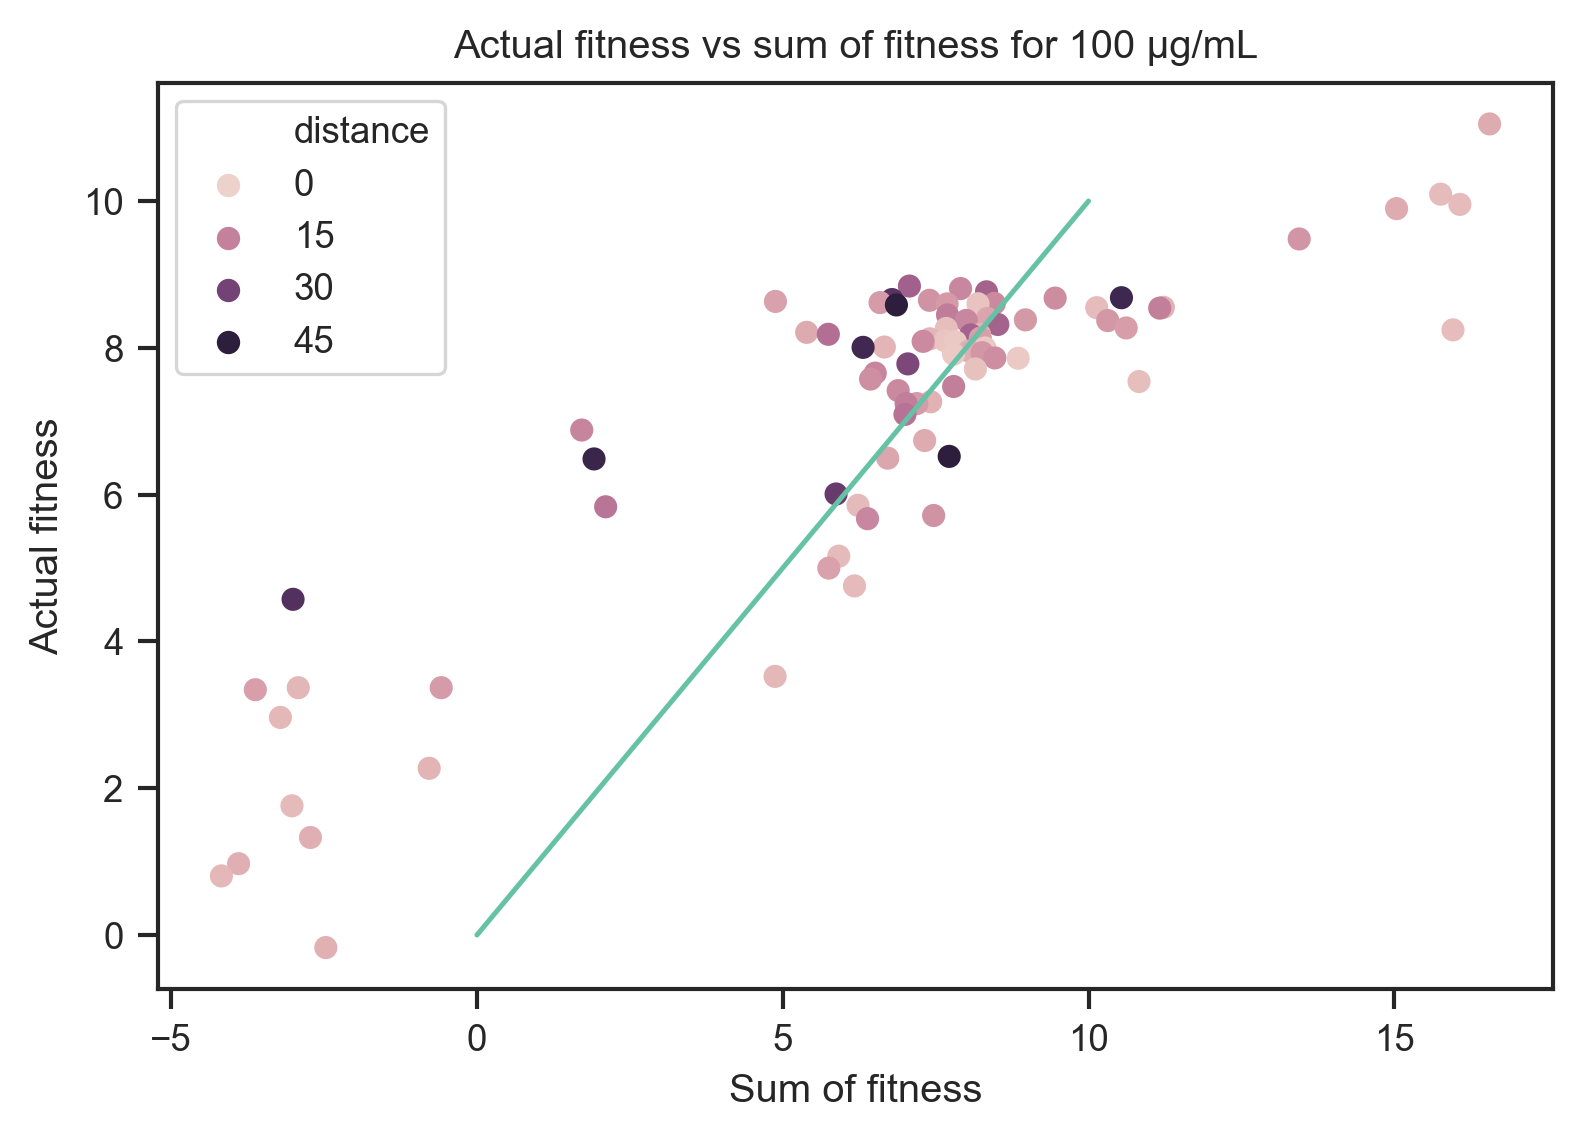

In [133]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


ax1 = sns.scatterplot(x=df_result['fitness_12_hundred'],
                y=df_result['fitness_hundred'],
                hue=df_result['distance'],
                
               edgecolor=None)

ax1.set(xlabel='Sum of fitness', ylabel='Actual fitness')
plt.title('Actual fitness vs sum of fitness for 100 µg/mL')

ax2 = sns.lineplot(x=[0,10], y=[0,10], dashes=[(2, 2), (2, 2)])


### Ratio plots

Text(0.5, 0, 'Fitness ratio')

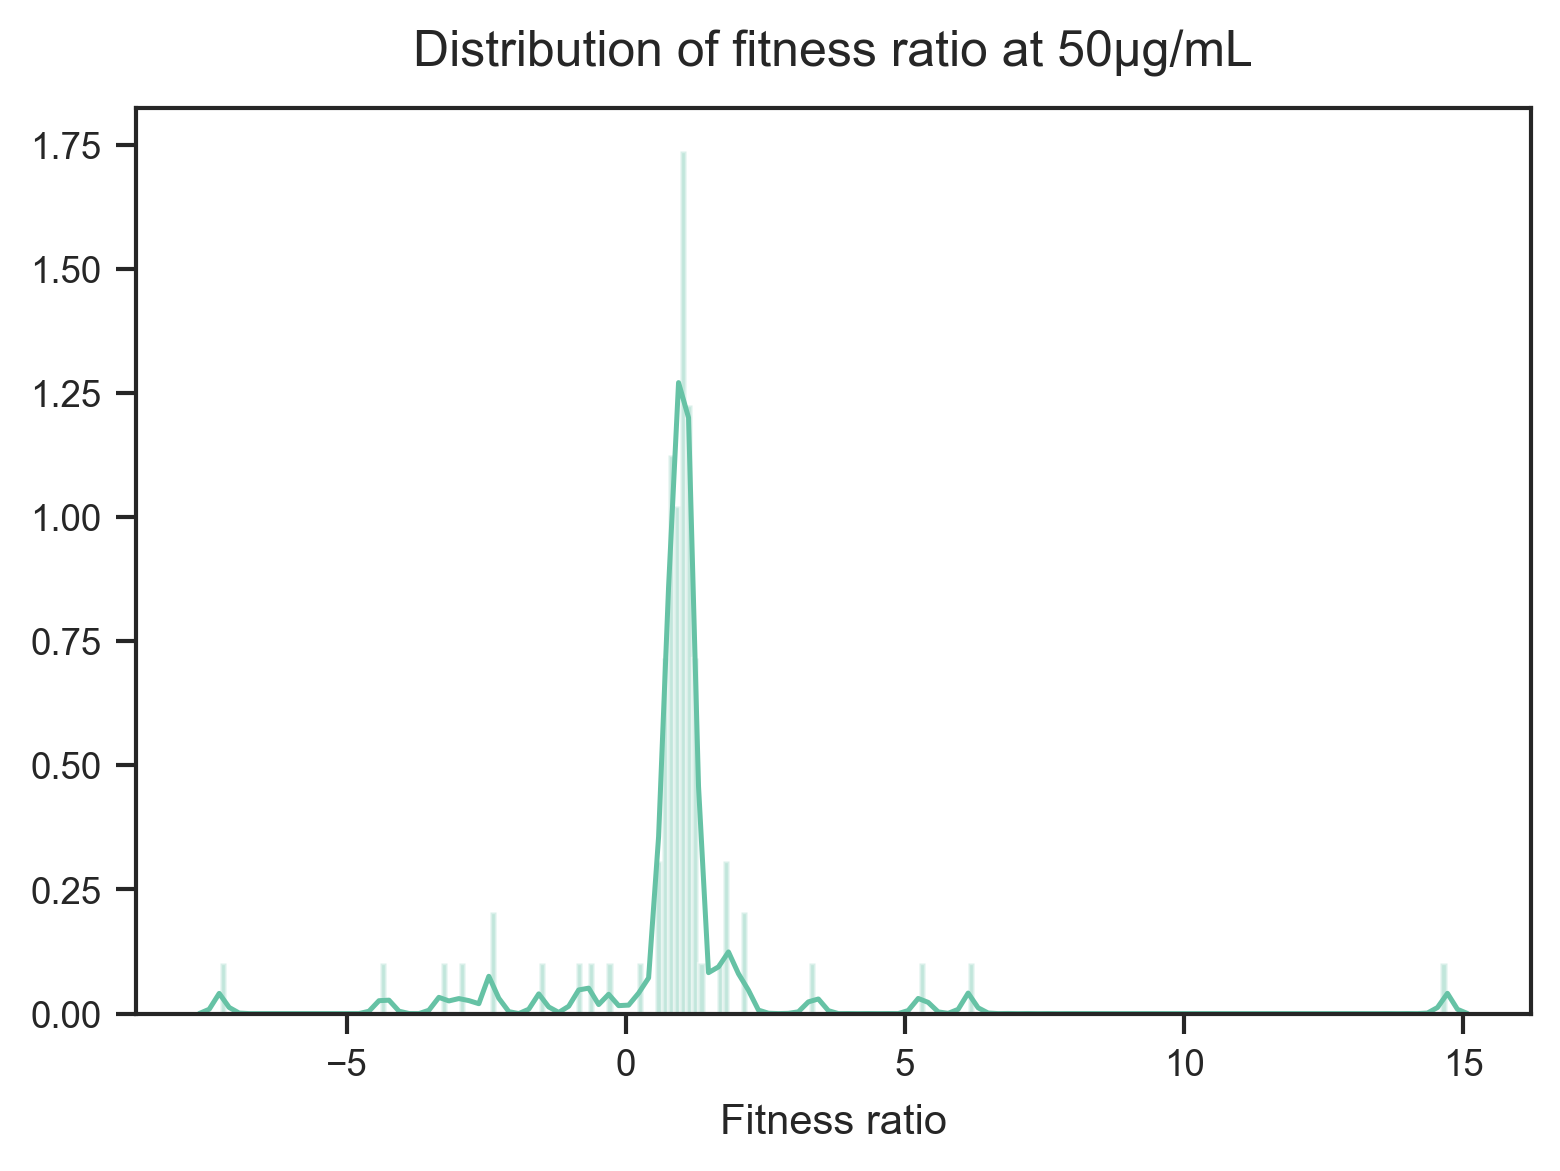

In [134]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


fig = sns.distplot(df_result['ratio_fifty'], bins=200)

plt.title('Distribution of fitness ratio at 50µg/mL',
          pad=10,
          fontsize=12)
plt.xlabel('Fitness ratio',
           labelpad=5,
           fontsize=10)

# plt.savefig('Distribution of fitness difference at 10µg-mL')

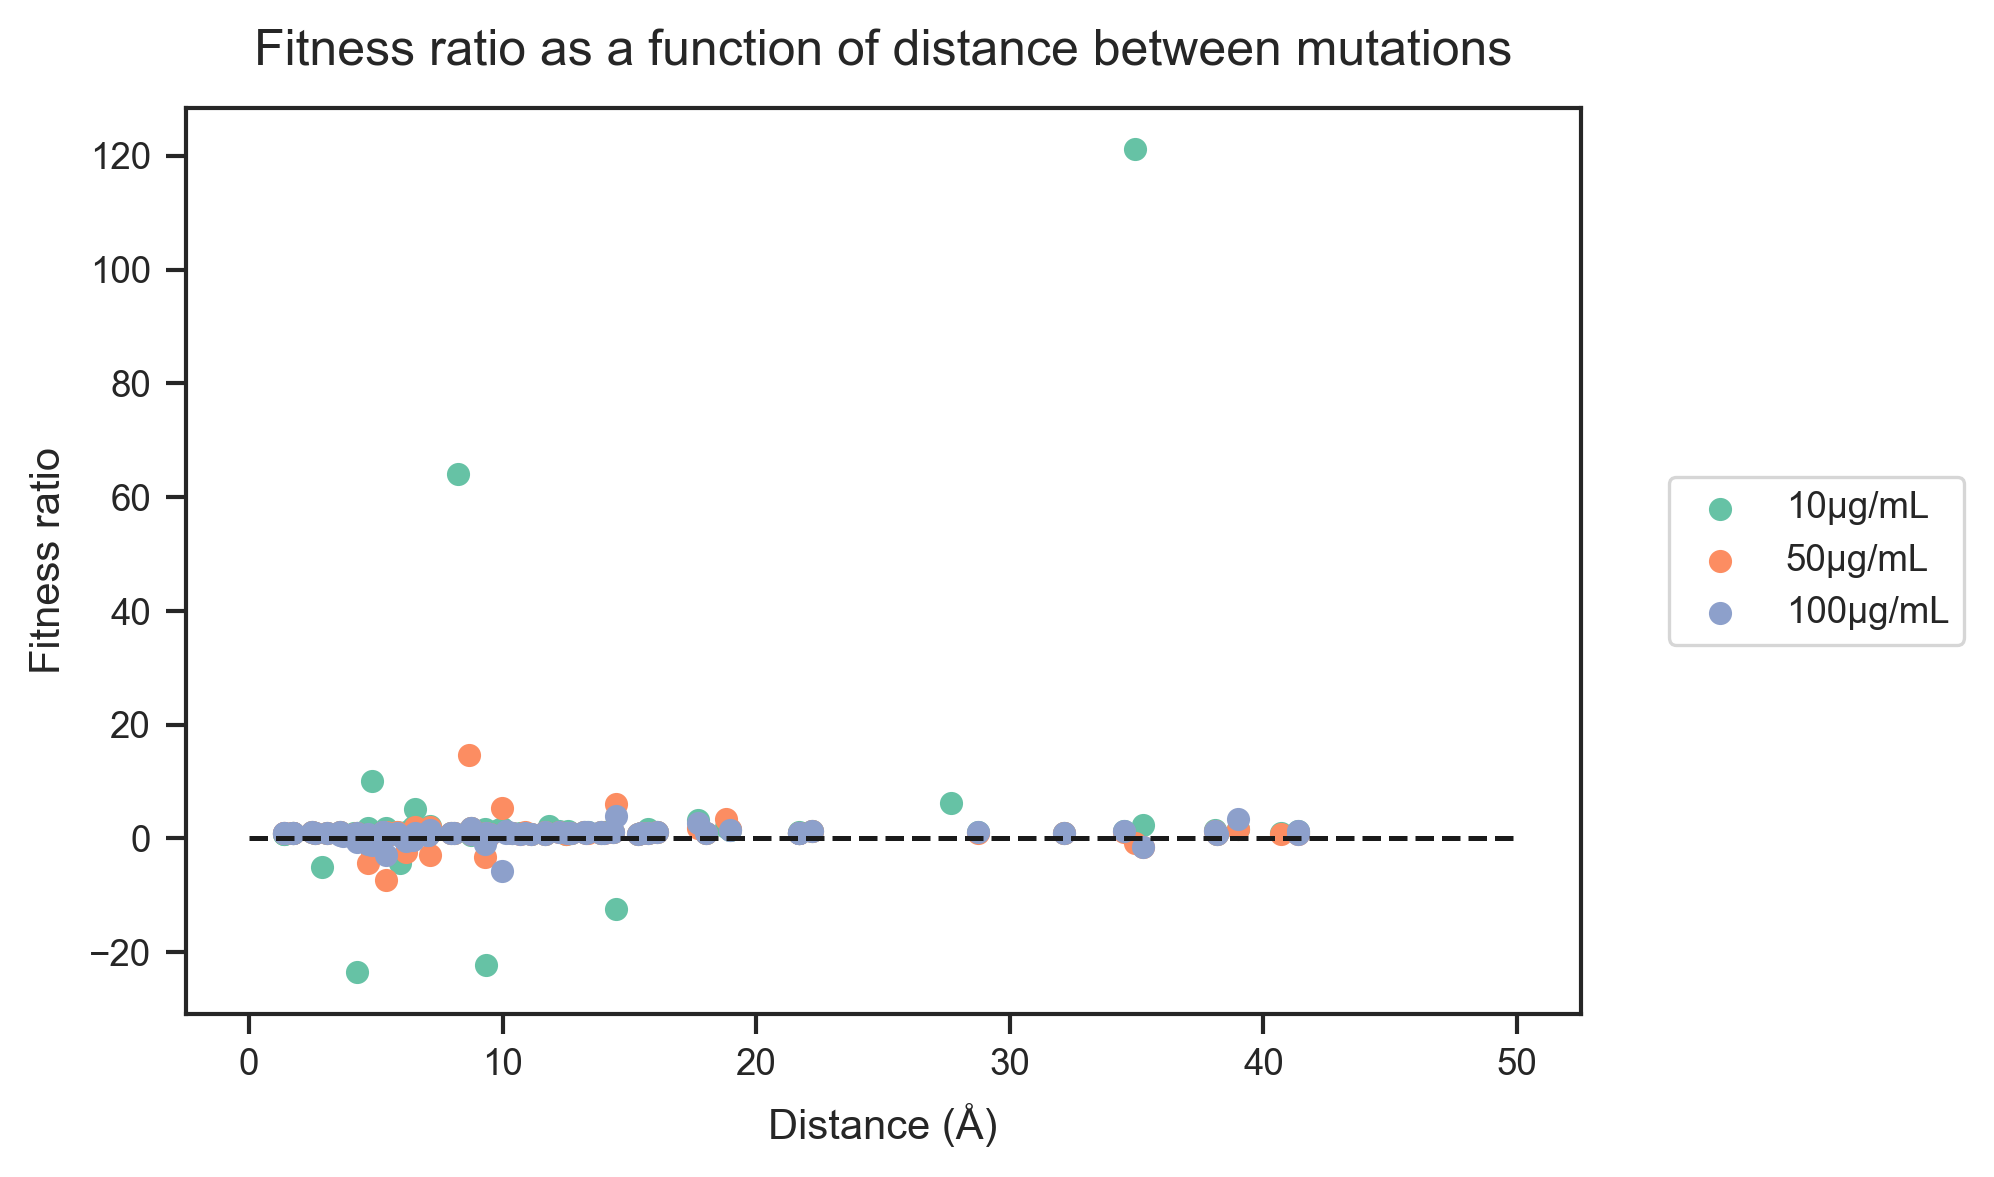

In [135]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots()
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.ratio_ten,
             label='10µg/mL', edgecolor=None)
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.ratio_fifty,
             label='50µg/mL', edgecolor=None)
sns.scatterplot(ax=ax,
             x=df_result.distance,
             y=df_result.ratio_hundred,
             label='100µg/mL', edgecolor=None)

plt.hlines(y=0, xmin=0, xmax=50, linestyles='--' )

plt.title('Fitness ratio as a function of distance between mutations',
          pad=10,
          fontsize=12)
plt.xlabel('Distance (Å)',
           labelpad=5,
           fontsize=10)
plt.ylabel('Fitness ratio',
           labelpad=5,
           fontsize=10)

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

# plt.savefig('Fitness difference as a function of distance between mutations - overlaid.png')

Text(0, 0.5, 'Fitness ratio')

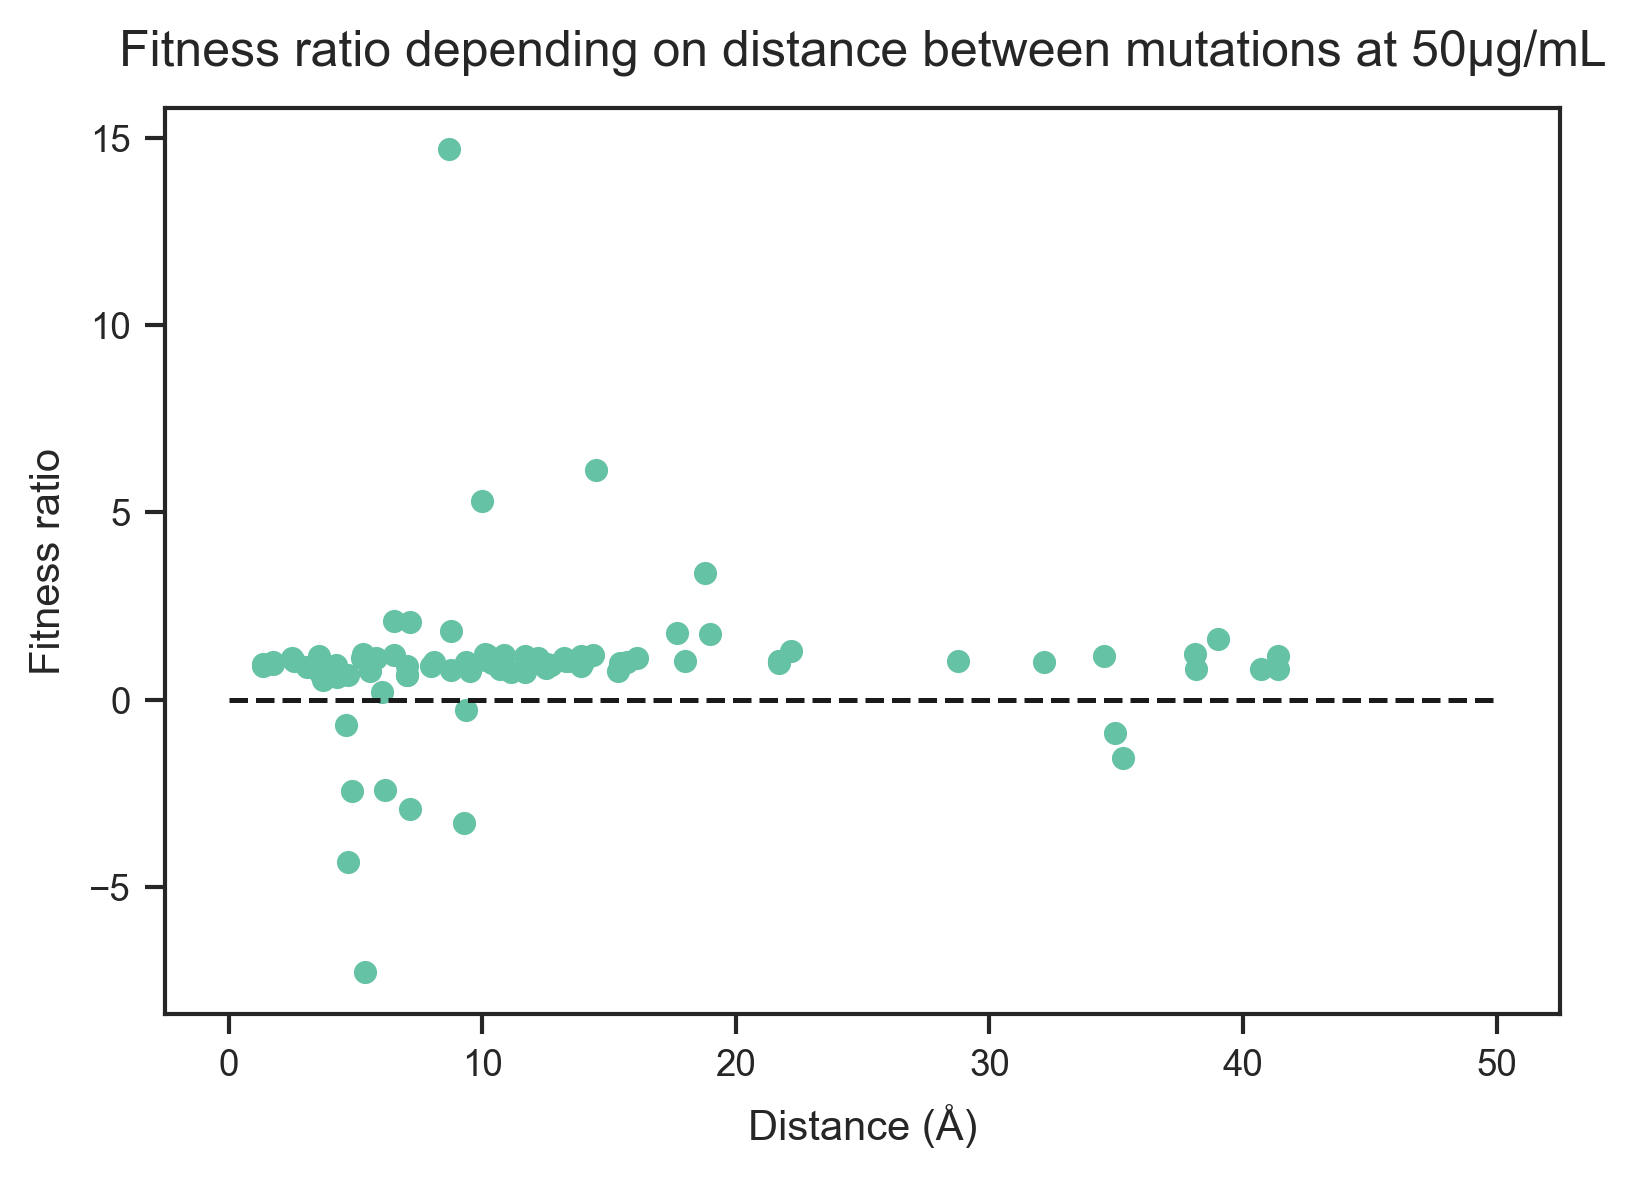

In [136]:
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')


sns.scatterplot(
             x=df_result.distance,
             y=df_result.ratio_fifty,
             edgecolor=None)


plt.hlines(y=0, xmin=0, xmax=50, linestyles='--' )

plt.title('Fitness ratio depending on distance between mutations at 50µg/mL',
          pad=10,
          fontsize=12)
plt.xlabel('Distance (Å)',
           labelpad=5,
           fontsize=10)
plt.ylabel('Fitness ratio',
           labelpad=5,
           fontsize=10)

# plt.savefig('Fitness difference as a function of distance between mutations - overlaid.png')

Text(0.5, 1.0, 'Fitness difference for mutants involving residue 533 depending on distance')

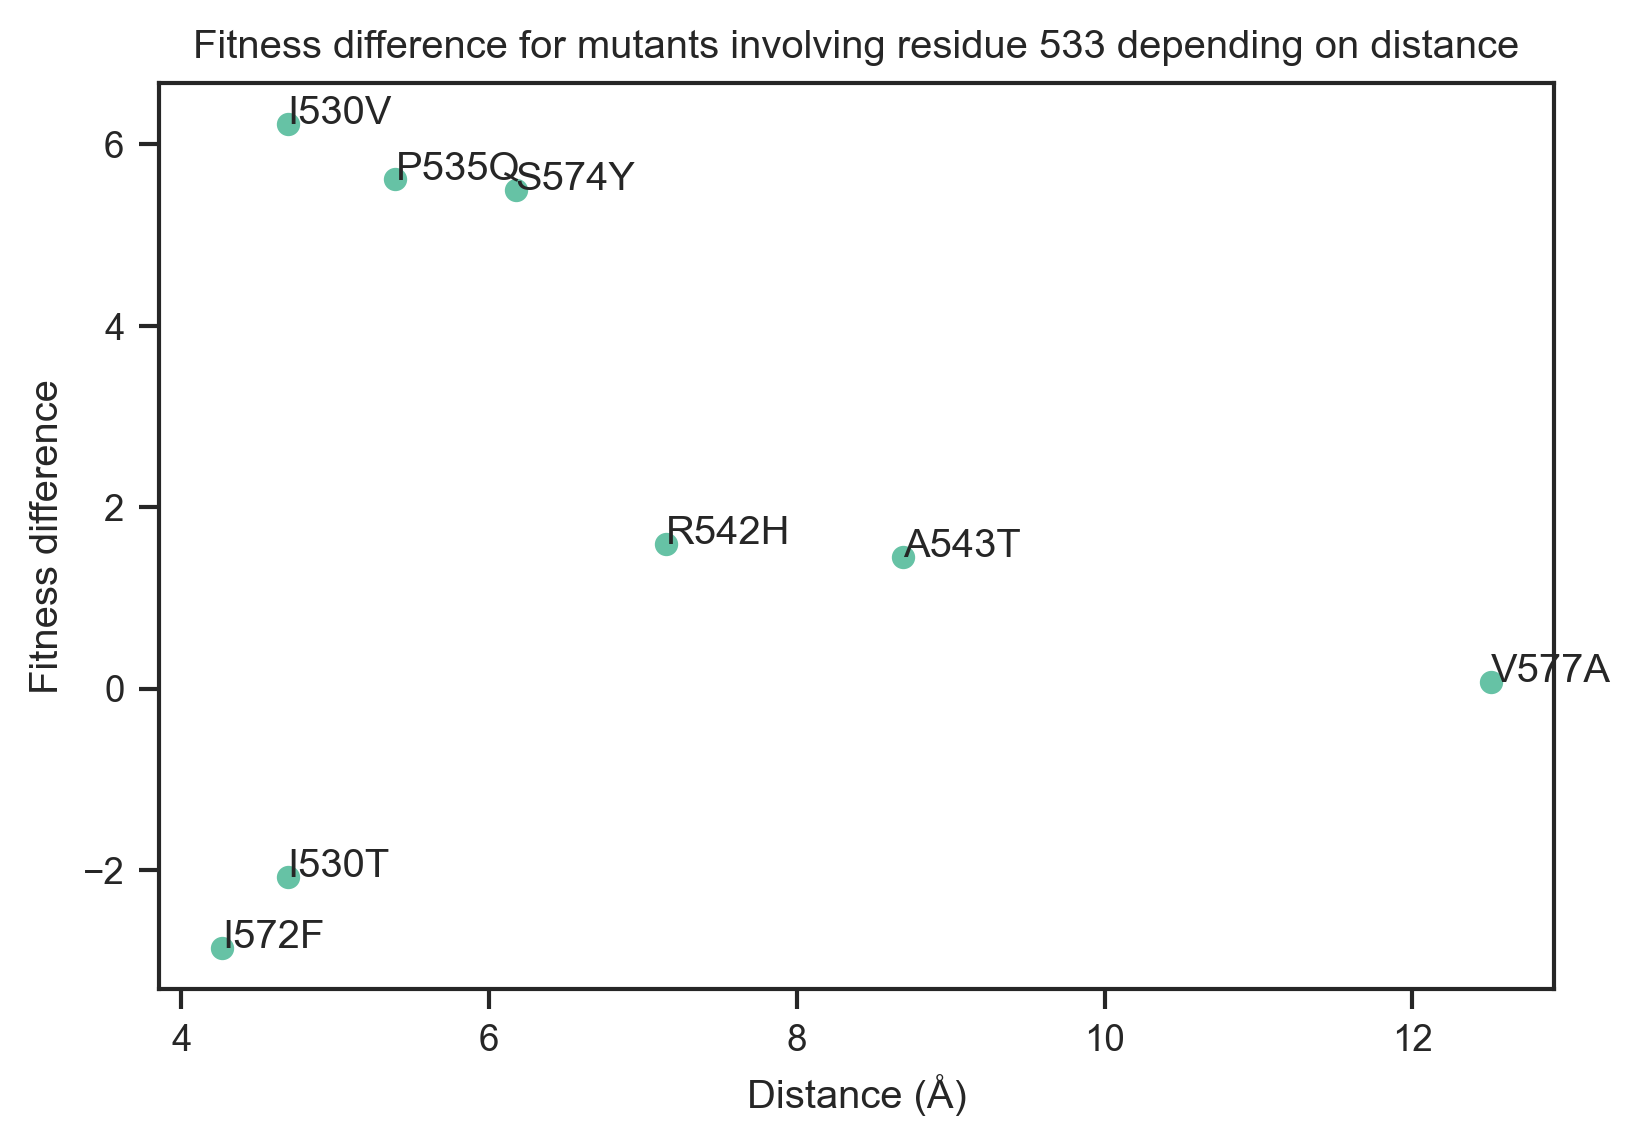

In [137]:
condition = (df_result['Mutation1'].str.contains('533')) | (df_result['Mutation2'].str.contains('533'))
df_533 = df_result.loc[condition]
df_533 = df_533.reset_index(drop=True)

sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('paper')
sns.set_style("ticks")
sns.set_palette('Set2')

fig, ax = plt.subplots()
ax.scatter(df_533['distance'], df_533['difference_fifty'])

for i, txt in enumerate(df_533['Mutation2']):
    ax.annotate(txt, (df_533['distance'][i], df_533['difference_fifty'][i]))

plt.xlabel('Distance (Å)')
plt.ylabel('Fitness difference')
plt.title('Fitness difference for mutants involving residue 533 depending on distance')

In [138]:
fig = px.scatter_3d(data_frame=df_result,
    x=df_result['fitness_1_fifty'],
    y=df_result['fitness_2_fifty'],
    z=df_result['difference_fifty'],
    color='distance',
    opacity=0.7)

fig.show()